# Languages
This notebook formats data based around the languages used within the projects. 


In [558]:
from pathlib import Path
import json

# data_file_name = "20240125-1037.json" #  Data set used in report
data_file_name = "20240125-1037.json" 
location = Path("../data")

if not location.is_dir():
    print("Directory does not exist, do not continue")
    exit(1)

data_file = Path(location, data_file_name)
if not data_file.is_file():
    print("File does not exist, do not continue")
    exit(1)
    
with open(data_file) as df:
    data = json.load(df)

# List languages
The list is all the languages used across all projects over the lifetime of the projects with duplicates removed. The `scc` tool tries to detect auto generated code and will list the language as generated.


In [559]:
from cyclomatic_complexity import list_to_columns
lang = set()
for project in data:
    for entry in data[project]:
        for scc in entry['scc']:
            lang.add(scc['Name'])

print(f"Languages: {len(lang)}")
print(list_to_columns(sorted(lang), cols=5))

Languages: 34
CSS                                           		Go (gen)  		Markdown        		Ruby (gen)		Smarty Template		
CloudFormation (YAML)                         		HTML      		Plain Text      		Ruby HTML 		TOML           		
Docker ignore                                 		Handlebars		Plain Text (min)		Rust      		XML            		
Dockerfile                                    		JSON      		Protocol Buffers		SQL       		YAML           		
Extensible Stylesheet Language Transformations		JavaScript		Python          		SVG (min) 		YAML (min)     		
Gemfile                                       		License   		Rakefile        		Sass      		gitignore      		
Go                                            		Makefile  		Ruby            		Shell     		


# Mapping dates across projects


In [560]:
largest = {"project": '', 'merges': 0}
for project in data:
    if len(data[project]) > largest['merges']:
        largest['project'] = project
        largest['merges'] = len(data[project])

print(largest)

{'project': 'multicluster-gateway-controller', 'merges': 309}


In [561]:
from tabulate import tabulate
from pprint import pprint
from datetime import datetime
timestamp_format = "%a %b %d %H:%M:%S %Y %z"
# for merge in data[largest['project']]:
#     t = merge['timestamp']
#     d = datetime.strptime(t, timestamp_format)
#     print(d)

history_dates = []
for project in data:
    if not len(data[project]):
        continue
    project_history = {"project": project, "first_merge": datetime.utcnow(), "last_merge": datetime(2000, 1, 1)}
    for merge in data[project]:
        timestamp = datetime.strptime(merge['timestamp'], timestamp_format)
        
        if timestamp.timestamp() < project_history['first_merge'].timestamp():
            project_history['first_merge'] = timestamp
        
        if timestamp.timestamp() > project_history['last_merge'].timestamp():
            project_history['last_merge'] = timestamp
    
    history_dates.append(project_history)

history_dates = sorted(history_dates, key=lambda x: x['first_merge'])
headers = {"project": 'Project', "first_merge": 'First Merge', "last_merge": 'Last Merge'}
table = tabulate(history_dates, headers)

print(table)

Project                          First Merge                Last Merge
-------------------------------  -------------------------  -------------------------
limitador                        2020-05-20 12:42:32+02:00  2024-01-17 17:51:45+00:00
authorino                        2020-11-04 16:32:57+01:00  2024-01-22 14:11:21+01:00
limitador-operator               2020-12-15 15:32:19+01:00  2024-01-15 10:39:33-05:00
kuadrant-operator                2021-03-01 14:37:31+01:00  2024-01-24 11:38:13+00:00
infinispan-rs                    2021-04-20 13:40:28+02:00  2021-12-24 13:45:26+01:00
kuadrantctl                      2021-06-21 16:00:16+02:00  2023-11-30 11:28:45+01:00
authorino-operator               2021-11-17 10:28:45+00:00  2024-01-15 10:40:56-05:00
authorino-examples               2021-11-23 13:22:14+01:00  2023-10-26 16:56:07+02:00
wasm-shim                        2021-11-25 19:30:58+05:30  2024-01-15 10:41:08-05:00
architecture                     2021-12-22 13:37:02+01:00  2024-01-0

In [562]:
testing = False

def xx(dataset):
    youngest = {'project': None, 'timestamp': datetime(2000, 1, 1)}
    project_youngest = {}
    for project in dataset:
        if project not in project_youngest:
            project_youngest.setdefault(project, {'commit': None, 'timestamp': datetime(2000, 1, 1)})
        for entry in dataset[project]:
            if entry['timestamp'].timestamp() > youngest['timestamp'].timestamp():
                youngest['project'] = project
                youngest['timestamp'] = entry['timestamp']
            if entry['timestamp'].timestamp() > project_youngest[project]['timestamp'].timestamp():
                project_youngest[project] = entry
    if youngest['project'] is not None:
        dataset[youngest['project']].remove(project_youngest[youngest['project']])
    return youngest, project_youngest, dataset
    
def get_row_set():
    if testing:
        sample = {
            'P1': [
                {"commit": 'A', 'timestamp': datetime(2000, 1, 9)},
                {"commit": 'B', 'timestamp': datetime(2000, 1, 5)},
                {"commit": 'C', 'timestamp': datetime(2000, 1, 4)},
            ],
            'P2': [
                {"commit": '1', 'timestamp': datetime(2000, 1, 8)},
                {"commit": '2', 'timestamp': datetime(2000, 1, 7)},
                {"commit": '3', 'timestamp': datetime(2000, 1, 6)},
            ]
        }
    else:
        sample = {}
        for project in data:
            if not len(data[project]):
                continue
            if project not in sample:
                sample.setdefault(project, [])
            for entry in data[project]:
                sample[project].append({'commit': entry['commit'], 'timestamp': datetime.strptime(entry['timestamp'], timestamp_format)})

    for project in sample:
        sample[project] = sorted(sample[project], key=lambda x: x['timestamp'])

    counter = 1
    rows = []

    while counter:
        counter = 0
        for project in sample:
            if len(sample[project]) > counter:
                counter = len(sample[project])

        youngest, project_youngest, sample = xx(sample)
        
        if youngest['project'] is None:
            continue

        row = {'timestamp': youngest['timestamp']}
        for project in project_youngest:
            row[project] = project_youngest[project]['commit']
        rows.append(row)
    return rows

# Lines of Code


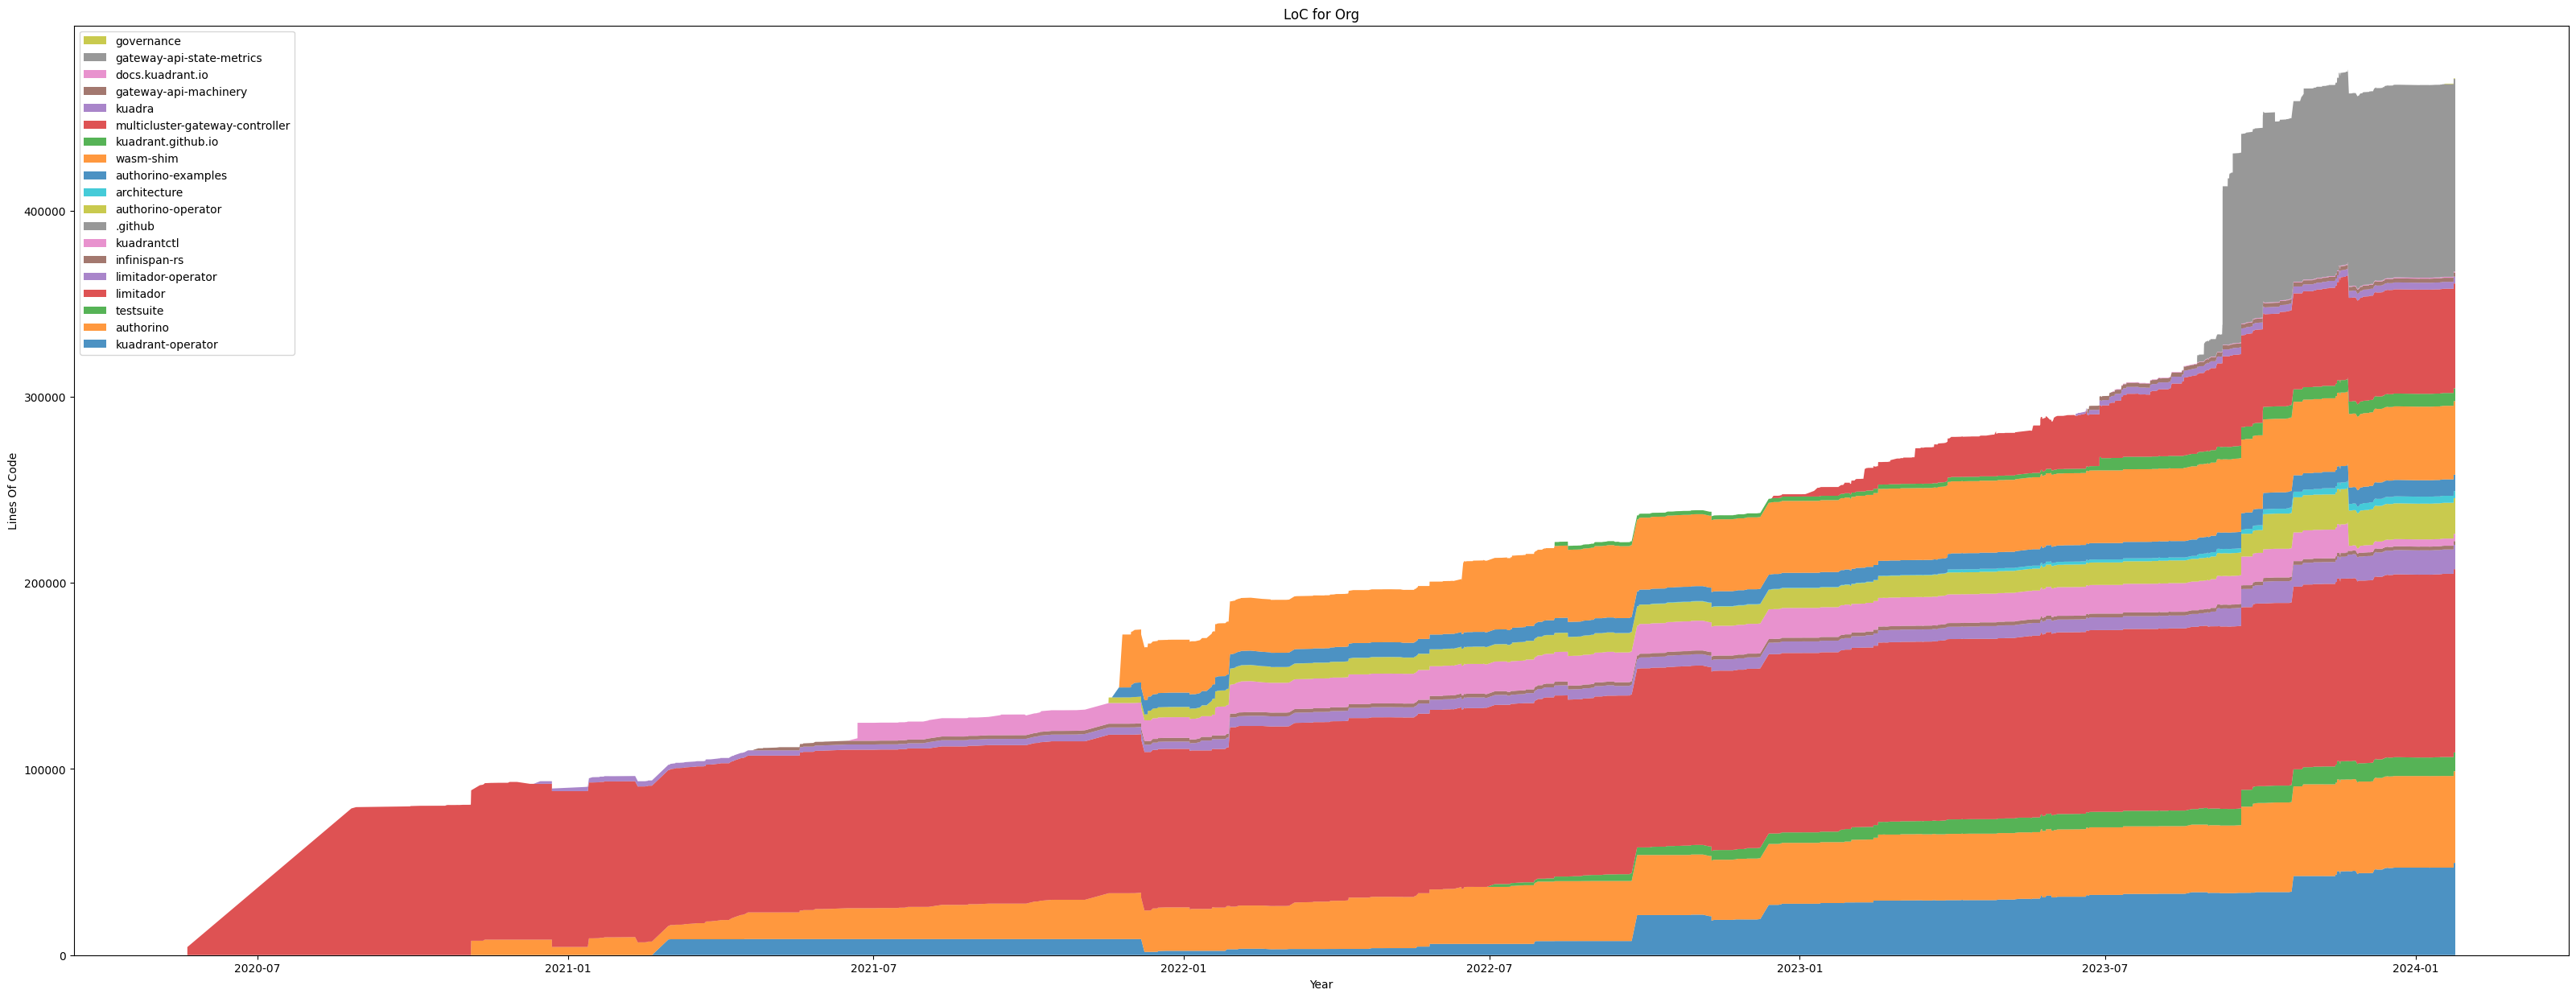

In [563]:
import matplotlib.pyplot as plt

def scc_total(scc):
    total = 0
    for entry in scc:
        total += entry['Lines']
    return total

loc_rows = get_row_set()

for row in loc_rows:
    for key in row:
        if key == 'timestamp' or row[key] is None:
            continue

        commit = filter(lambda x: x['commit'] == row[key], data[key])
        commit = next(commit, None)
        if commit:
            row[key] = scc_total(commit['scc'])
            
timestamps = []
projects = {}
for row in loc_rows:
    for key in row:
        if key == 'timestamp':
            timestamps.append(row[key])
            continue
        if key not in projects:
            projects.setdefault(key, [])
        value = row[key]
        if value is None:
            value = 0
        projects[key].append(value)
        
fig, ax = plt.subplots(figsize=(40, 15))

ax.stackplot(timestamps, projects.values(),
             labels= projects.keys(), alpha=0.8)
ax.legend(loc='upper left', reverse=True)
ax.set_title('LoC for Org')
ax.set_xlabel('Year')
ax.set_ylabel('Lines Of Code')

plt.show()

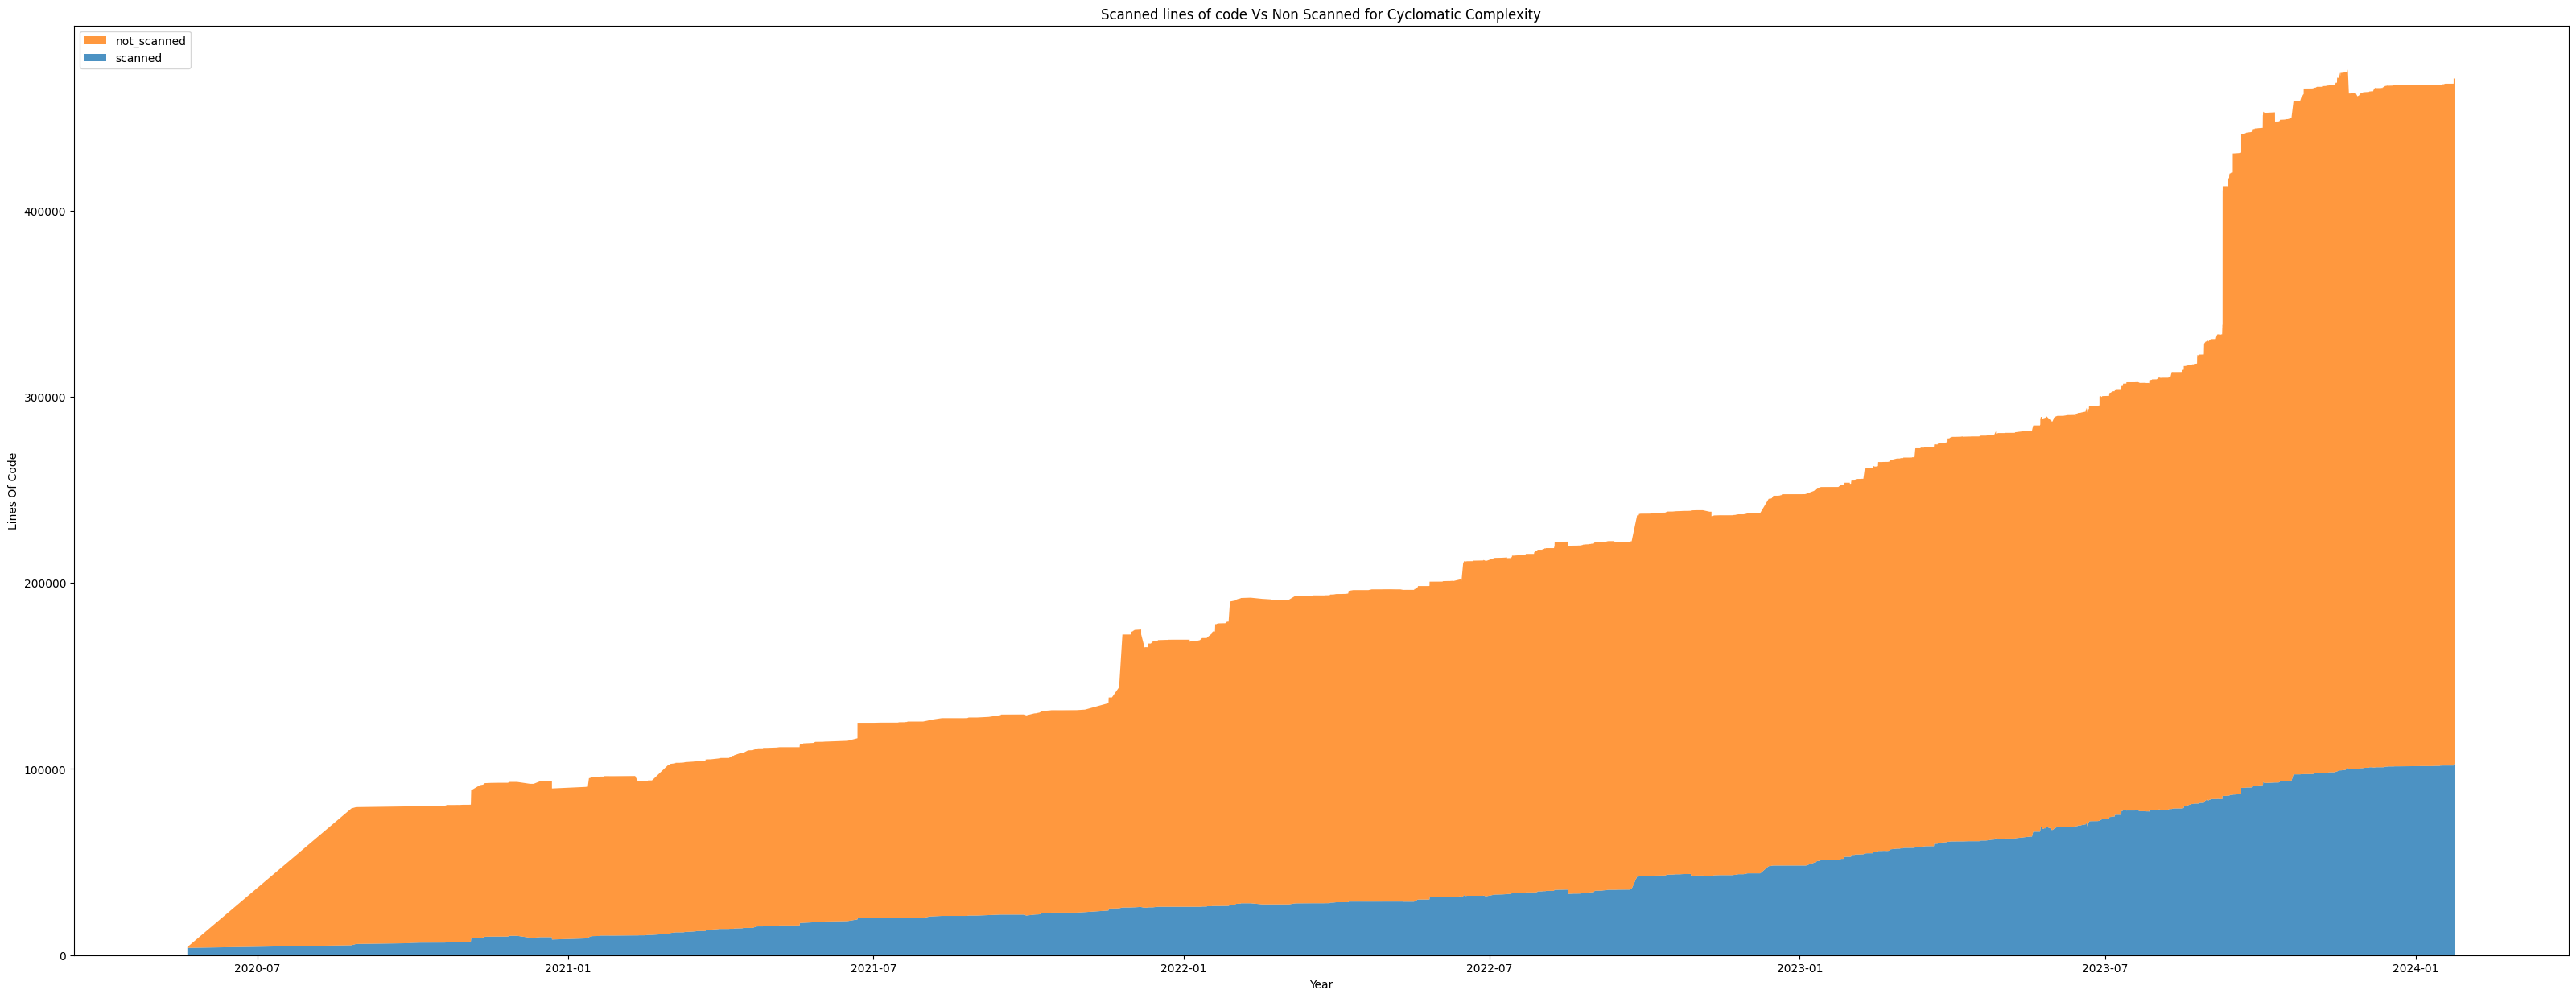

In [564]:
import matplotlib.pyplot as plt

def scc_was_scanned(source, filters):
    not_scanned = 0
    scanned = 0
    
    for s in source:
        if s['Name'].lower() in filters:
            scanned += s['Lines']
        else:
            not_scanned += s['Lines']
    
    return scanned, not_scanned

cc_lang = ['rust', 'go', 'python', 'javascript', 'ruby']
loc_cc = get_row_set()

results = []
for row in loc_cc:
    result_row = {'timestamp': '', 'scanned': 0, 'not_scanned': 0}
    for key in row:
        if key == 'timestamp':
            result_row['timestamp'] = row[key]
            continue
        if row[key] is None:
            continue

        commit = filter(lambda x: x['commit'] == row[key], data[key])
        commit = next(commit, None)
        if commit:
            scanned, not_scanned = scc_was_scanned(commit['scc'], cc_lang)
            result_row['scanned'] += scanned
            result_row['not_scanned'] += not_scanned
    results.append(result_row)

timestamps = []
status = {}
for row in results:
    for key in row:
        if key == 'timestamp':
            timestamps.append(row[key])
            continue
        if key not in status:
            status.setdefault(key, [])
        value = row[key]
        if value is None:
            value = 0
        status[key].append(value)

fig, ax = plt.subplots(figsize=(40, 15))

ax.stackplot(timestamps, status.values(),
             labels= status.keys(), alpha=0.8)
ax.legend(loc='upper left', reverse=True)
ax.set_title('Scanned lines of code Vs Non Scanned for Cyclomatic Complexity')
ax.set_xlabel('Year')
ax.set_ylabel('Lines Of Code')

plt.show()



# Cyclomatic Complexity


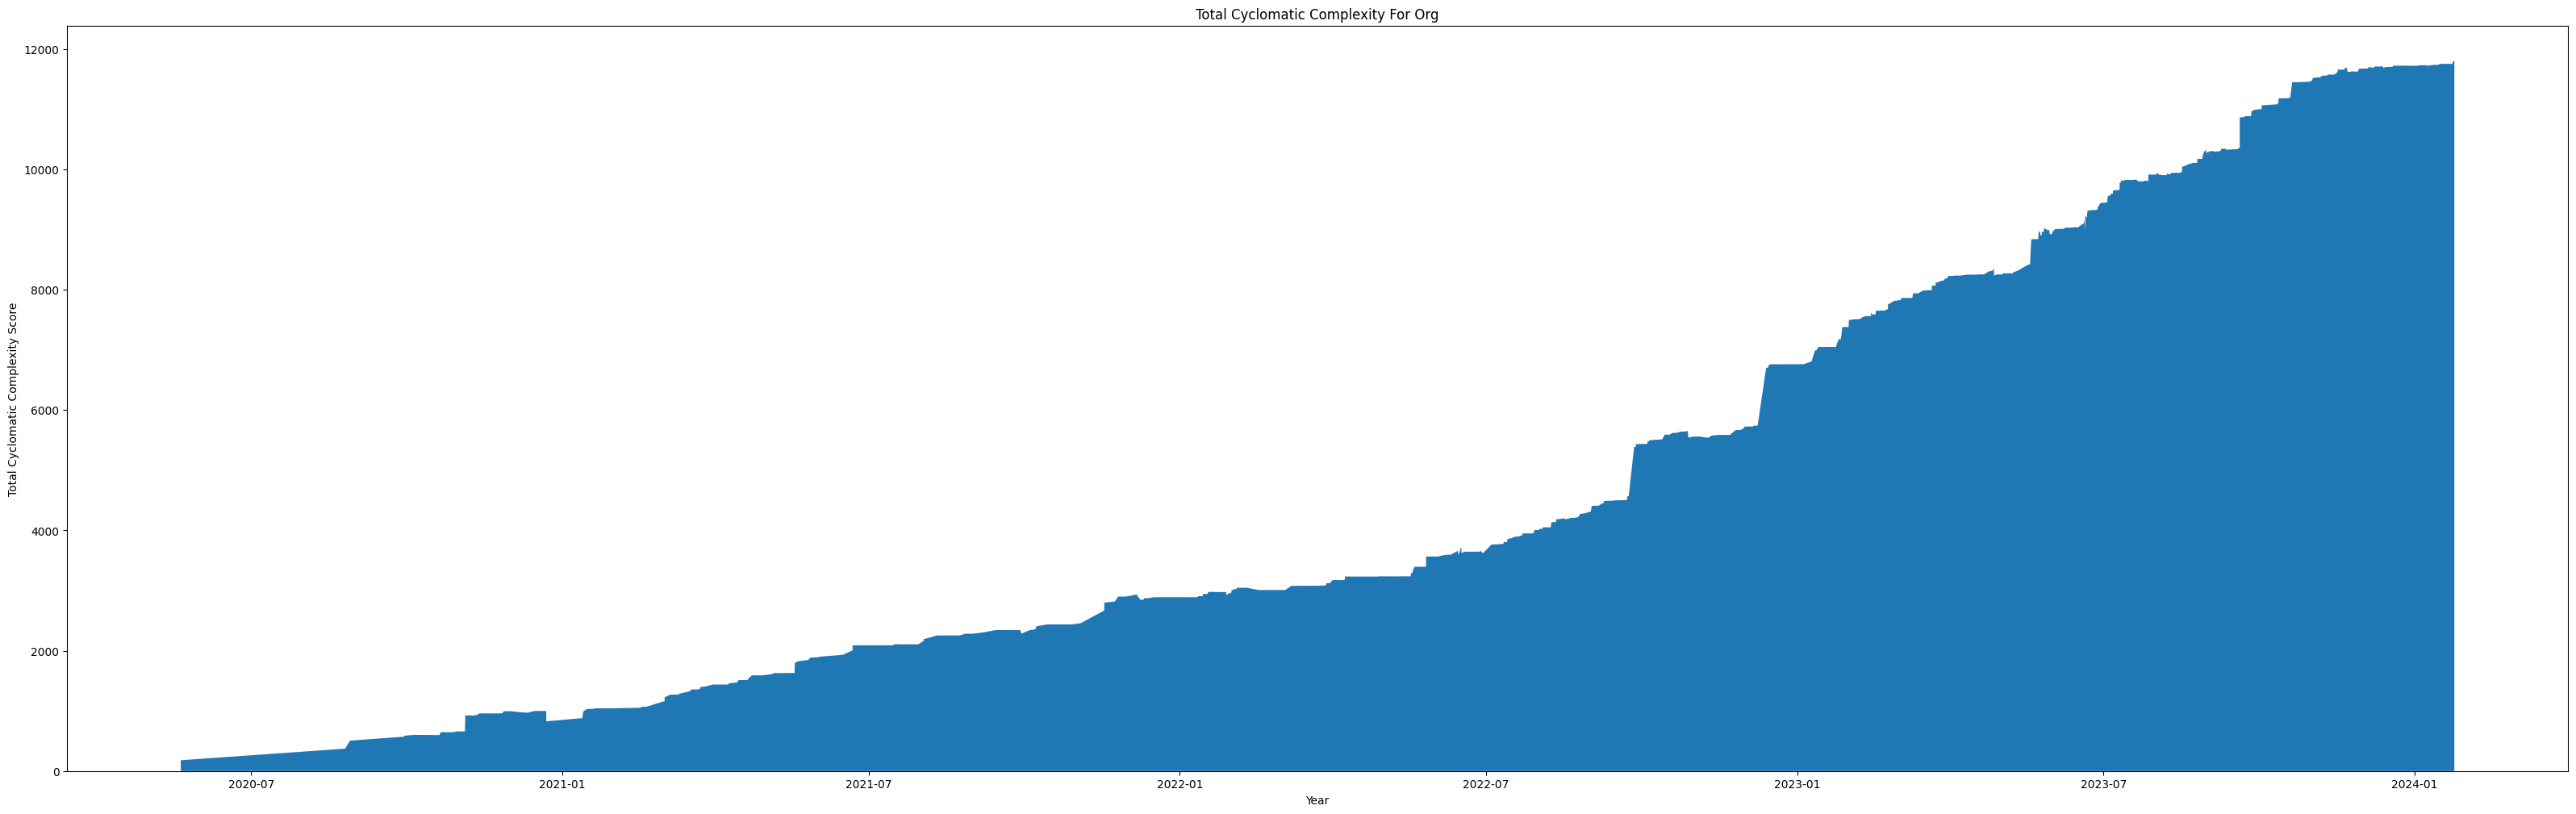

In [565]:
import matplotlib.pyplot as plt

def total_CC(dataset):
    total = 0
    for lang in dataset:
        for entry in dataset[lang]:
            total += entry['score']

    return total

total_cc_rows = get_row_set()
total_cc_results = []
for row in total_cc_rows:
    tmp = {row['timestamp']: 0}
    counter = 0
    for key in row:
        if key == 'timestamp' or row[key] is None:
            continue

        commit = filter(lambda x: x['commit'] == row[key], data[key])
        commit = next(commit, None)
        if commit:
            counter += total_CC(commit['cc'])

    total_cc_results.append({row['timestamp']: counter})
    
timestamp = []
values = []
for entry in total_cc_results:
    for key in entry:
        timestamp.append(key)
        values.append(entry[key])

fig, ax = plt.subplots(figsize=(40, 12))

ax.stackplot(timestamp, values)
ax.set_title('Total Cyclomatic Complexity For Org')
ax.set_xlabel('Year')
ax.set_ylabel('Total Cyclomatic Complexity Score')

plt.show()


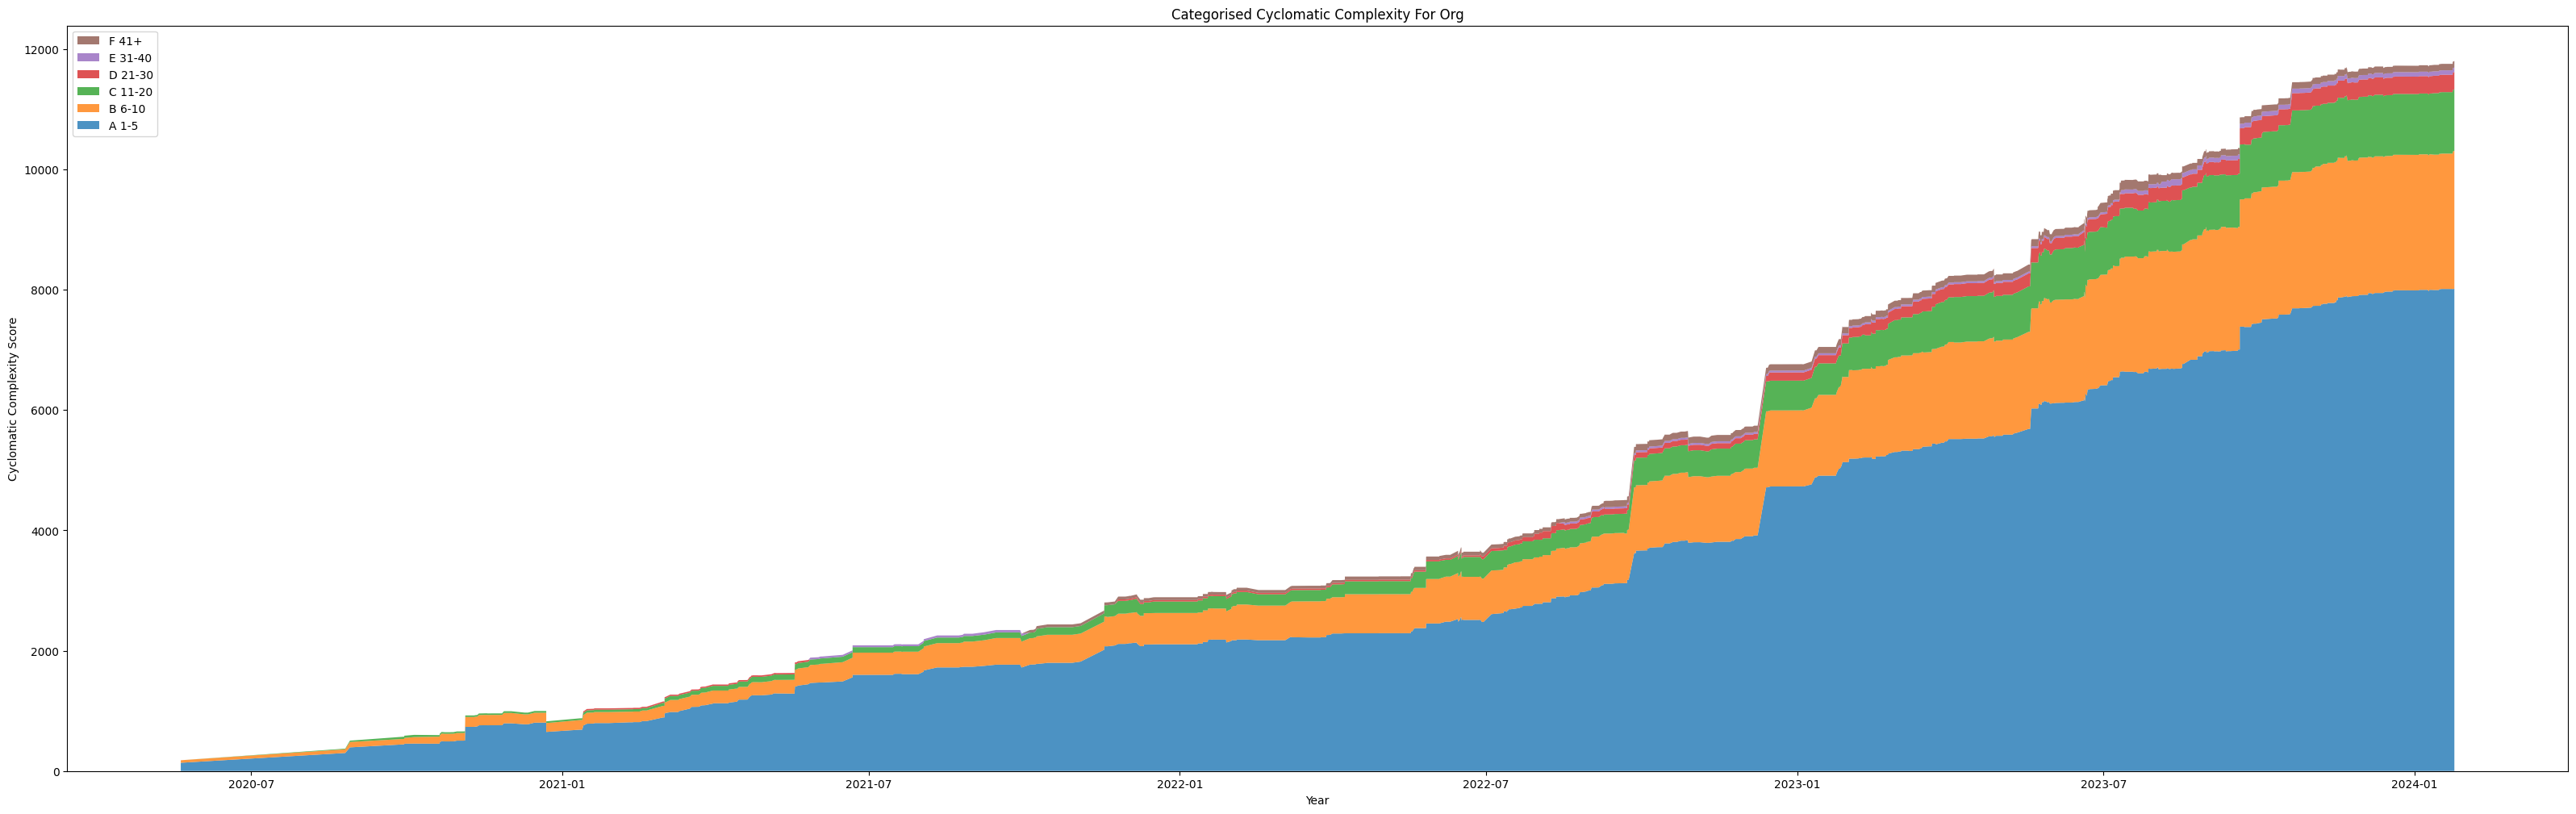

In [566]:
import matplotlib.pyplot as plt
from radon.complexity import cc_rank
def categorised_cc(dataset):
    total = {}
    for lang in dataset:
        for entry in dataset[lang]:
            rank = cc_rank(entry['score'])
            if rank not in total:
                total[rank] = 0
            total[rank] += entry['score']

    return total

categorised_cc_rows = get_row_set()
categorised_cc_results = []
for row in categorised_cc_rows:
    tmp = {row['timestamp']: 0}
    counter = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0}
    for key in row:
        if key == 'timestamp' or row[key] is None:
            continue

        commit = filter(lambda x: x['commit'] == row[key], data[key])
        commit = next(commit, None)
        if commit:
            result = categorised_cc(commit['cc'])
            for r in result:
                counter[r] += result[r]

    categorised_cc_results.append({row['timestamp']: counter})

timestamp = []
values = {}
for entry in categorised_cc_results:
    for key in entry:
        timestamp.append(key)
        for k in entry[key]:
            if k not in values:
                values.setdefault(k, [])
            values[k].append(entry[key][k])

keys = ["A 1-5", "B 6-10", "C 11-20", "D 21-30", "E 31-40", "F 41+"]

fig, ax = plt.subplots(figsize=(40, 12))

ax.stackplot(timestamp, values.values(),
             labels=keys, alpha=0.8)
ax.legend(loc='upper left', reverse=True)
ax.set_title('Categorised Cyclomatic Complexity For Org')
ax.set_xlabel('Year')
ax.set_ylabel('Cyclomatic Complexity Score')


plt.show()

# Results pre Project


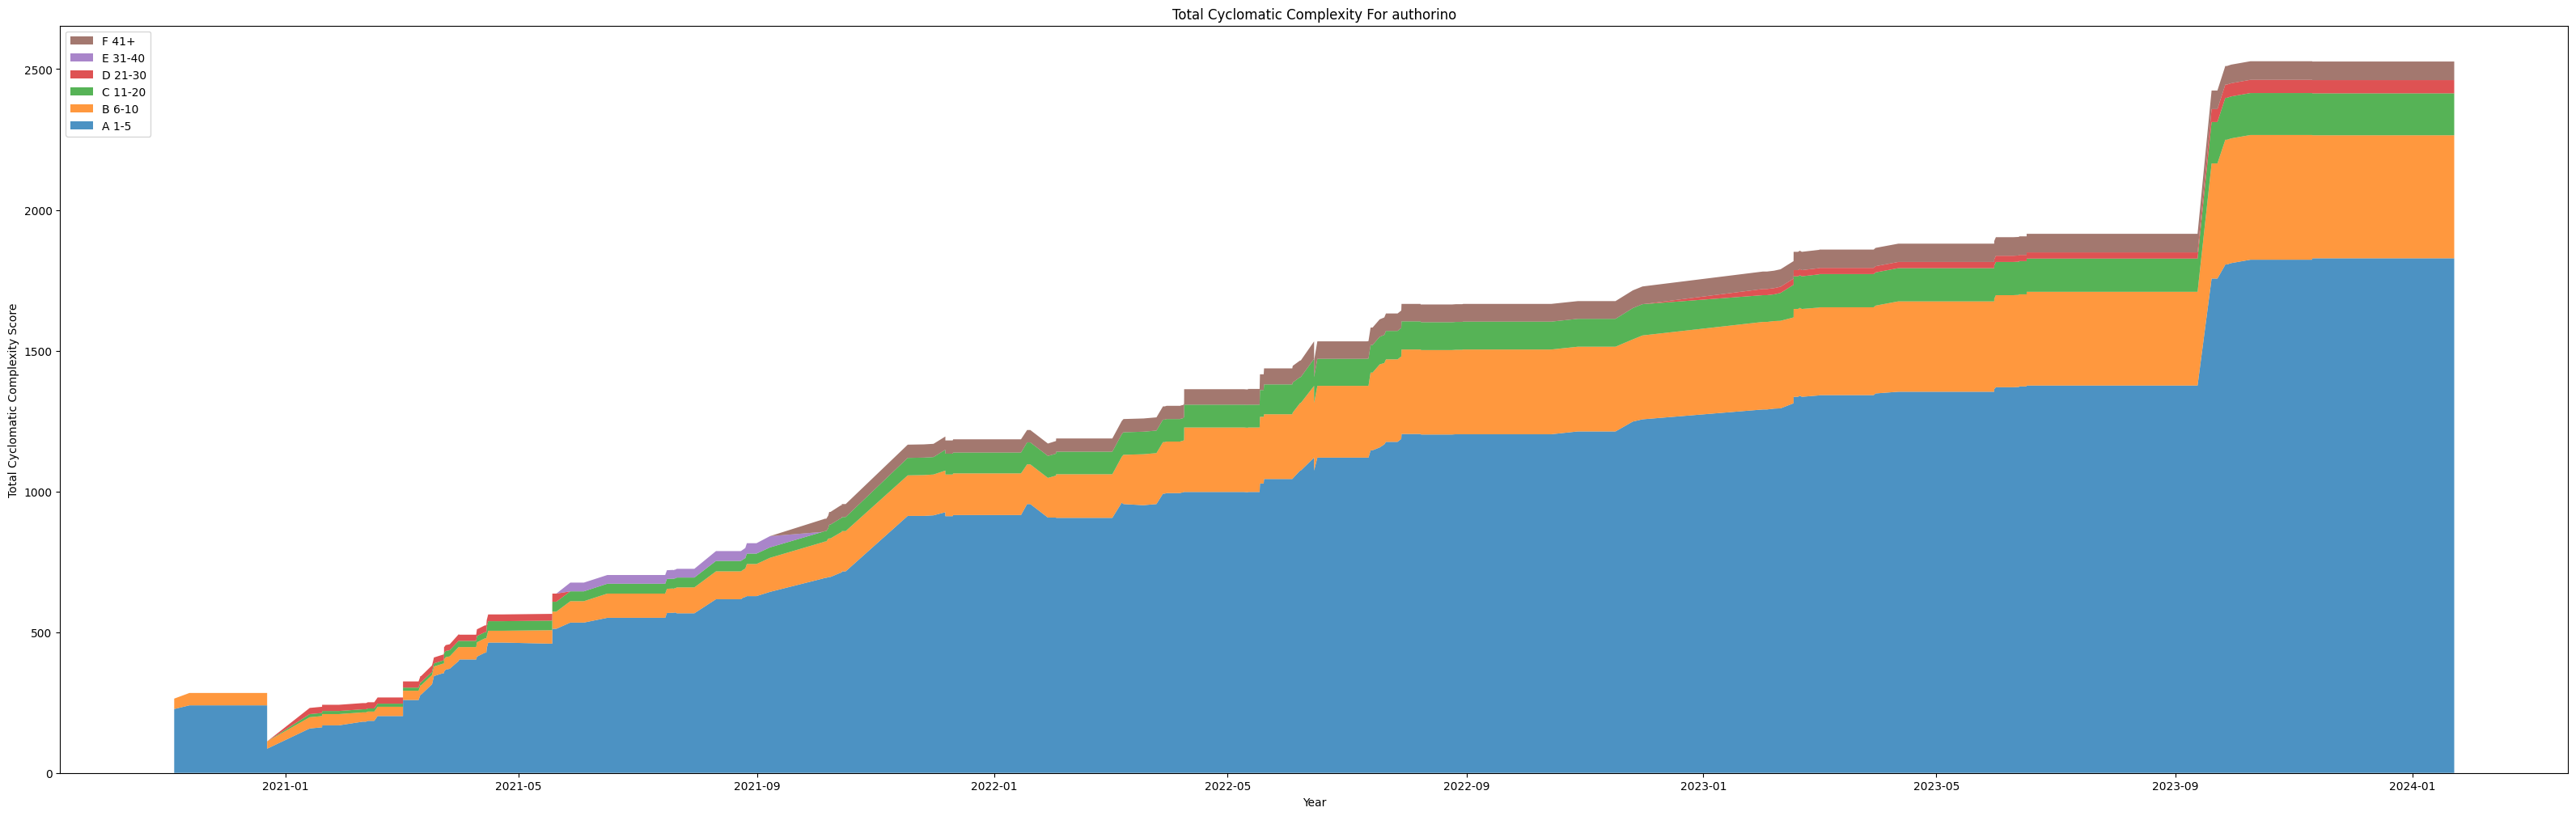

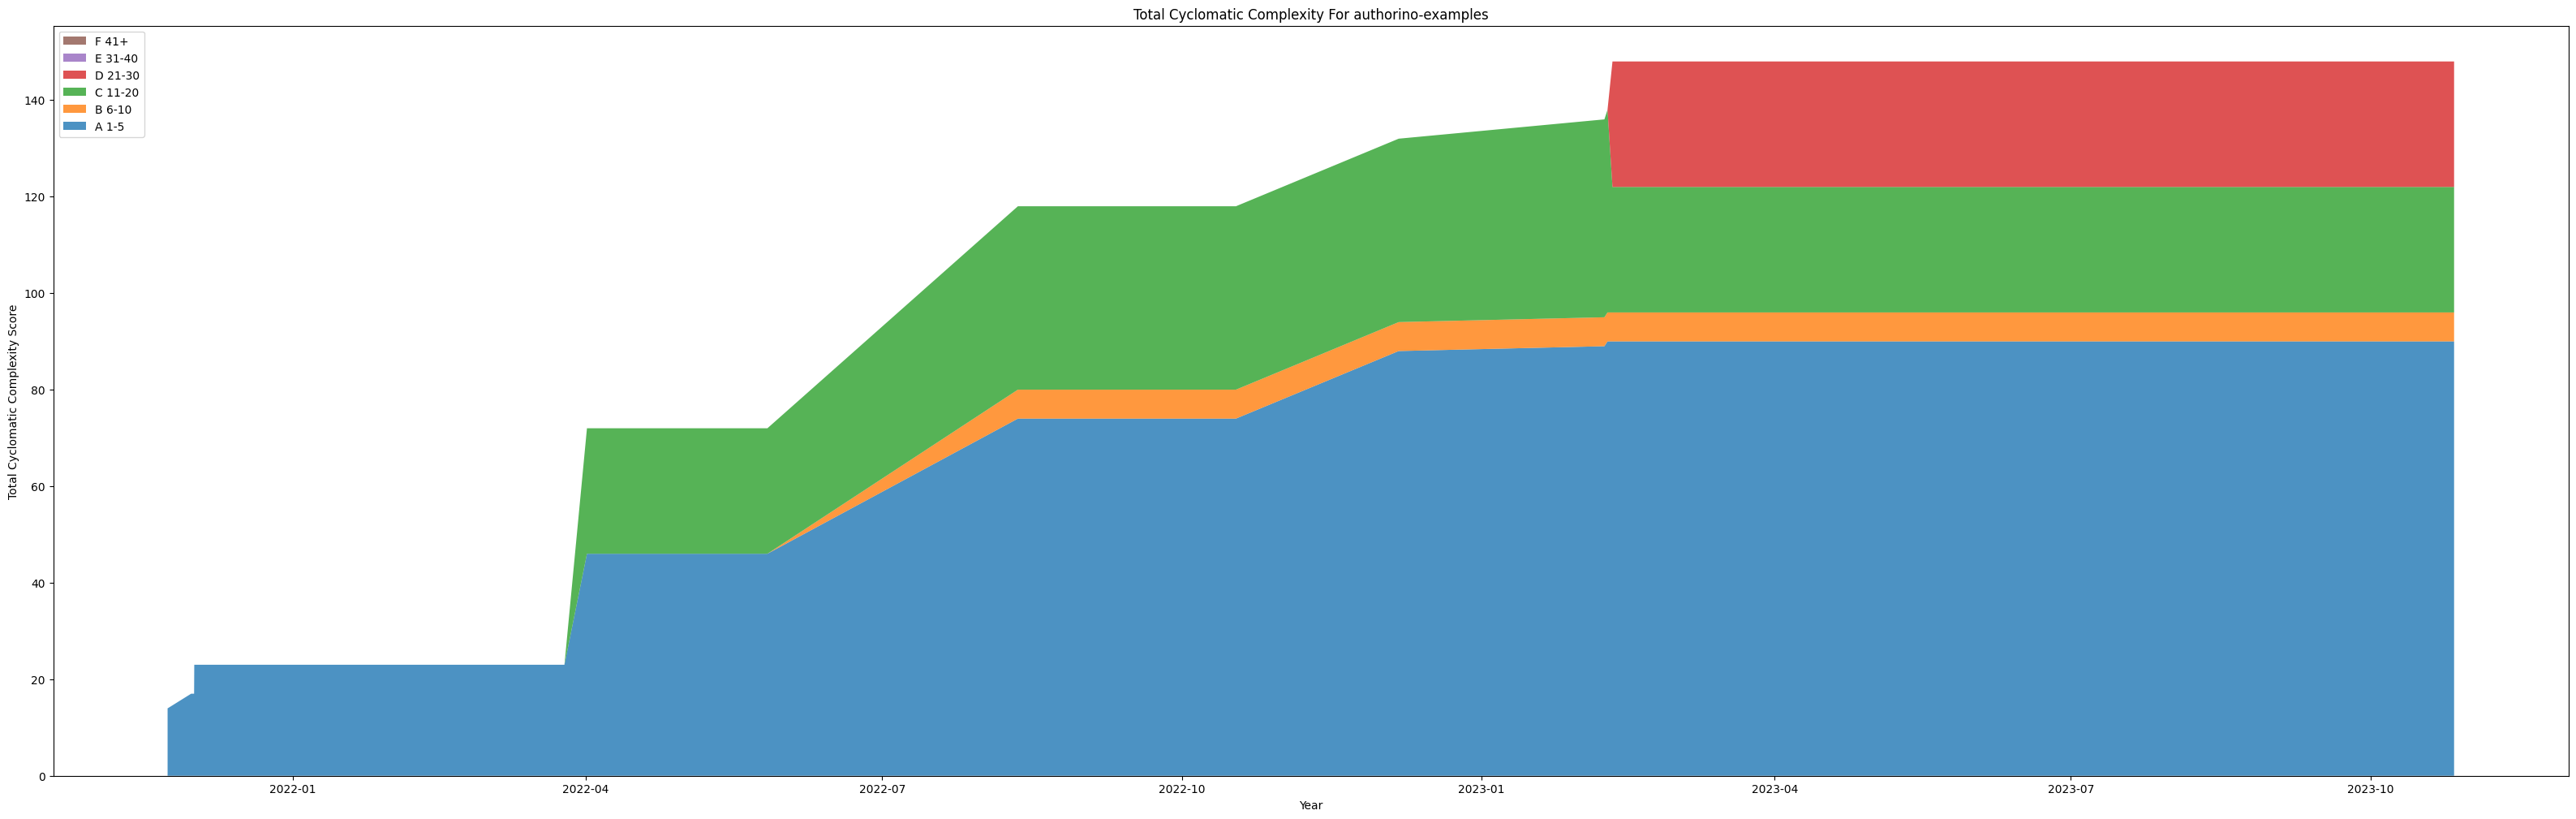

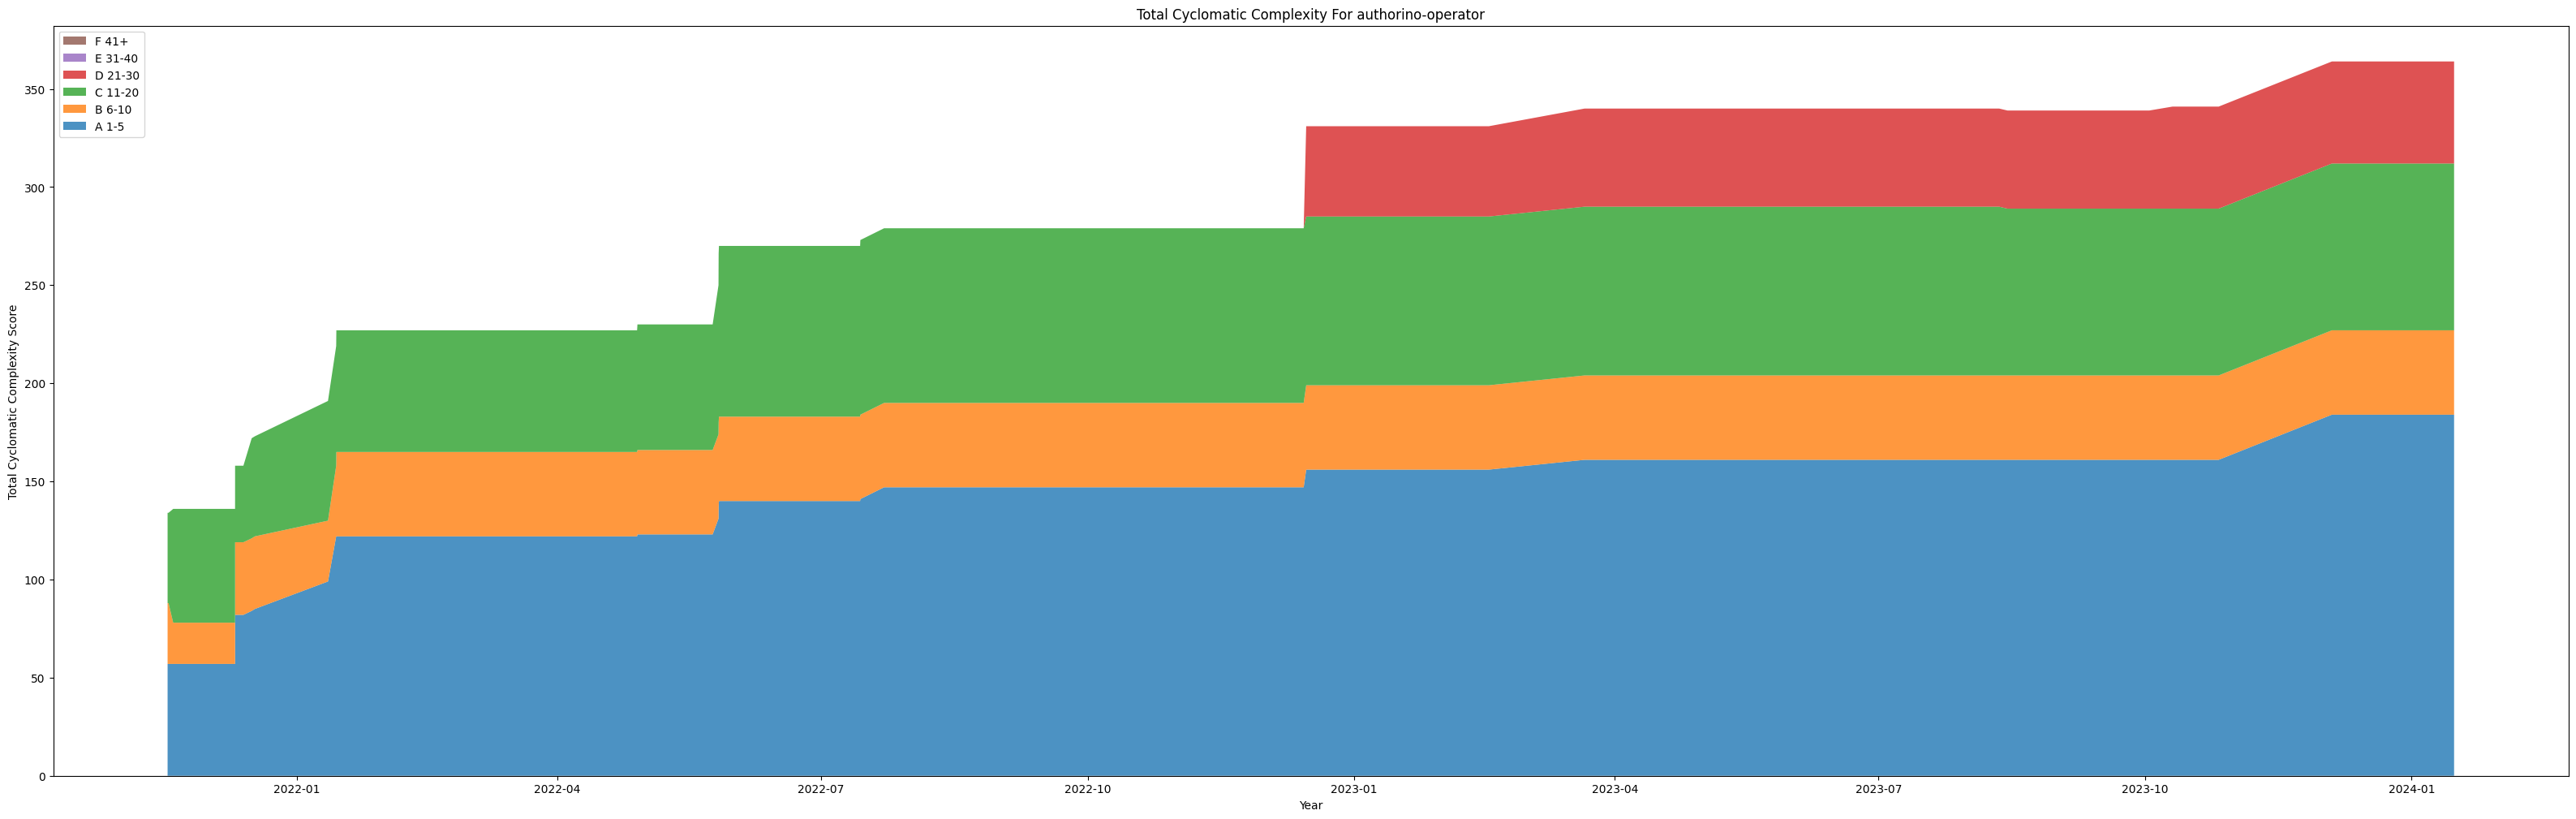

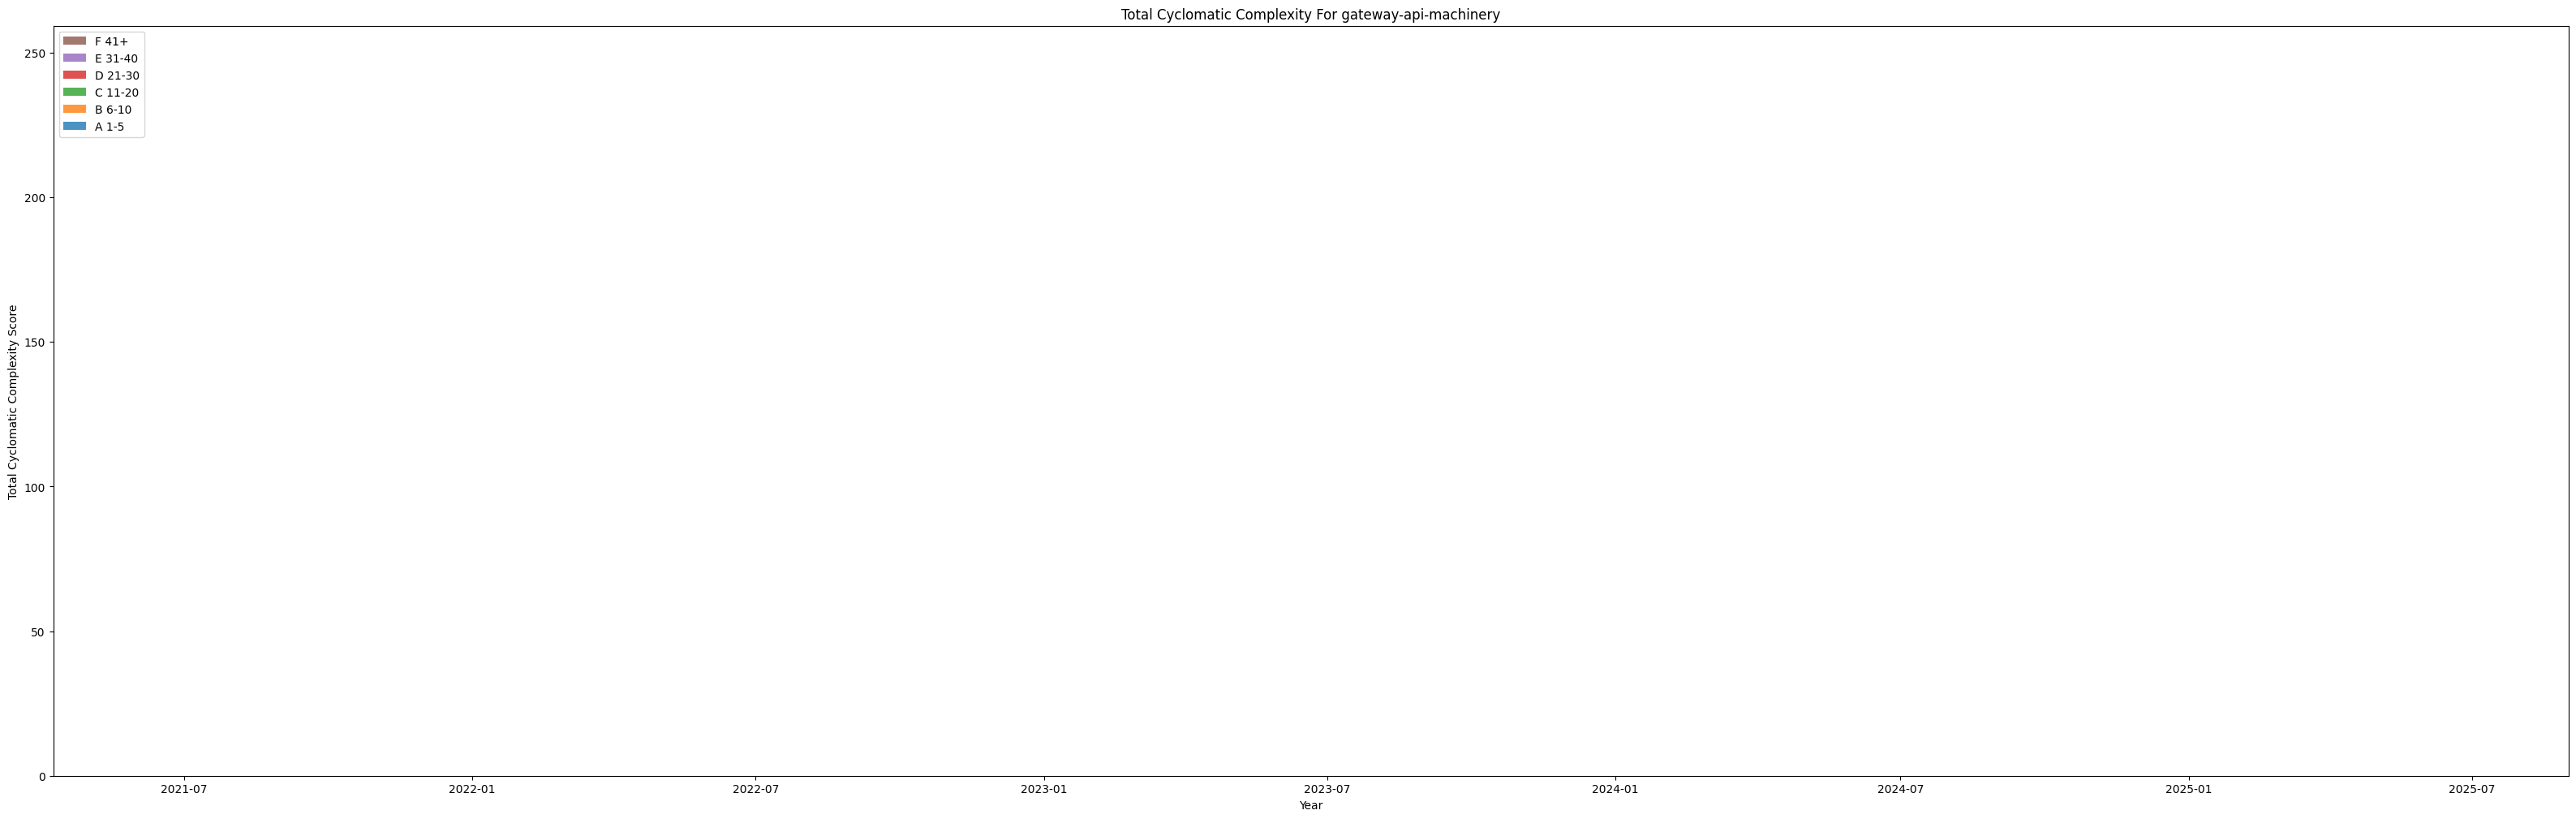

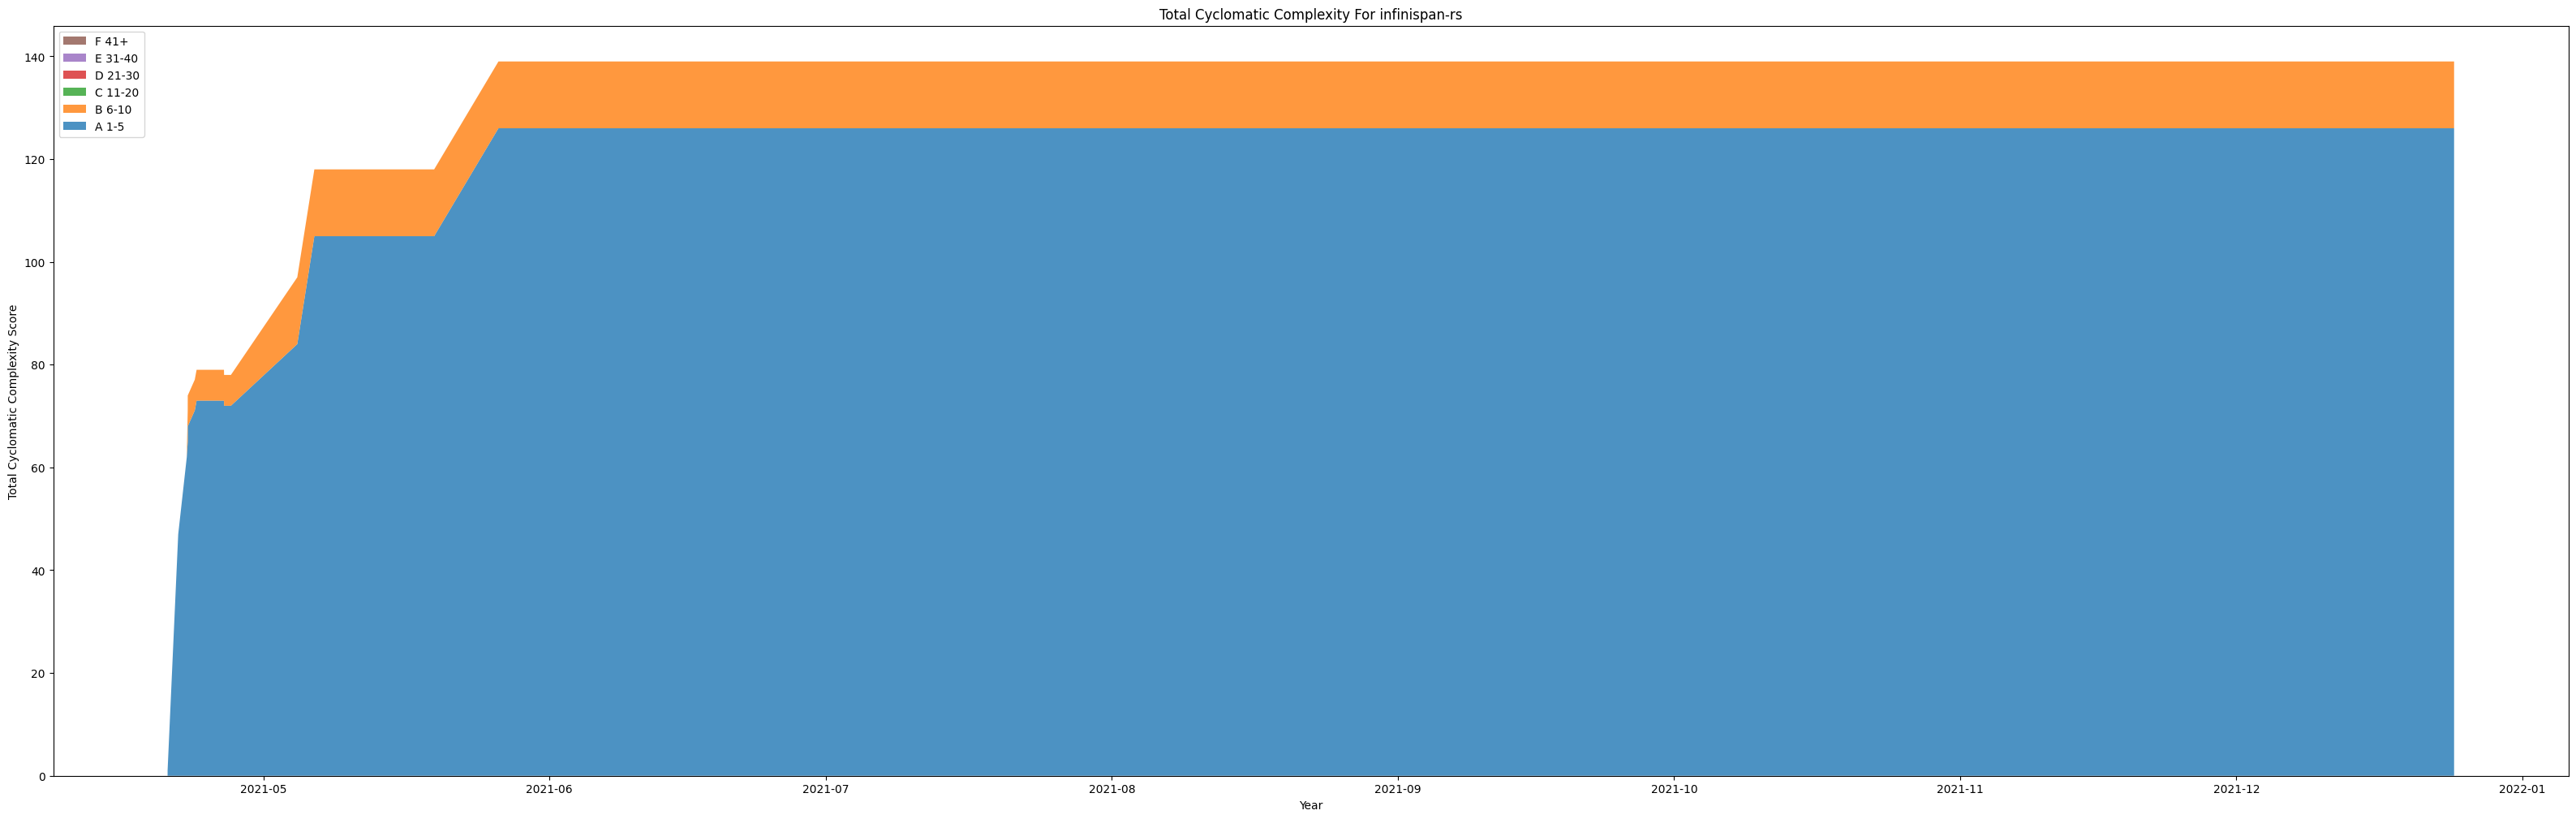

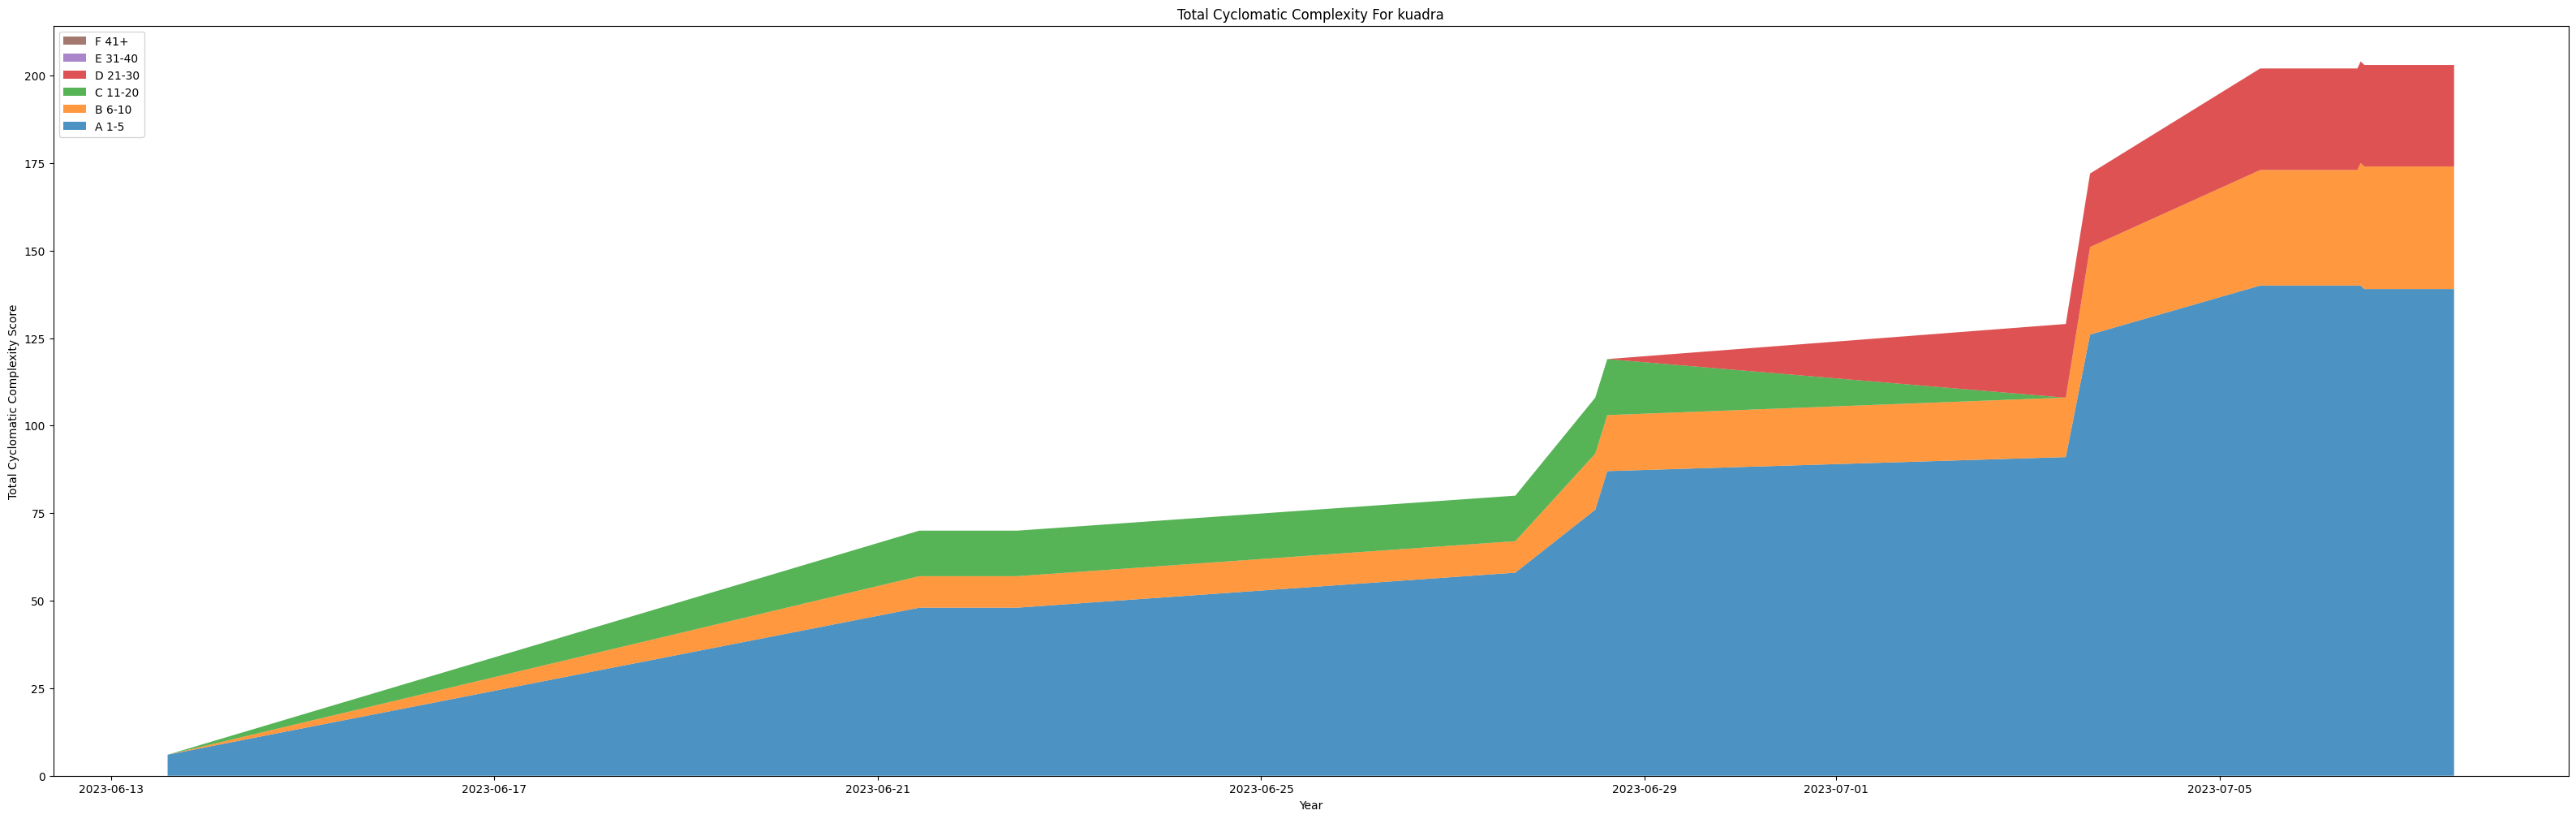

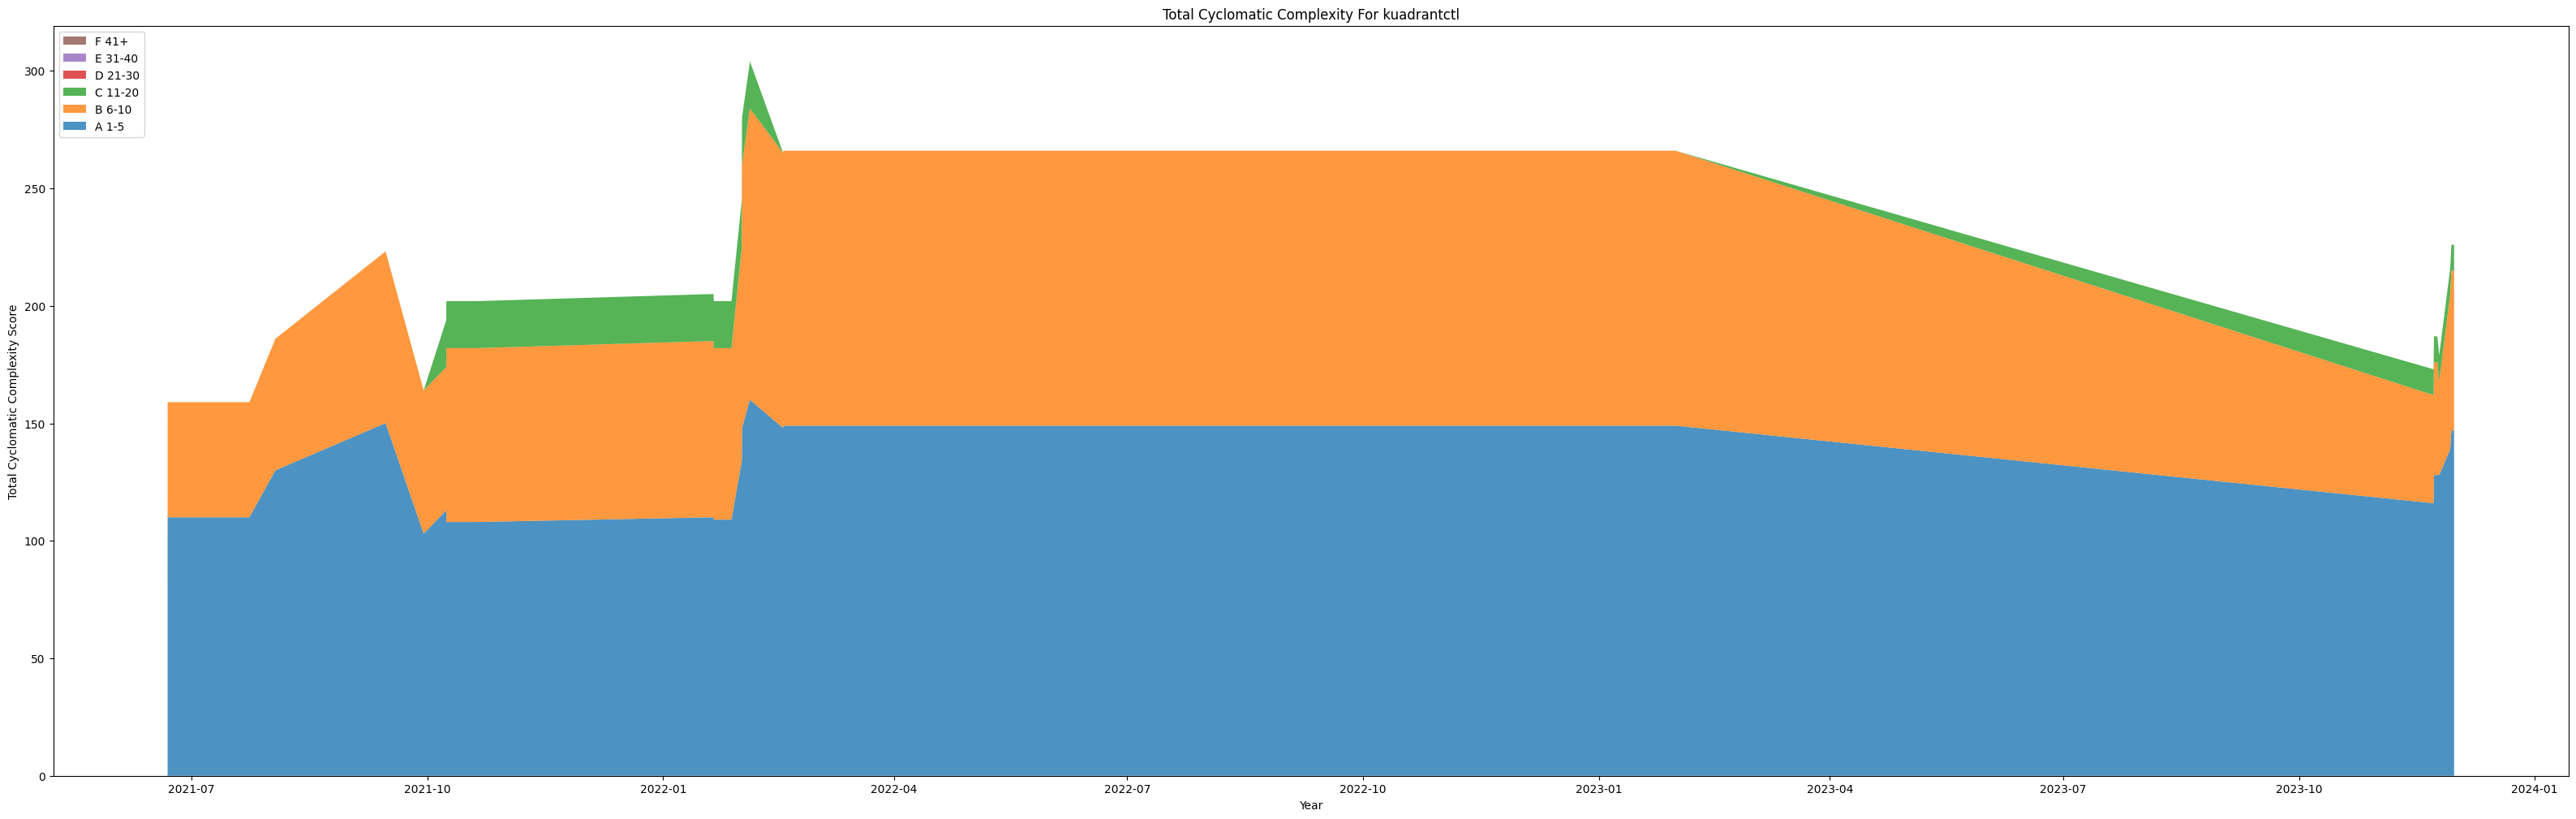

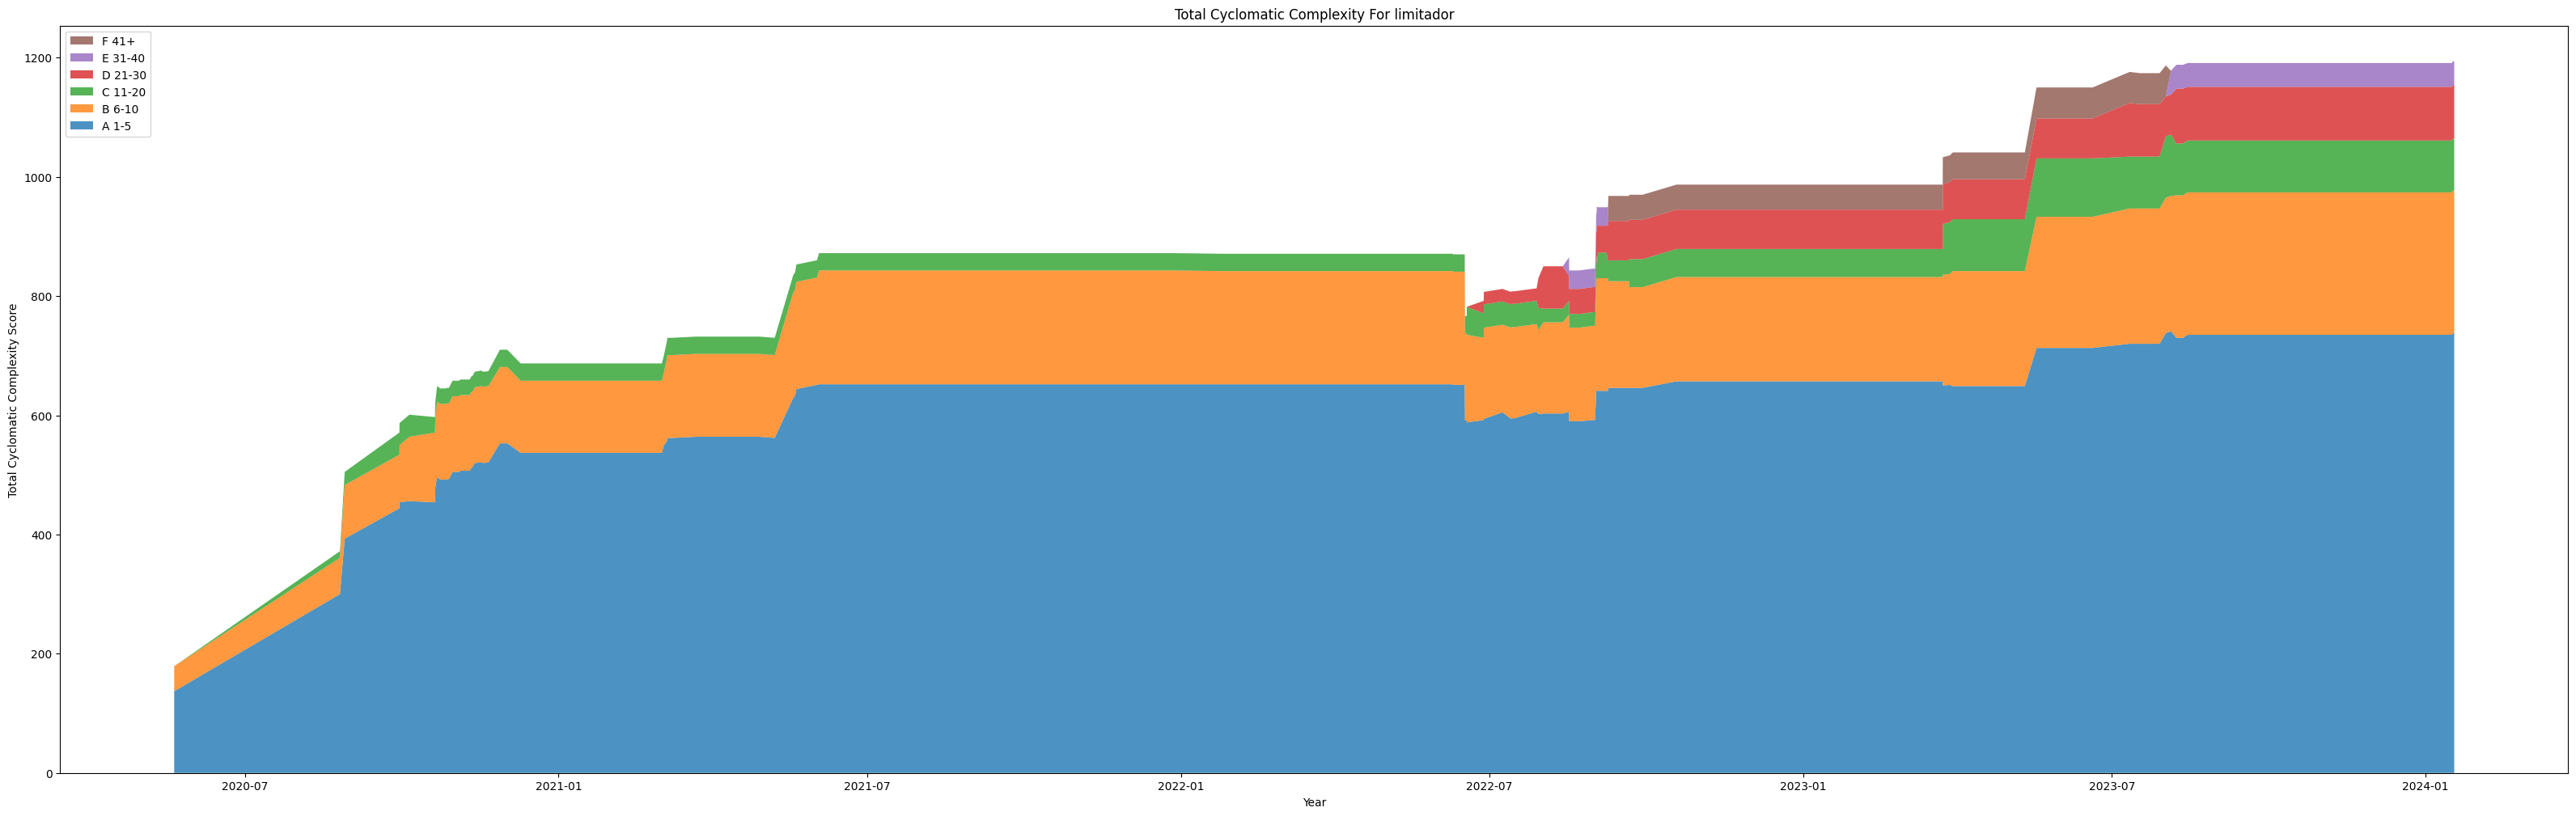

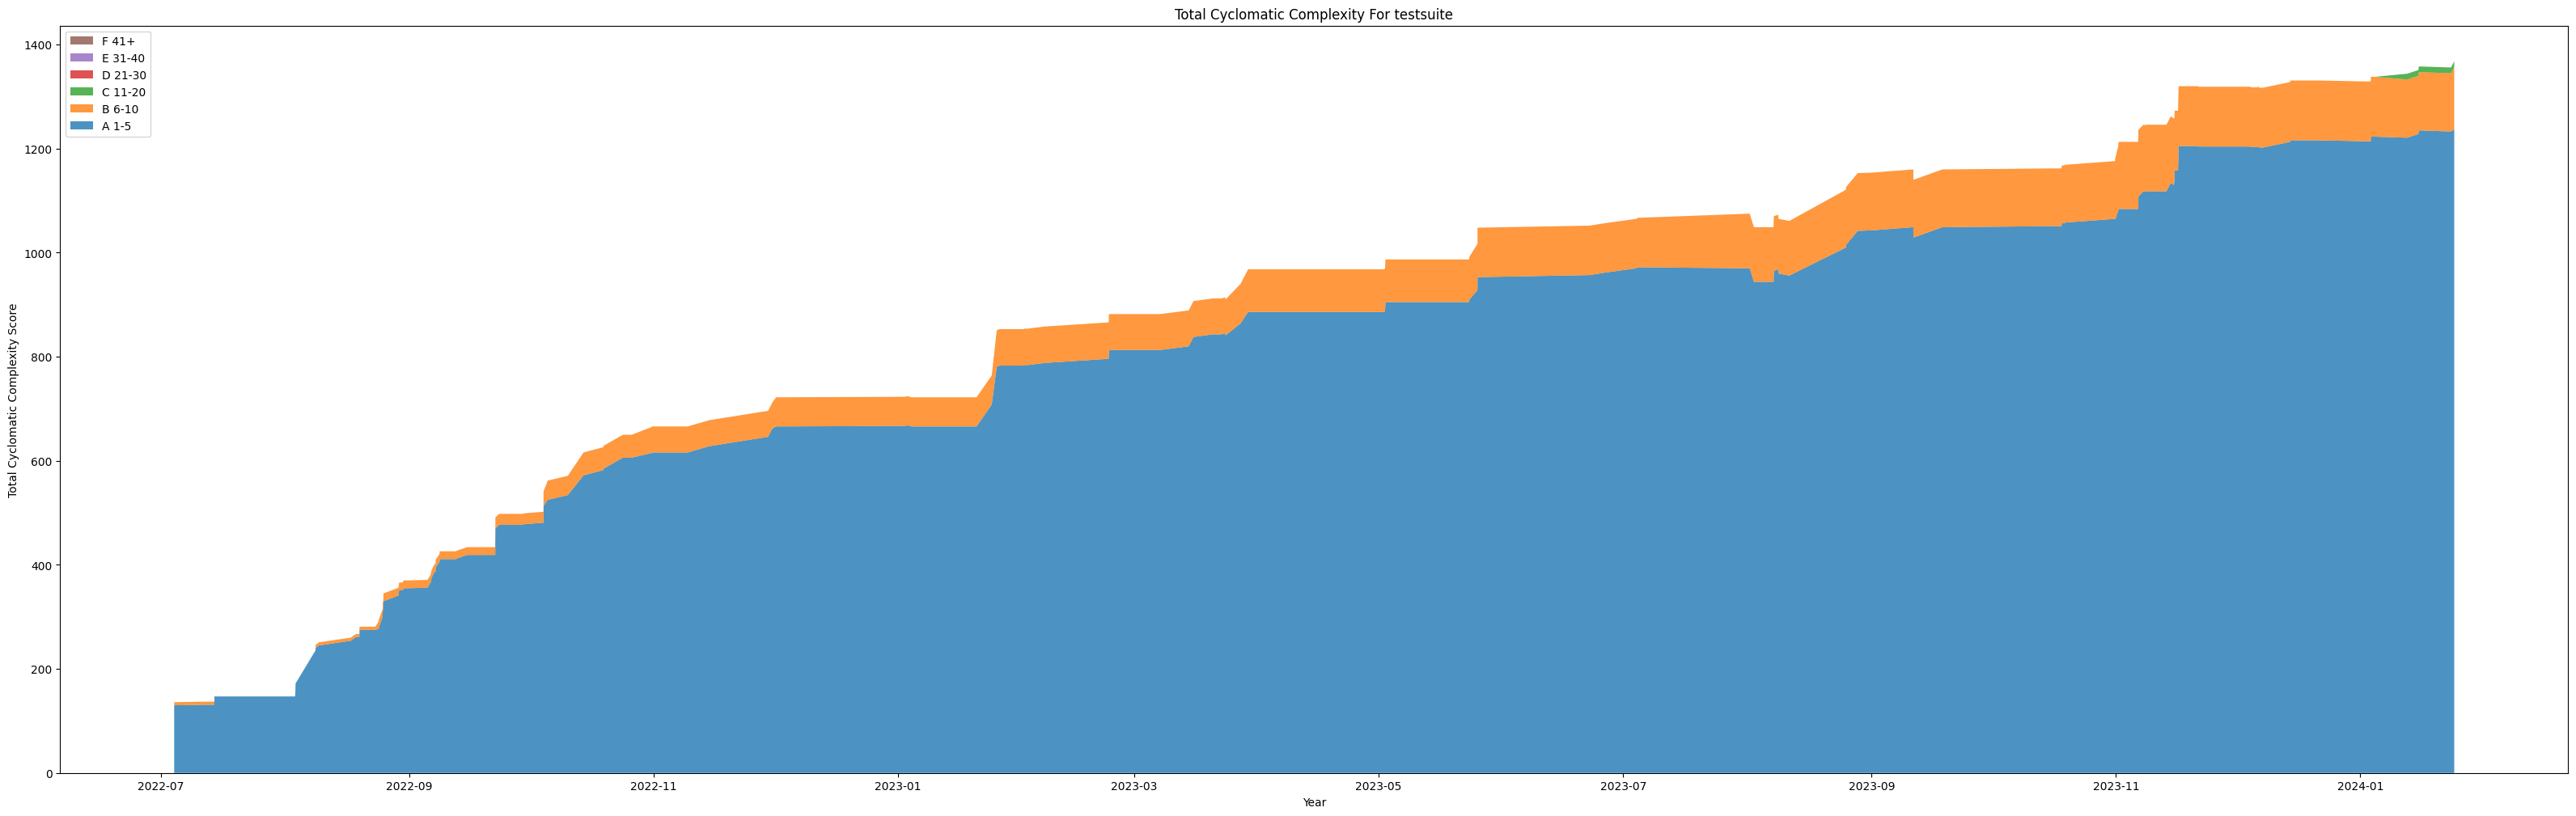

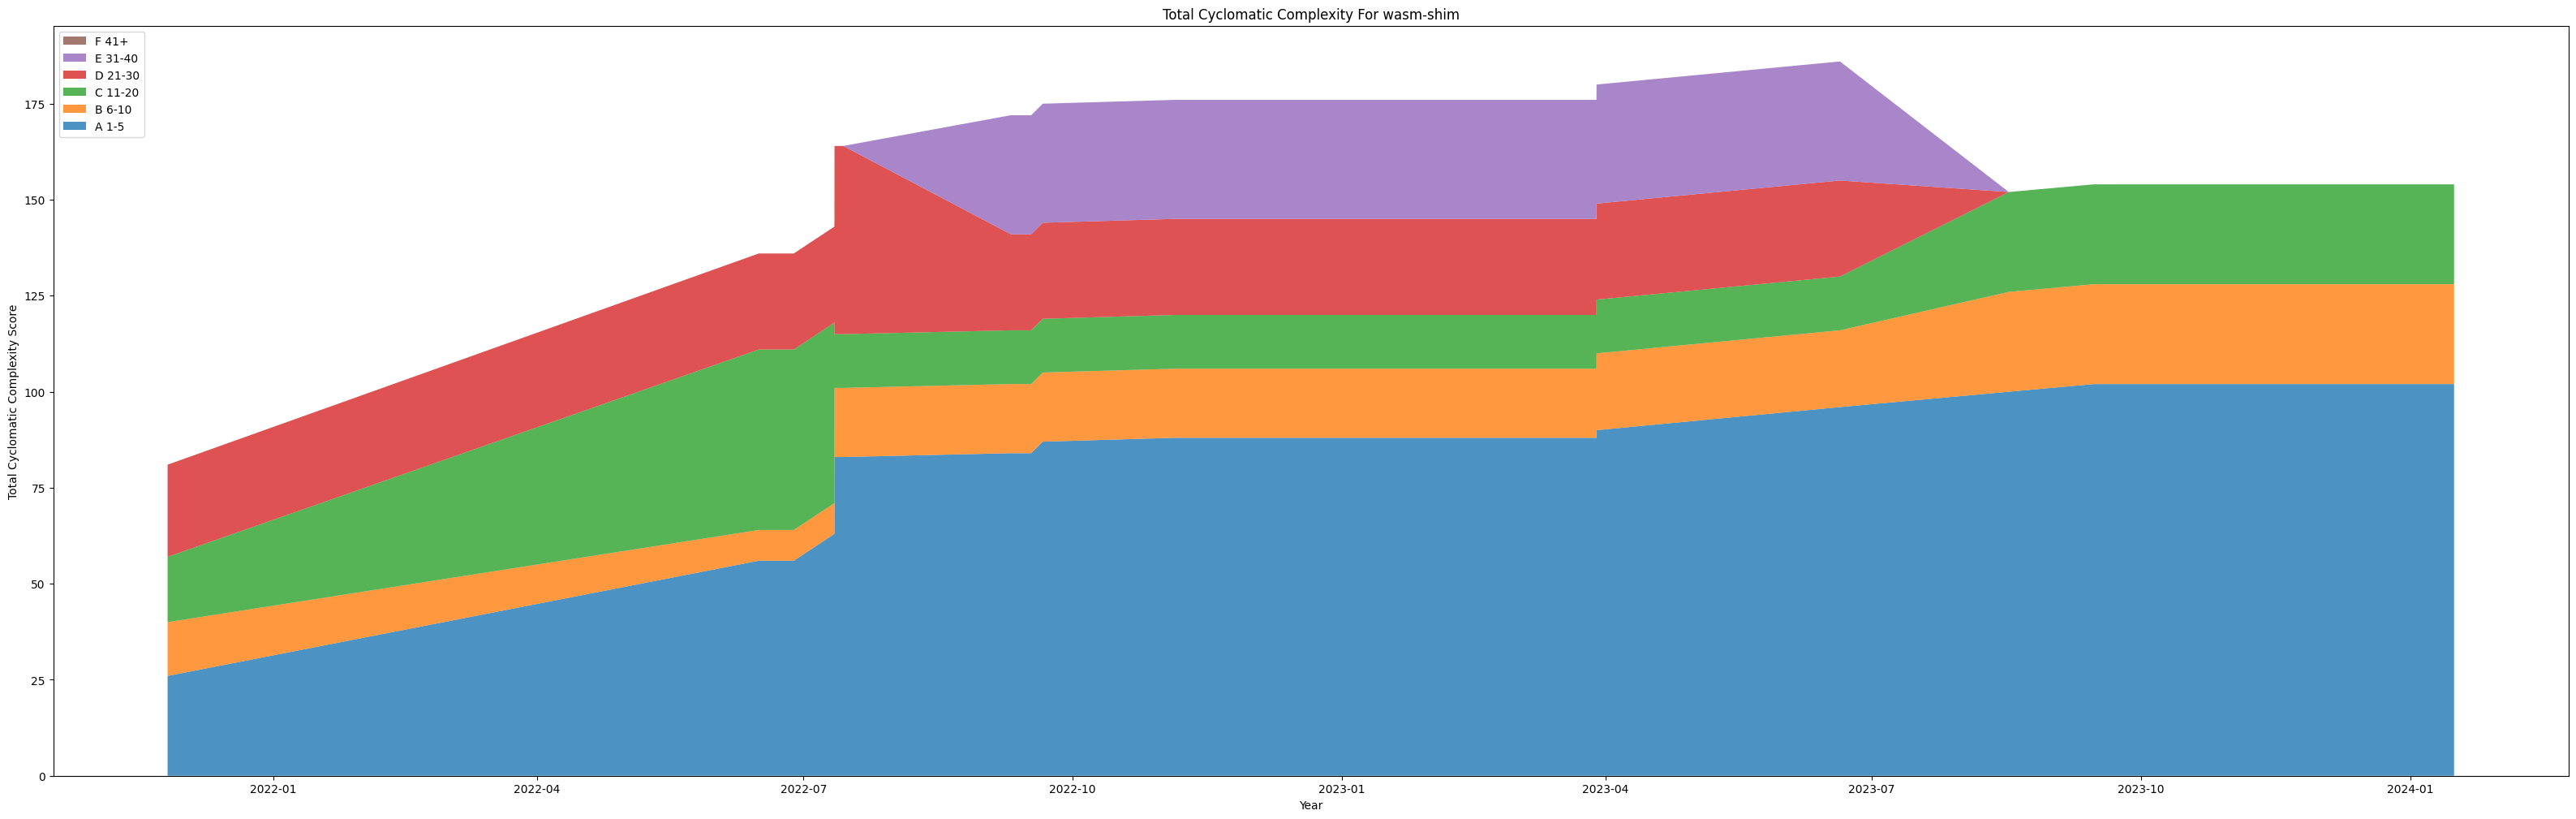

In [567]:
project_data = {}

for project in data:
    project_data[project] = {}
    for row in data[project]:
        if not bool(row['cc']):
            break
        tmp = {row['timestamp']: 0}
        counter = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0}
        result = categorised_cc(row['cc'])
        for r in result:
            counter[r] += result[r]
        project_data[project][row['timestamp']] = counter
        
    if not bool(project_data[project]):
        project_data.pop(project)
        
project_list = project_data.keys()
project_list = sorted(project_list)

keys = ["A 1-5", "B 6-10", "C 11-20", "D 21-30", "E 31-40", "F 41+"]
for idx, project in enumerate(project_list):

    fig, ax = plt.subplots(figsize=(40, 12))
    timestamp = []
    values = {}
    for entry in project_data[project]: 
        timestamp.append(datetime.strptime(entry, timestamp_format))
        for k in project_data[project][entry]:
            if k not in values:
                values.setdefault(k, [])
            values[k].append(project_data[project][entry][k]) 
            
    ax.stackplot(timestamp, values.values(), labels=keys, alpha=0.8)
    ax.set_title(f'Total Cyclomatic Complexity For {project}')
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(loc='upper left', reverse=True)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Cyclomatic Complexity Score')

plt.show()



# Percentage normalised

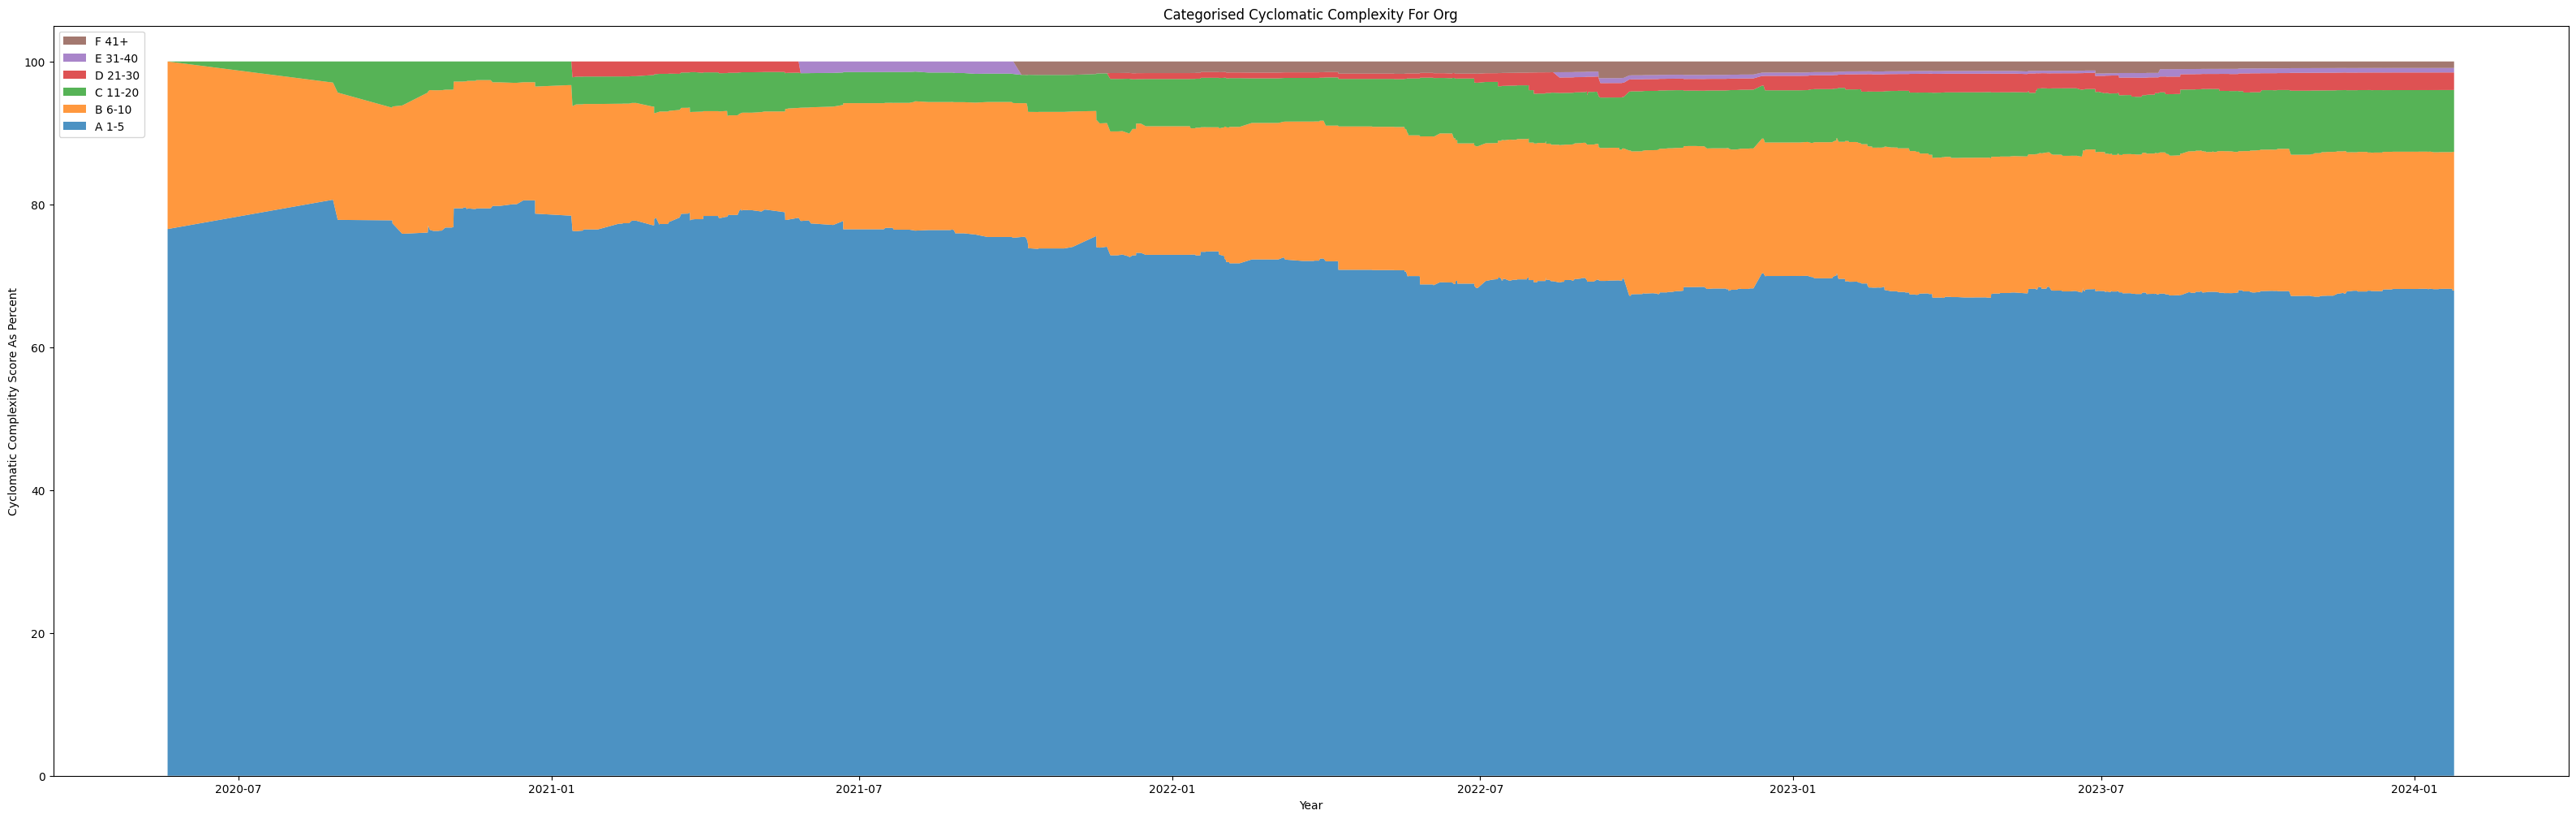

In [568]:
import matplotlib.pyplot as plt
from radon.complexity import cc_rank
def categorised_cc(dataset):
    total = {}
    for lang in dataset:
        for entry in dataset[lang]:
            rank = cc_rank(entry['score'])
            if rank not in total:
                total[rank] = 0
            total[rank] += entry['score']

    return total

categorised_cc_rows = get_row_set()
categorised_cc_results = []
for row in categorised_cc_rows:
    tmp = {row['timestamp']: 0}
    counter = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0}
    for key in row:
        if key == 'timestamp' or row[key] is None:
            continue

        commit = filter(lambda x: x['commit'] == row[key], data[key])
        commit = next(commit, None)
        if commit:
            result = categorised_cc(commit['cc'])
            for r in result:
                counter[r] += result[r]

    total = sum(counter.values())
    for key in counter:
        counter[key] = counter[key] / total * 100
    categorised_cc_results.append({row['timestamp']: counter})

timestamp = []
values = {}
for entry in categorised_cc_results:
    for key in entry:
        timestamp.append(key)
        for k in entry[key]:
            if k not in values:
                values.setdefault(k, [])
            values[k].append(entry[key][k])

keys = ["A 1-5", "B 6-10", "C 11-20", "D 21-30", "E 31-40", "F 41+"]

fig, ax = plt.subplots(figsize=(40, 12))

ax.stackplot(timestamp, values.values(),
             labels=keys, alpha=0.8)
ax.legend(loc='upper left', reverse=True)
ax.set_title('Categorised Cyclomatic Complexity For Org')
ax.set_xlabel('Year')
ax.set_ylabel('Cyclomatic Complexity Score As Percent')


plt.show()


## Percent Per Project

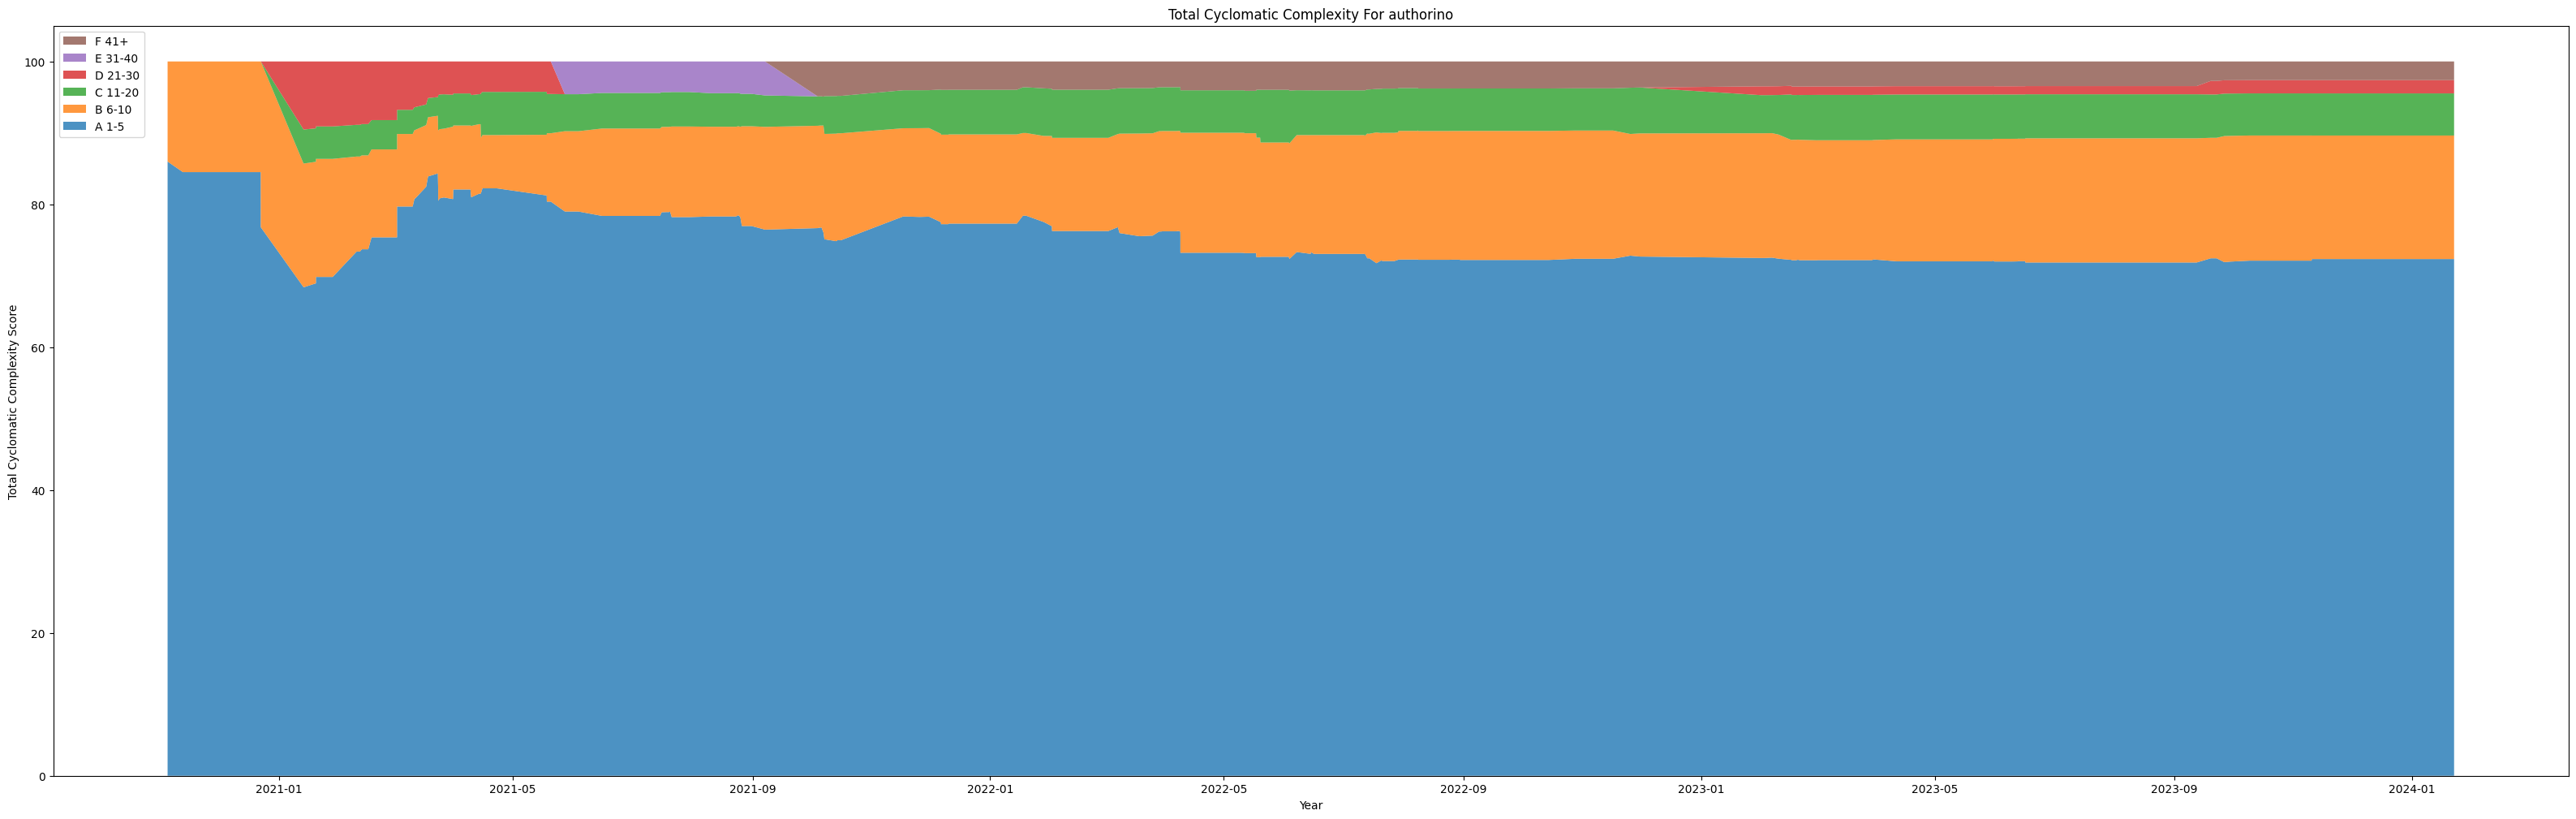

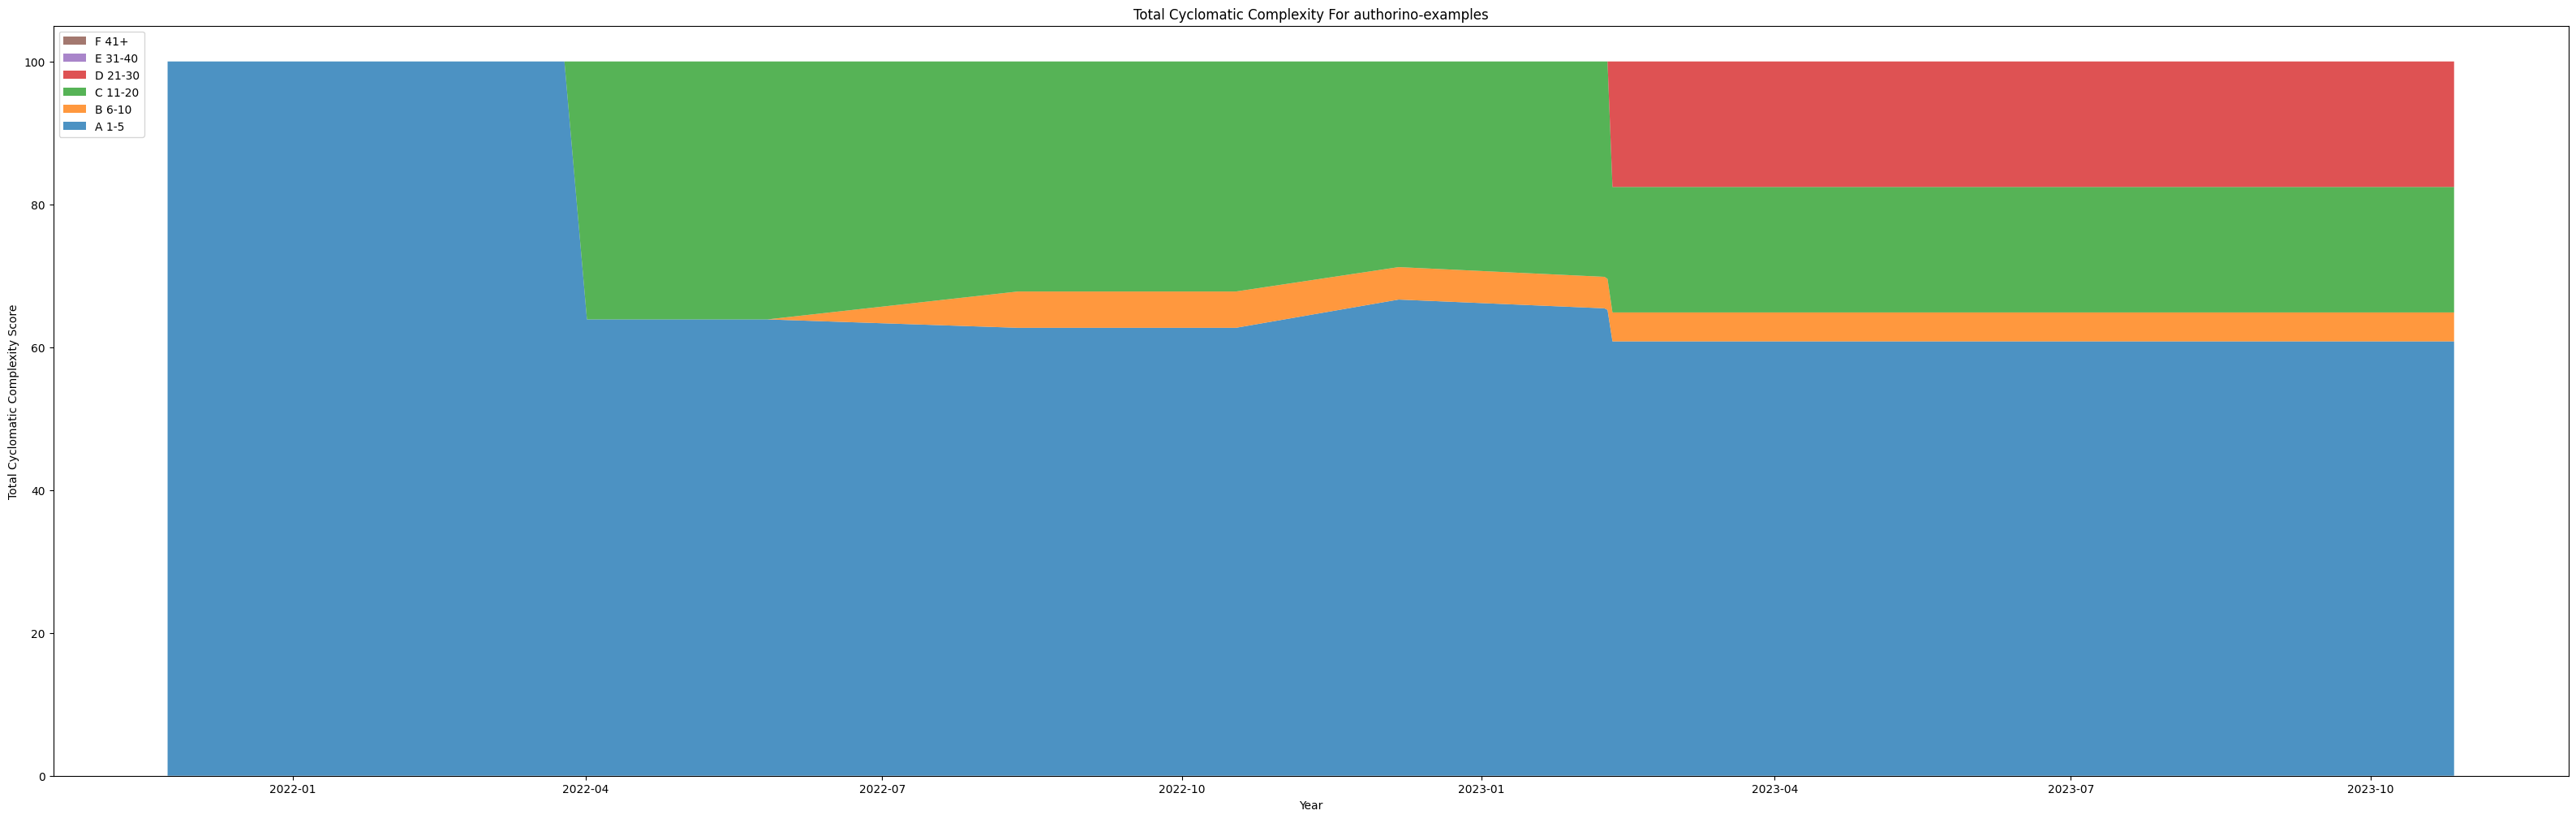

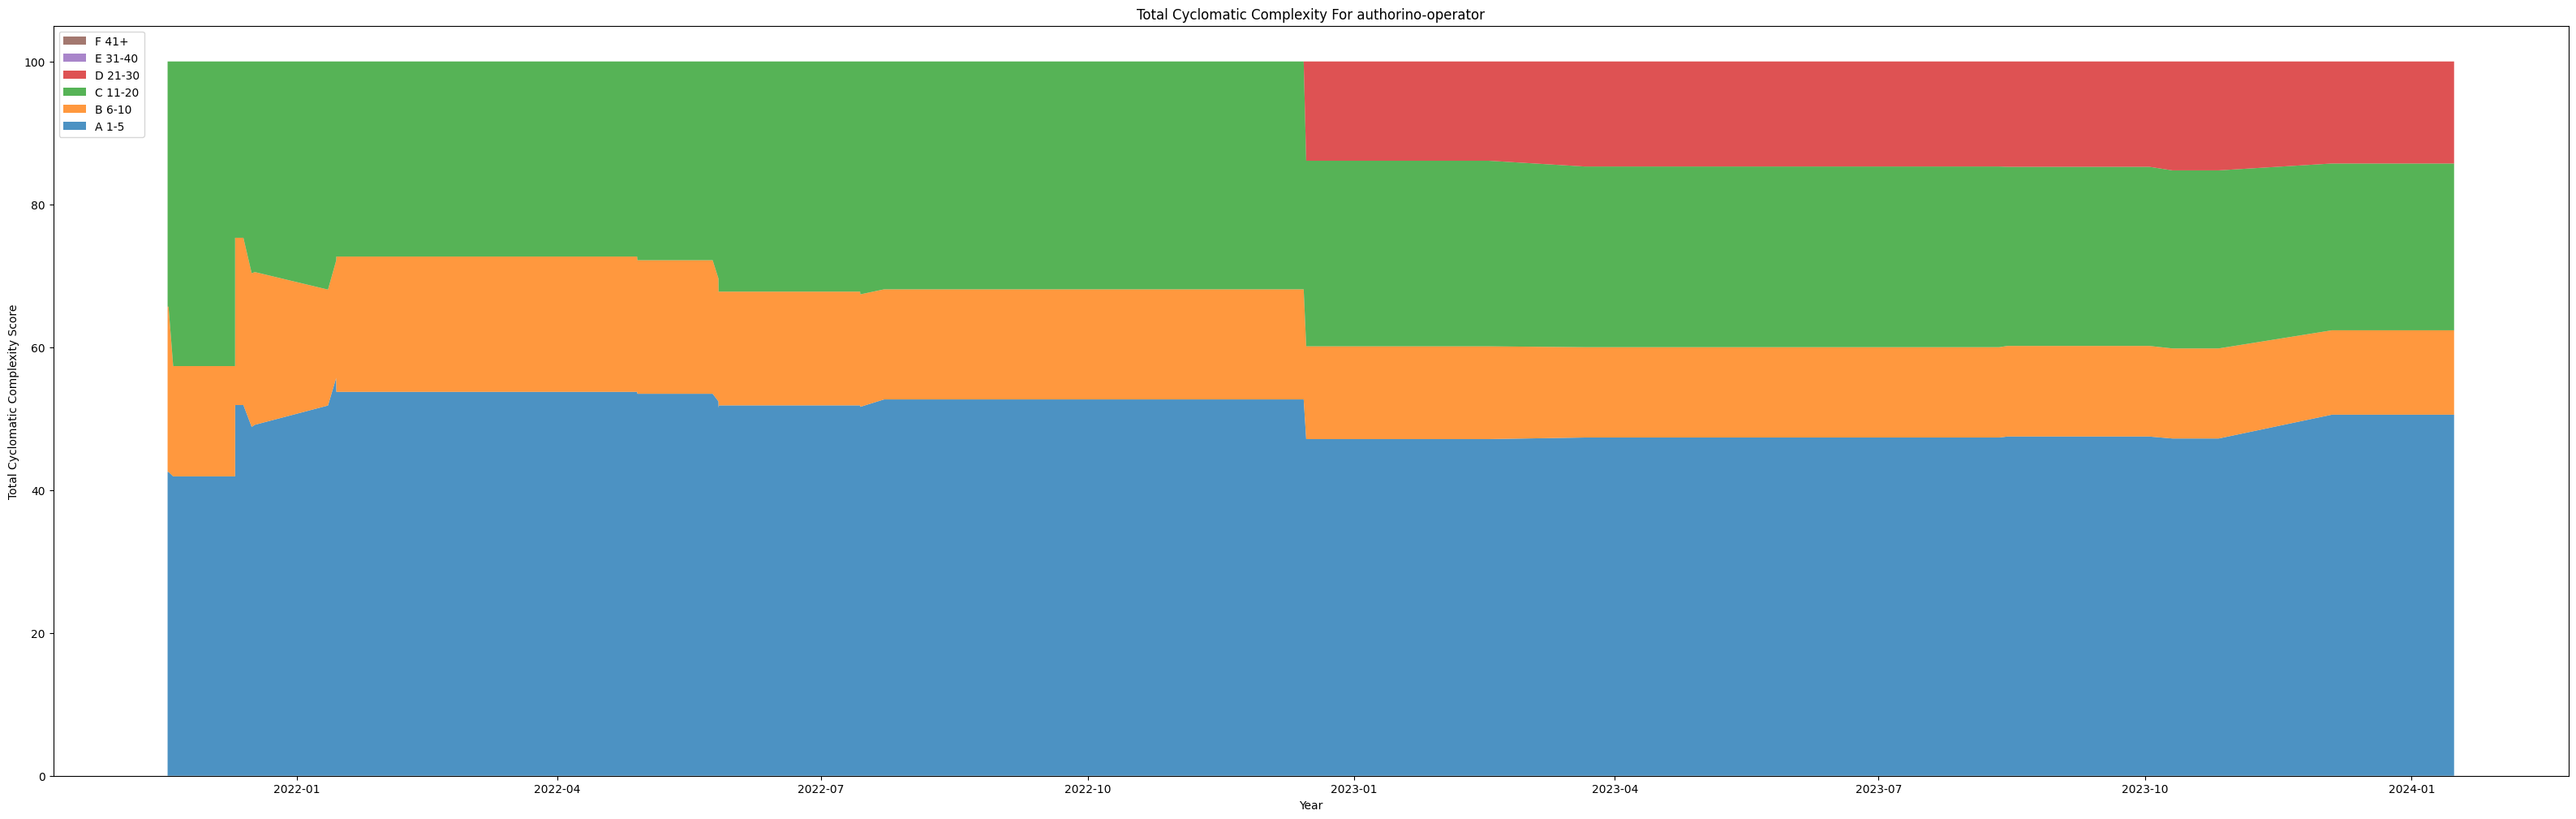

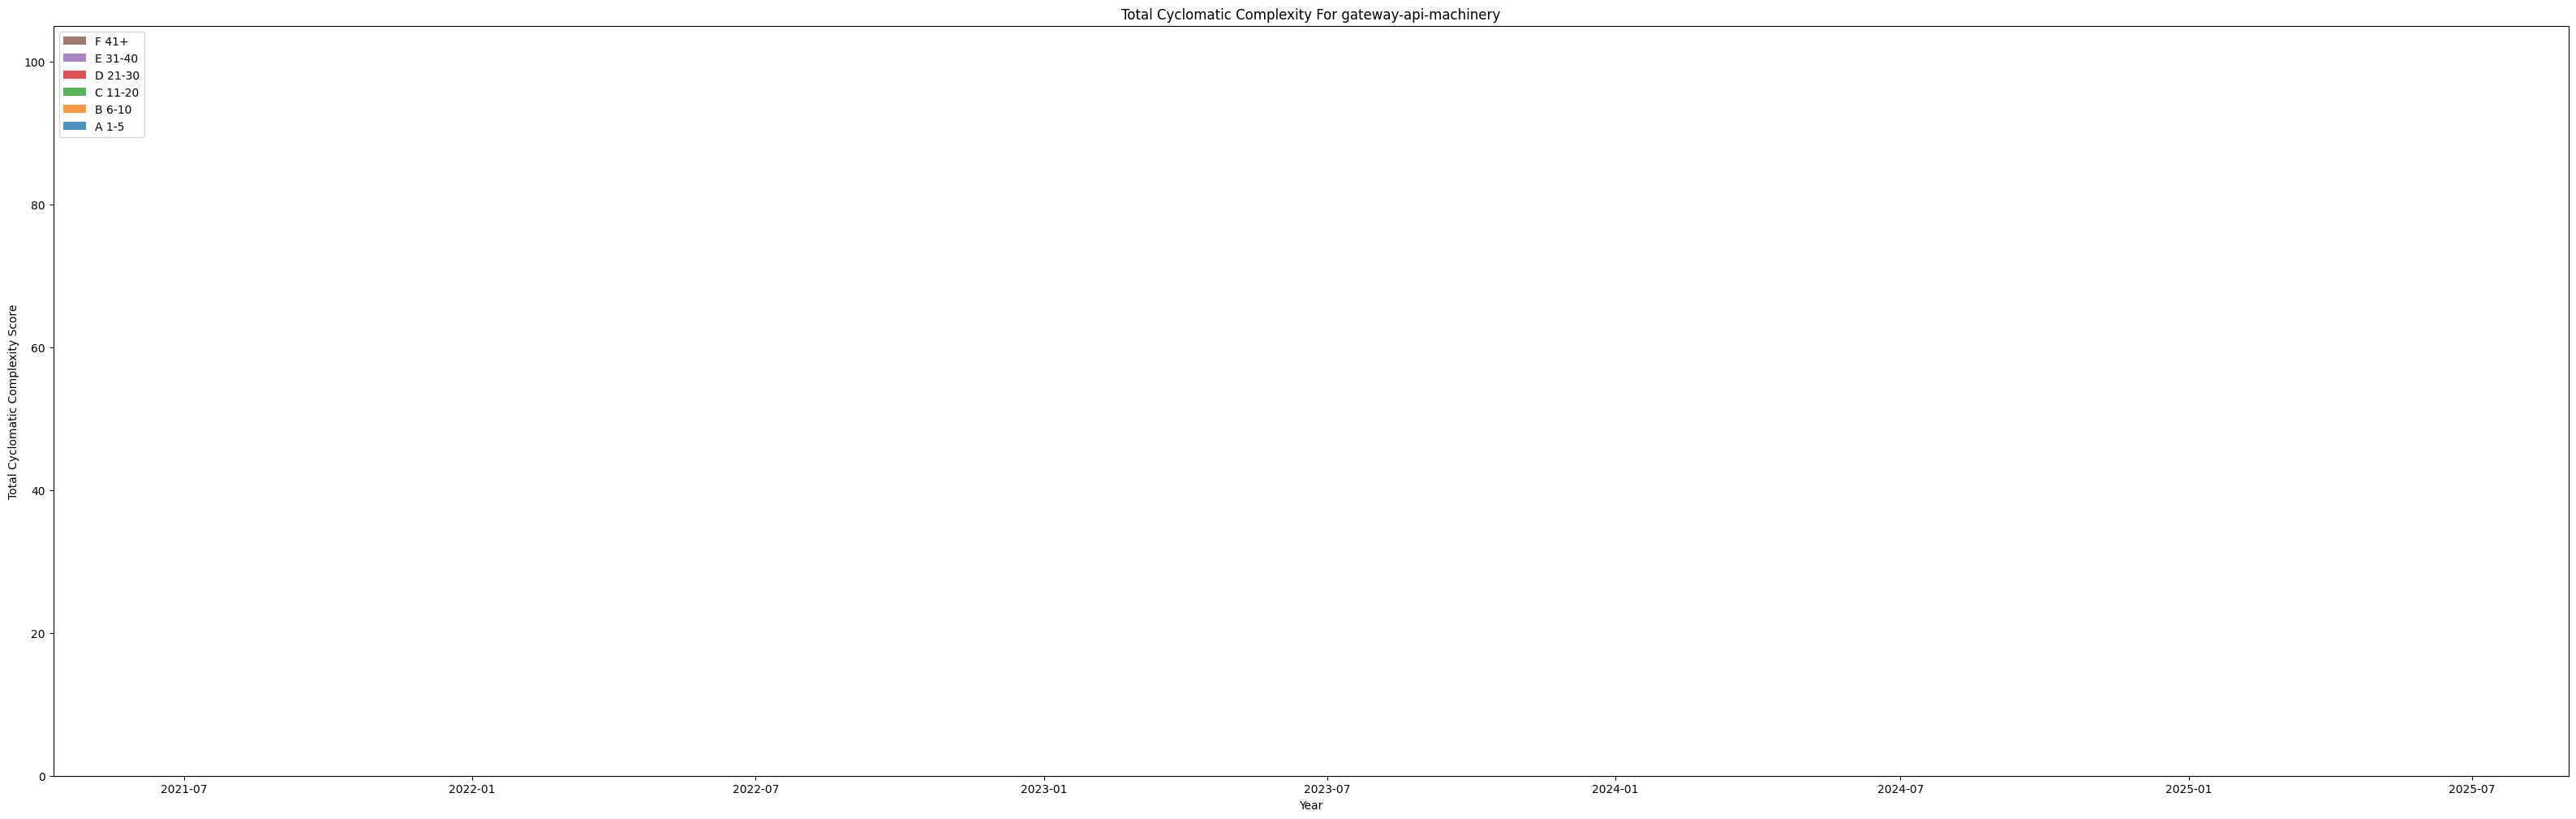

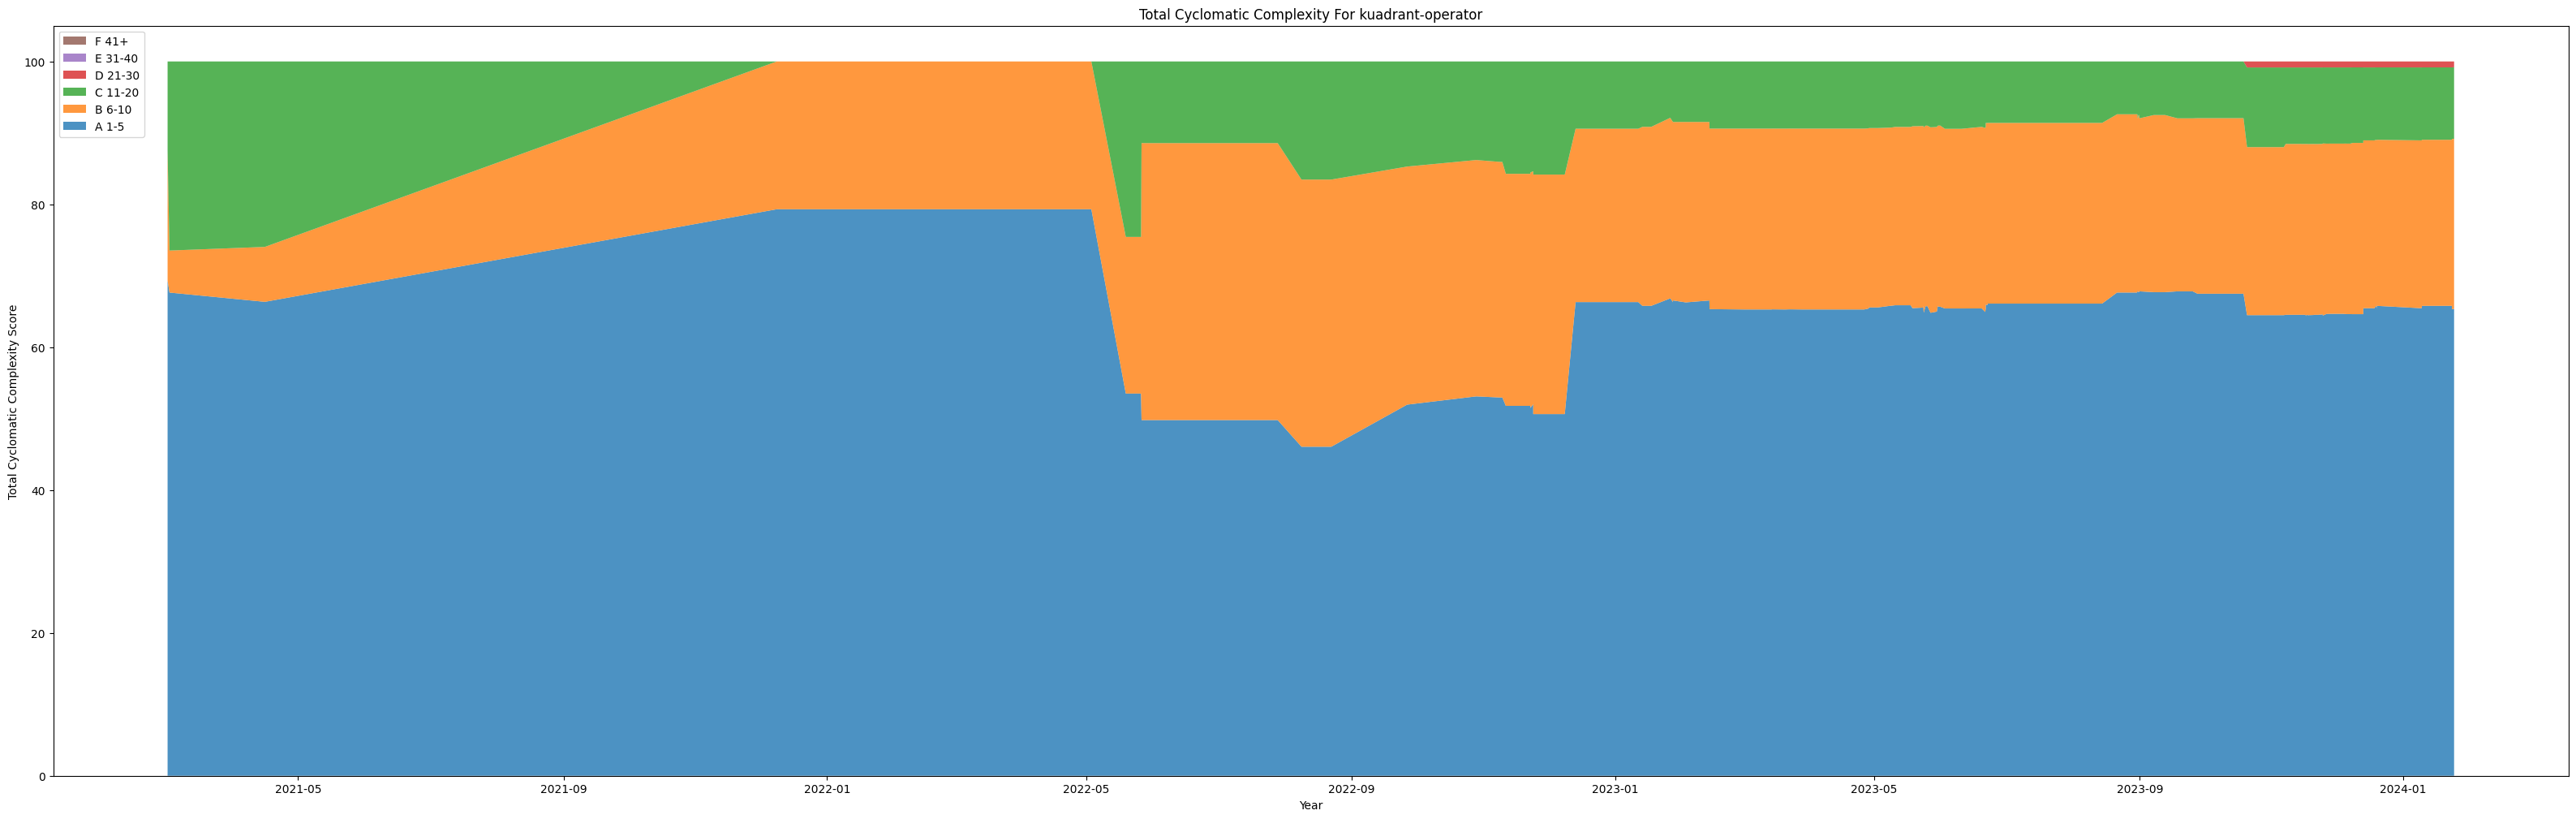

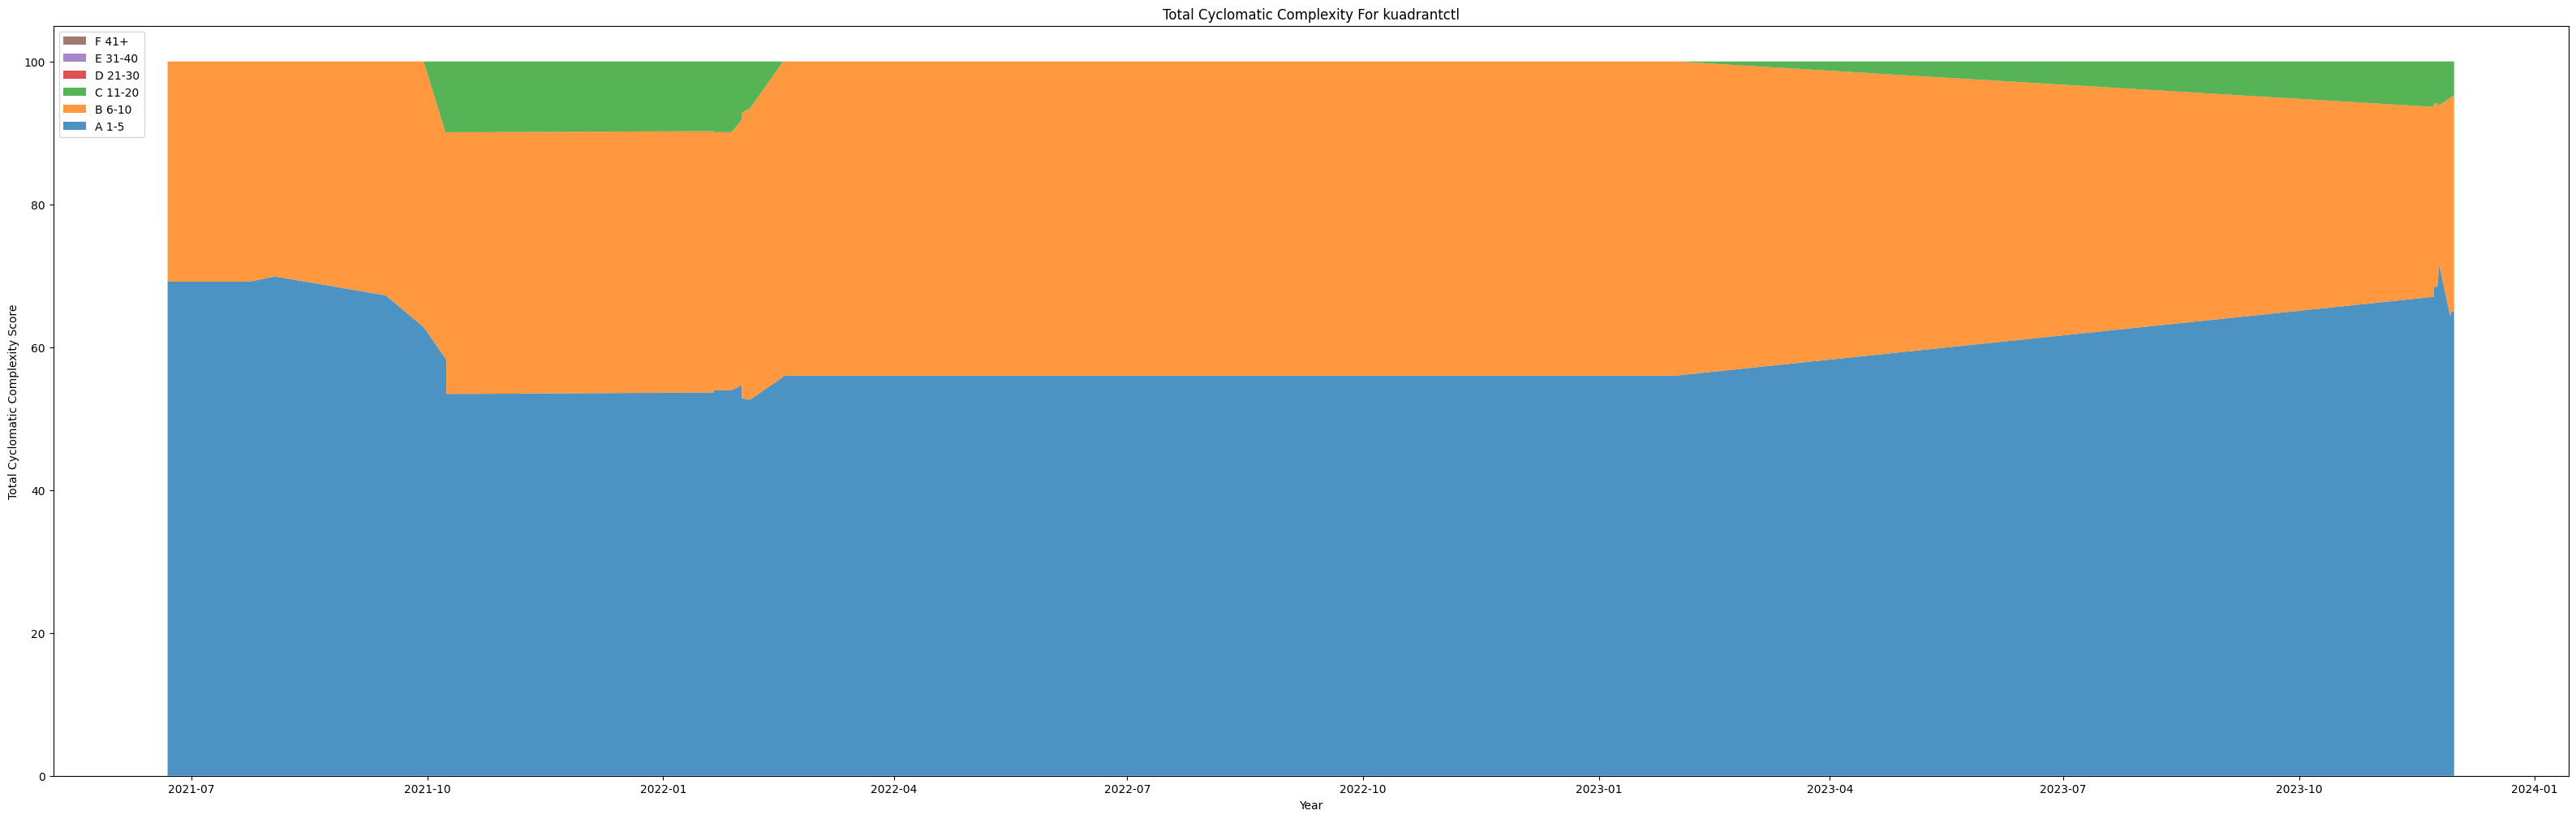

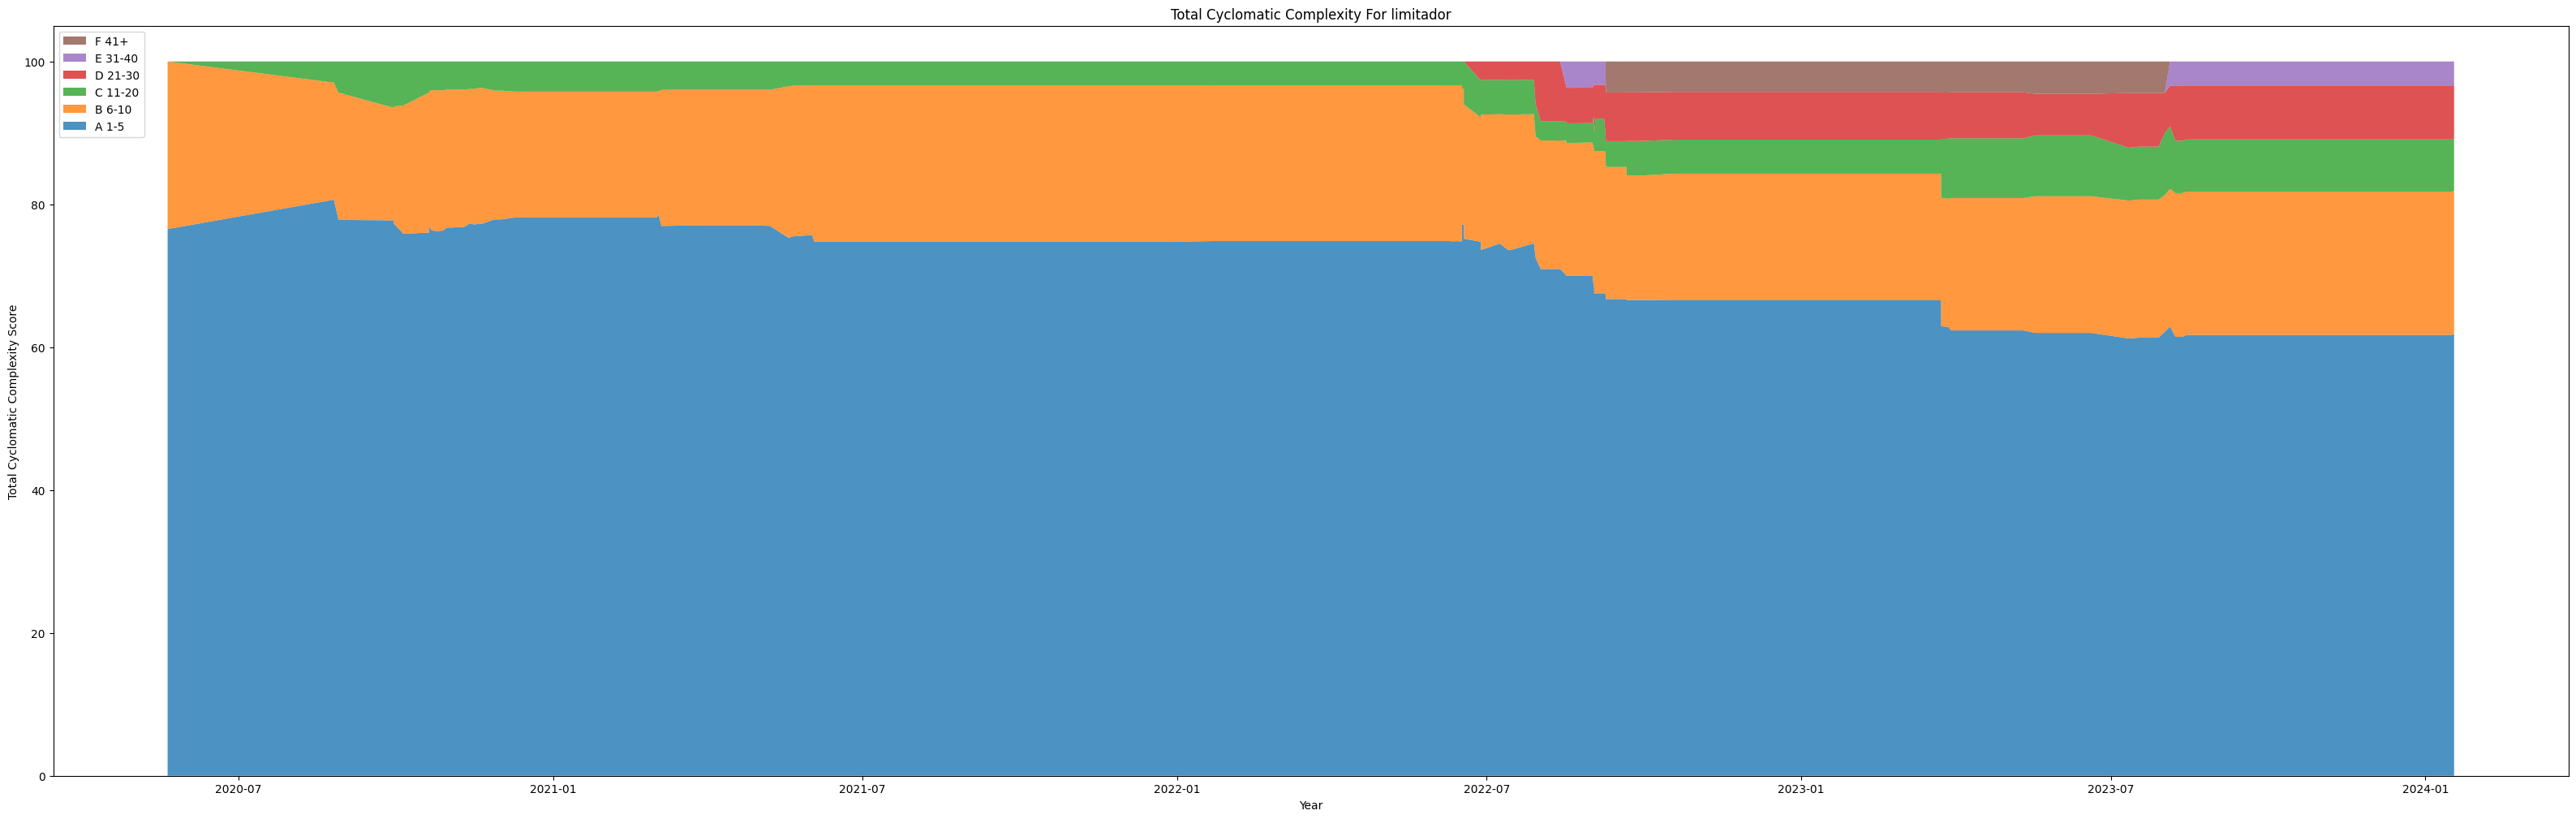

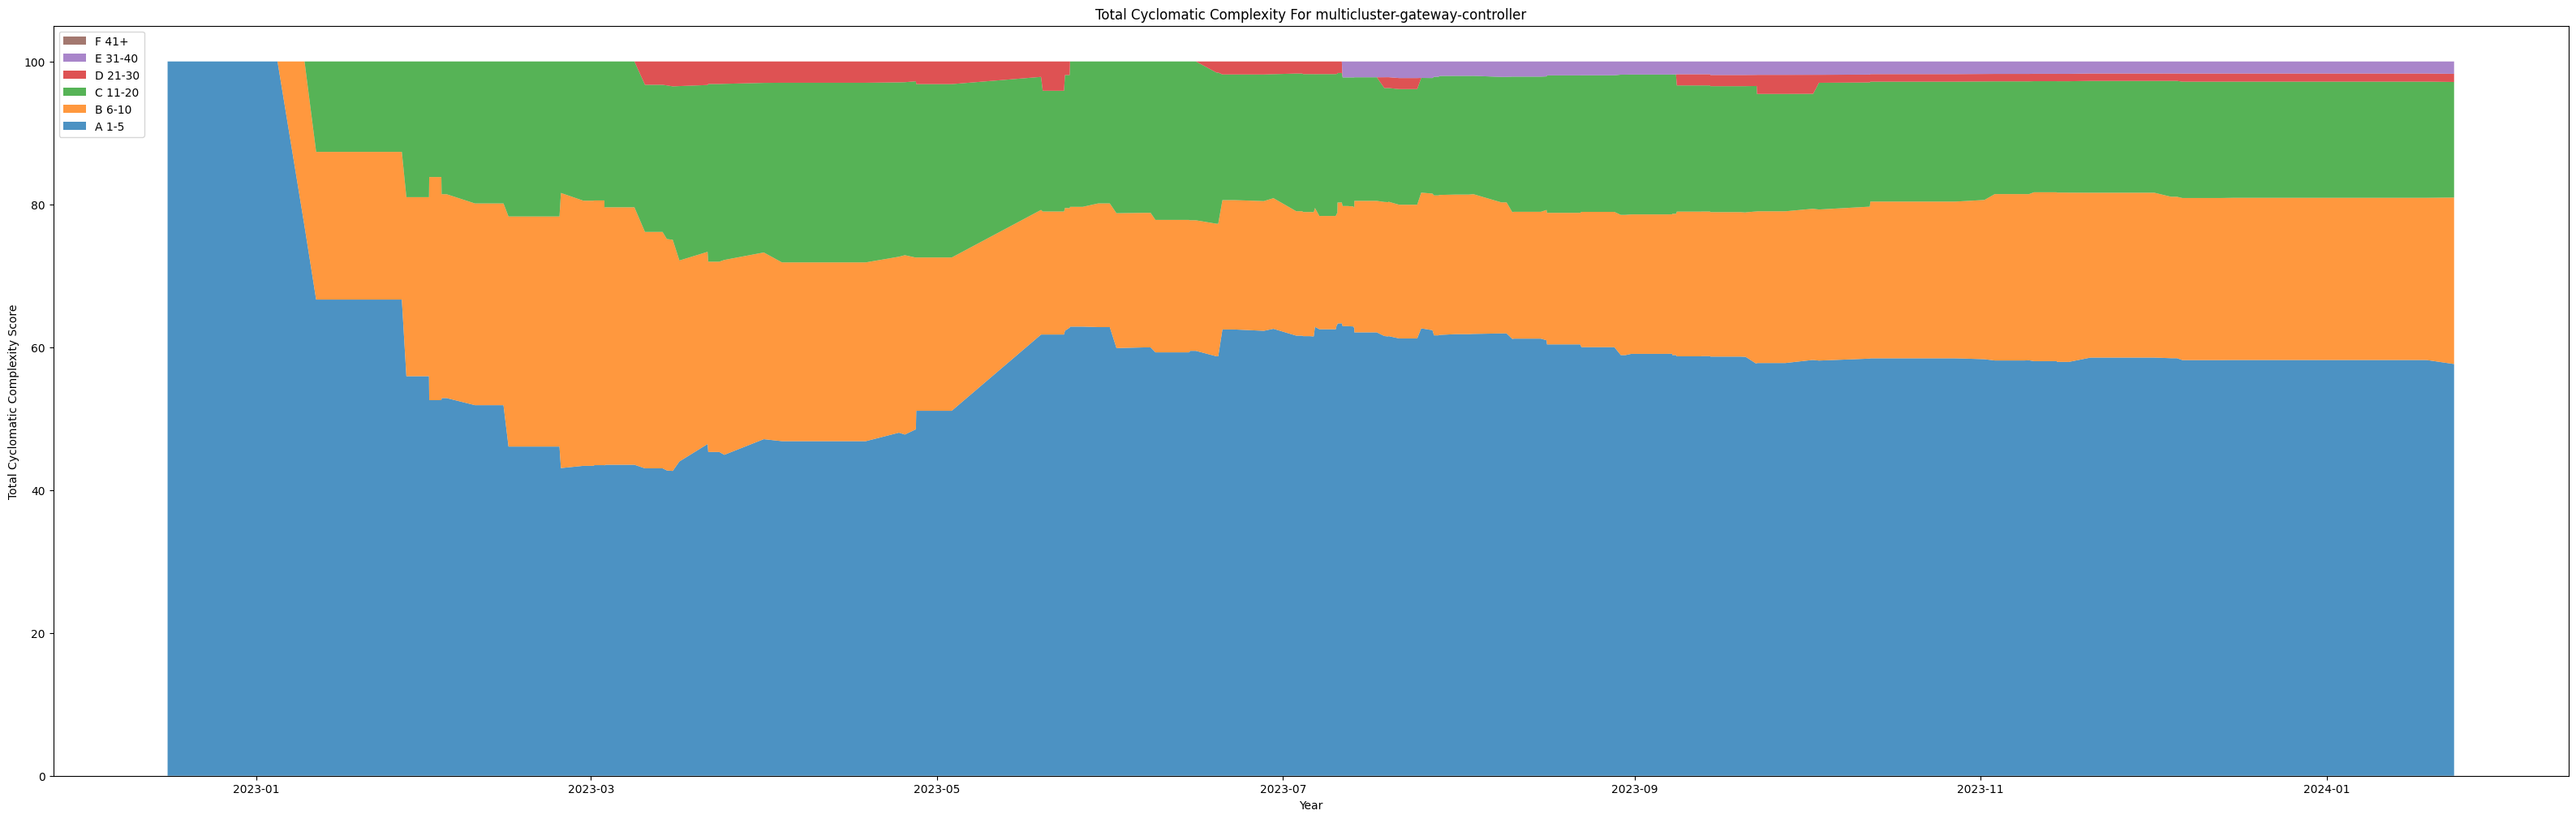

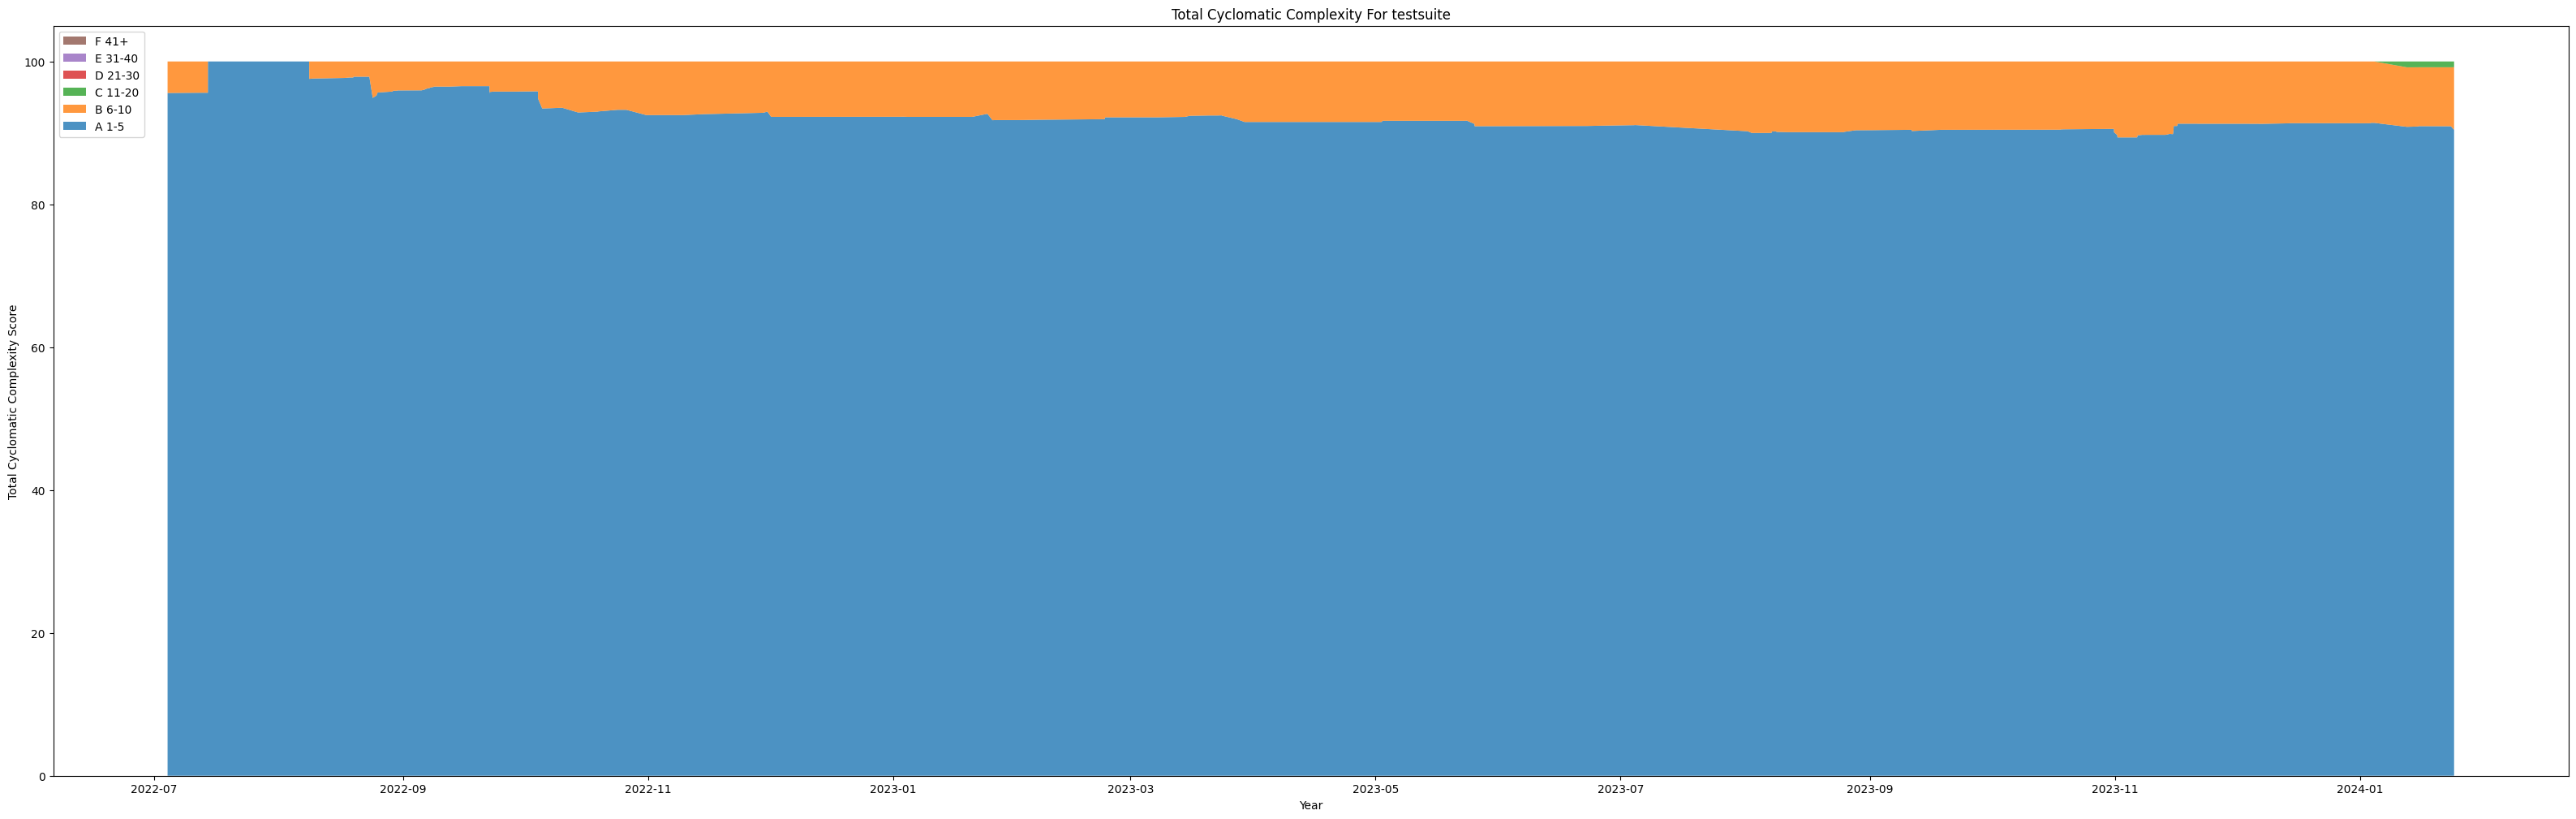

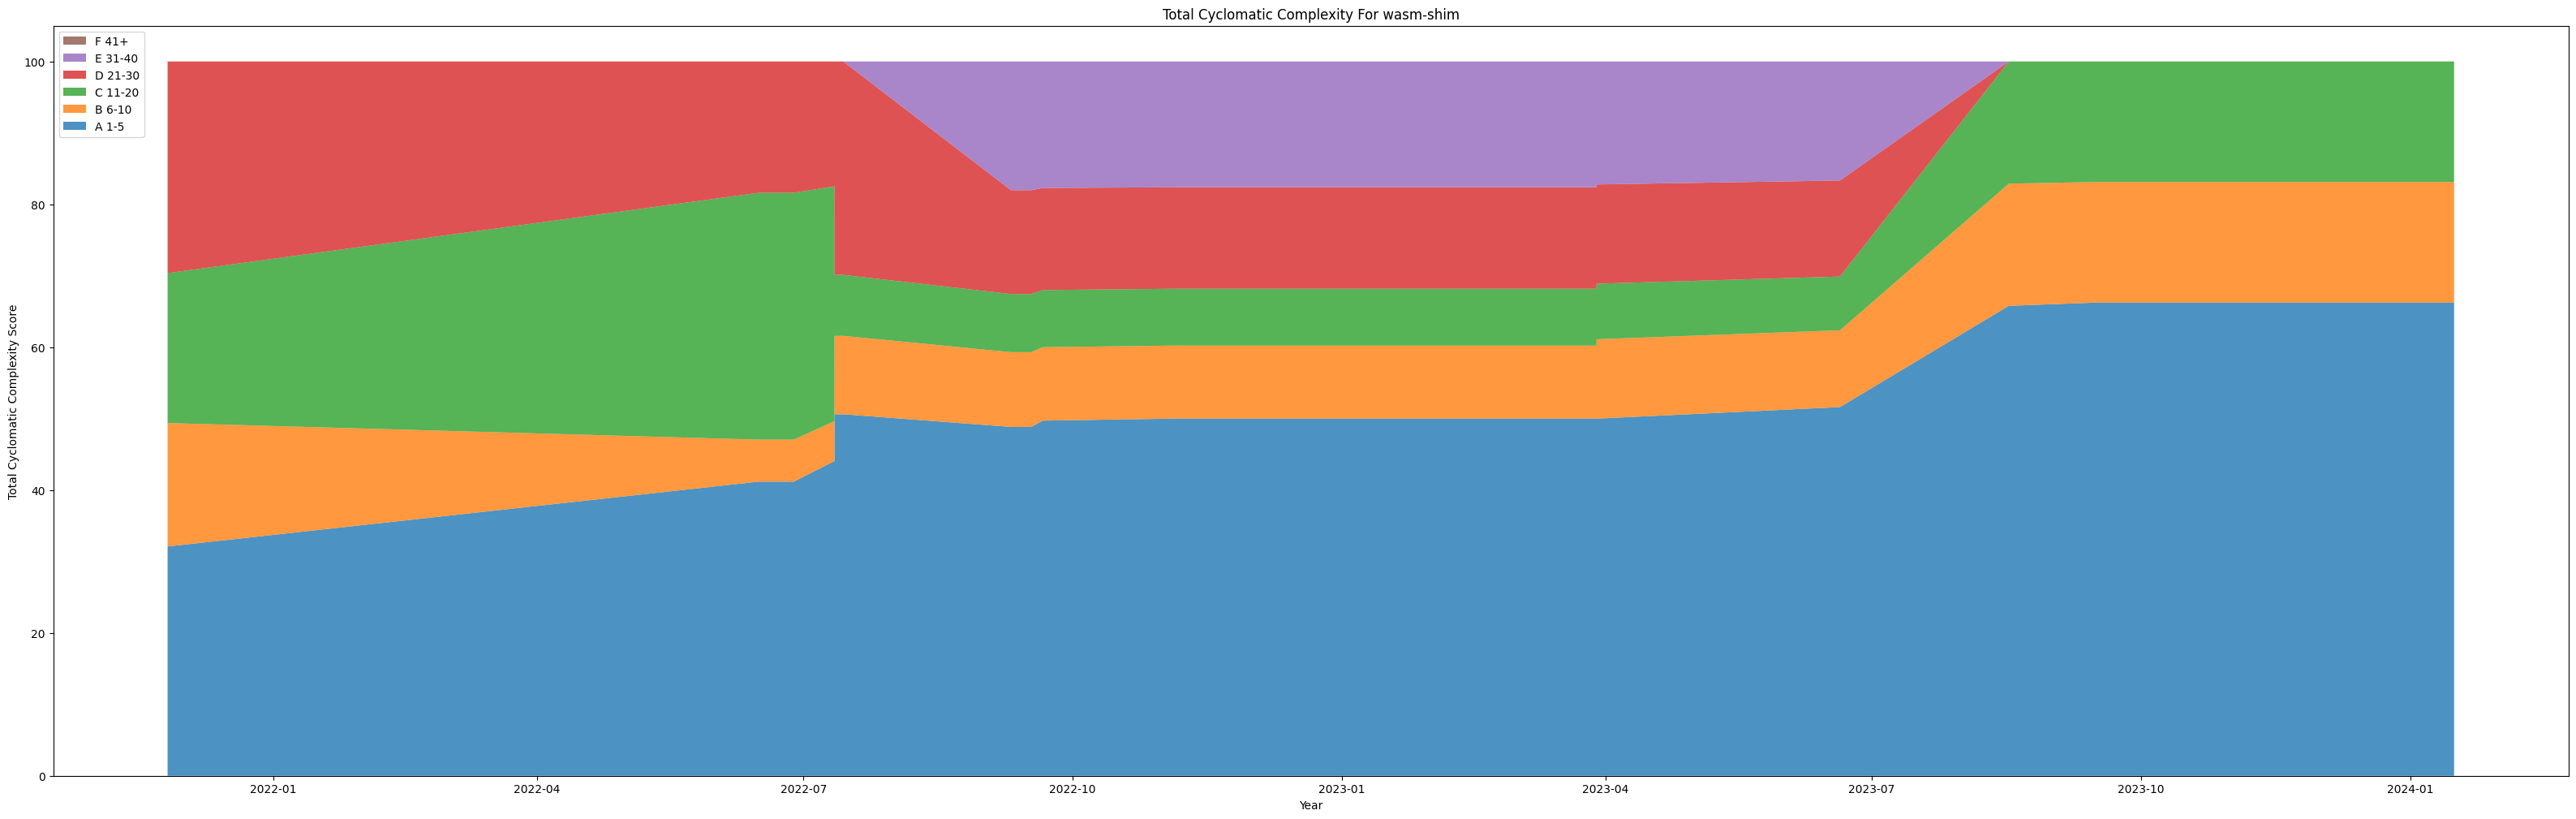

In [569]:
project_data = {}

for project in data:
    project_data[project] = {}
    for row in data[project]:
        if not bool(row['cc']):
            break
        tmp = {row['timestamp']: 0}
        counter = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0}
        result = categorised_cc(row['cc'])
        for r in result:
            counter[r] += result[r]
        total = sum(counter.values())
        for key in counter:
            counter[key] = counter[key] / total * 100
        project_data[project][row['timestamp']] = counter

    if not bool(project_data[project]):
        project_data.pop(project)

project_list = project_data.keys()
project_list = sorted(project_list)

keys = ["A 1-5", "B 6-10", "C 11-20", "D 21-30", "E 31-40", "F 41+"]
for idx, project in enumerate(project_list):

    fig, ax = plt.subplots(figsize=(40, 12))
    timestamp = []
    values = {}
    for entry in project_data[project]:
        timestamp.append(datetime.strptime(entry, timestamp_format))
        for k in project_data[project][entry]:
            if k not in values:
                values.setdefault(k, [])
            values[k].append(project_data[project][entry][k])

    ax.stackplot(timestamp, values.values(), labels=keys, alpha=0.8)
    ax.set_title(f'Total Cyclomatic Complexity For {project}')
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(loc='upper left', reverse=True)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Cyclomatic Complexity Score')

plt.show()




# Number of functions Per Rank

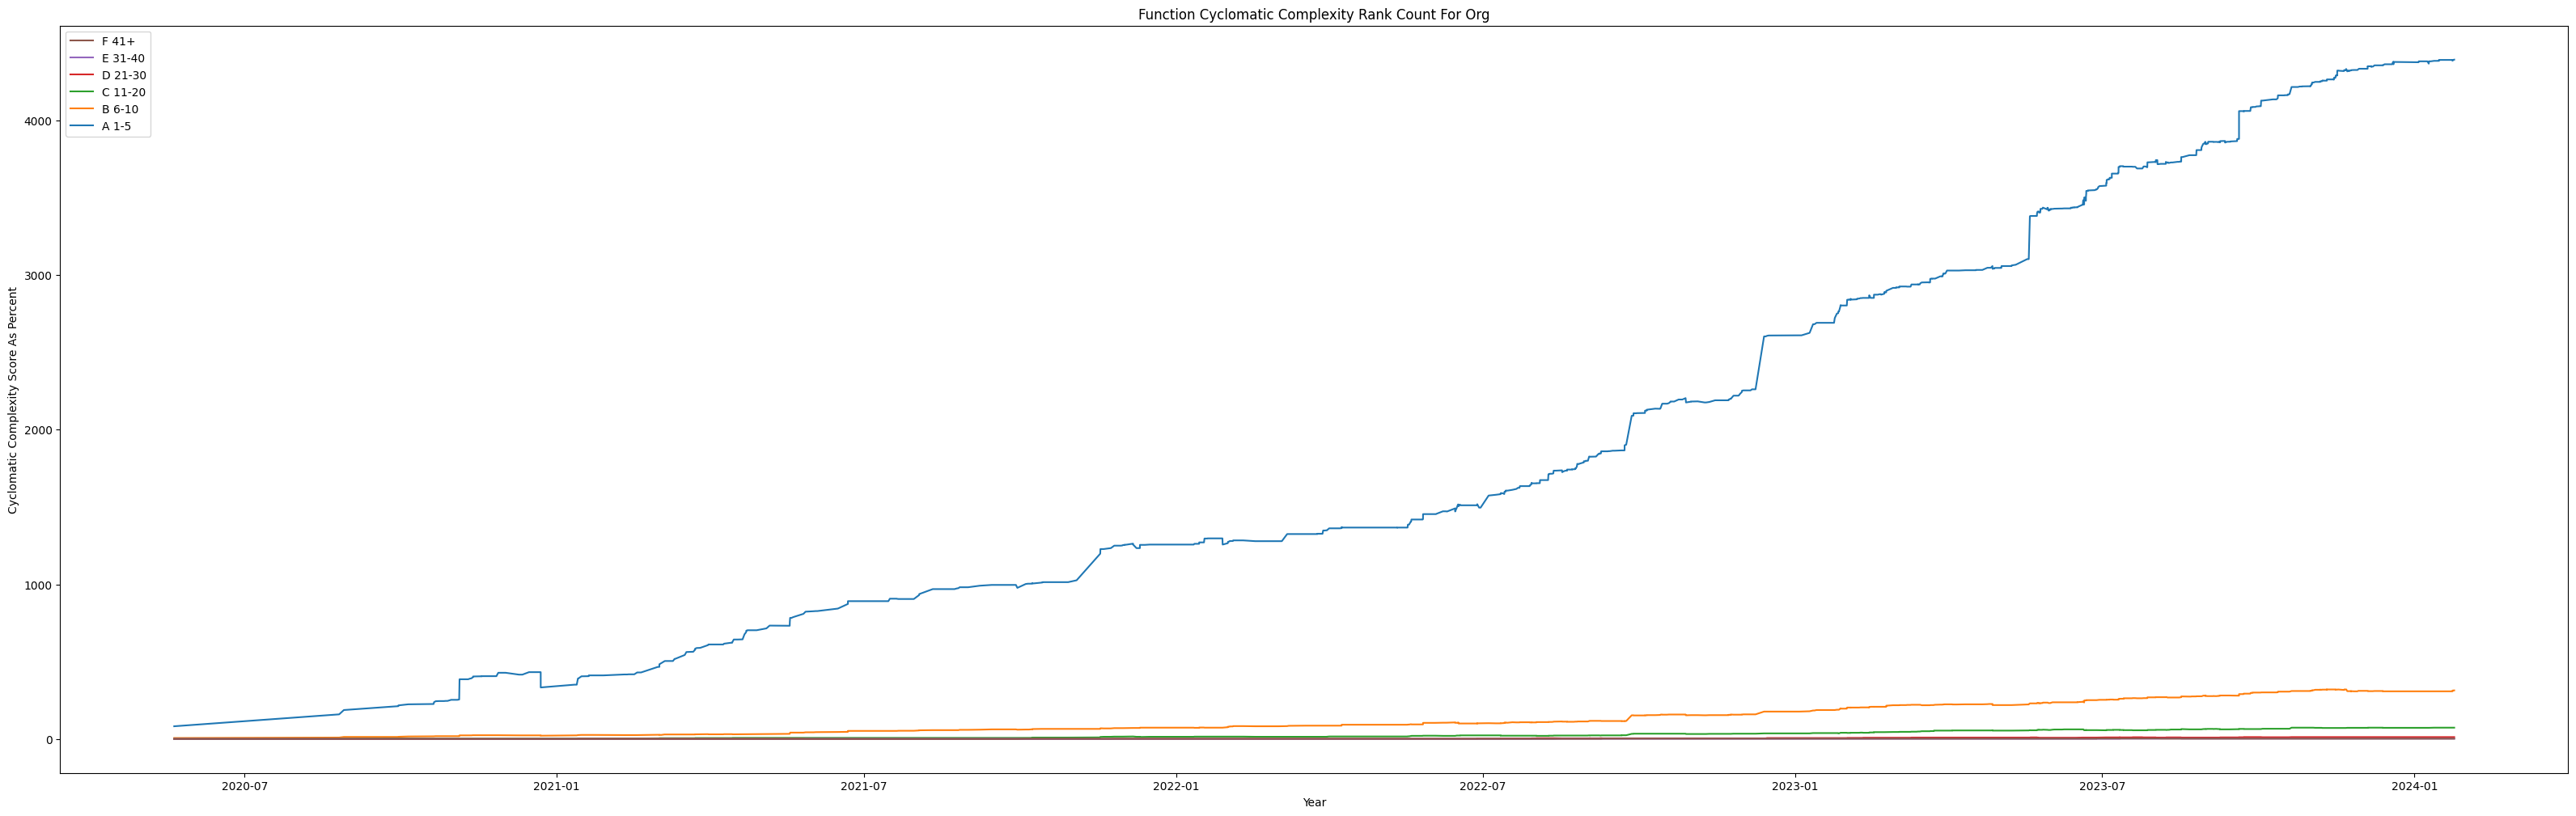

In [570]:
import matplotlib.pyplot as plt
from radon.complexity import cc_rank
def categorised_cc_func_count(dataset):
    total = {}
    for lang in dataset:
        for entry in dataset[lang]:
            rank = cc_rank(entry['score'])
            if rank not in total:
                total[rank] = 0
            total[rank] += 1

    return total

categorised_cc_rows = get_row_set()
categorised_cc_results = []
for row in categorised_cc_rows:
    tmp = {row['timestamp']: 0}
    counter = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0}
    for key in row:
        if key == 'timestamp' or row[key] is None:
            continue

        commit = filter(lambda x: x['commit'] == row[key], data[key])
        commit = next(commit, None)
        if commit:
            result = categorised_cc_func_count(commit['cc'])
            for r in result:
                counter[r] += result[r]

    categorised_cc_results.append({row['timestamp']: counter})

timestamp = []
values = {}
for entry in categorised_cc_results:
    for key in entry:
        timestamp.append(key)
        for k in entry[key]:
            if k not in values:
                values.setdefault(k, [])
            values[k].append(entry[key][k])

fig, ax = plt.subplots(figsize=(40, 12))

keys_value = {"A 1-5": "A", "B 6-10": "B", "C 11-20": "C", "D 21-30": "D", "E 31-40": "E", "F 41+": "F"}
for key in keys_value:
    ax.plot(timestamp, values[keys_value[key]], label=key)
ax.legend(loc='upper left', reverse=True)
ax.set_title('Function Cyclomatic Complexity Rank Count For Org')
ax.set_xlabel('Year')
ax.set_ylabel('Cyclomatic Complexity Score As Percent')


plt.show()



## Function per Project 

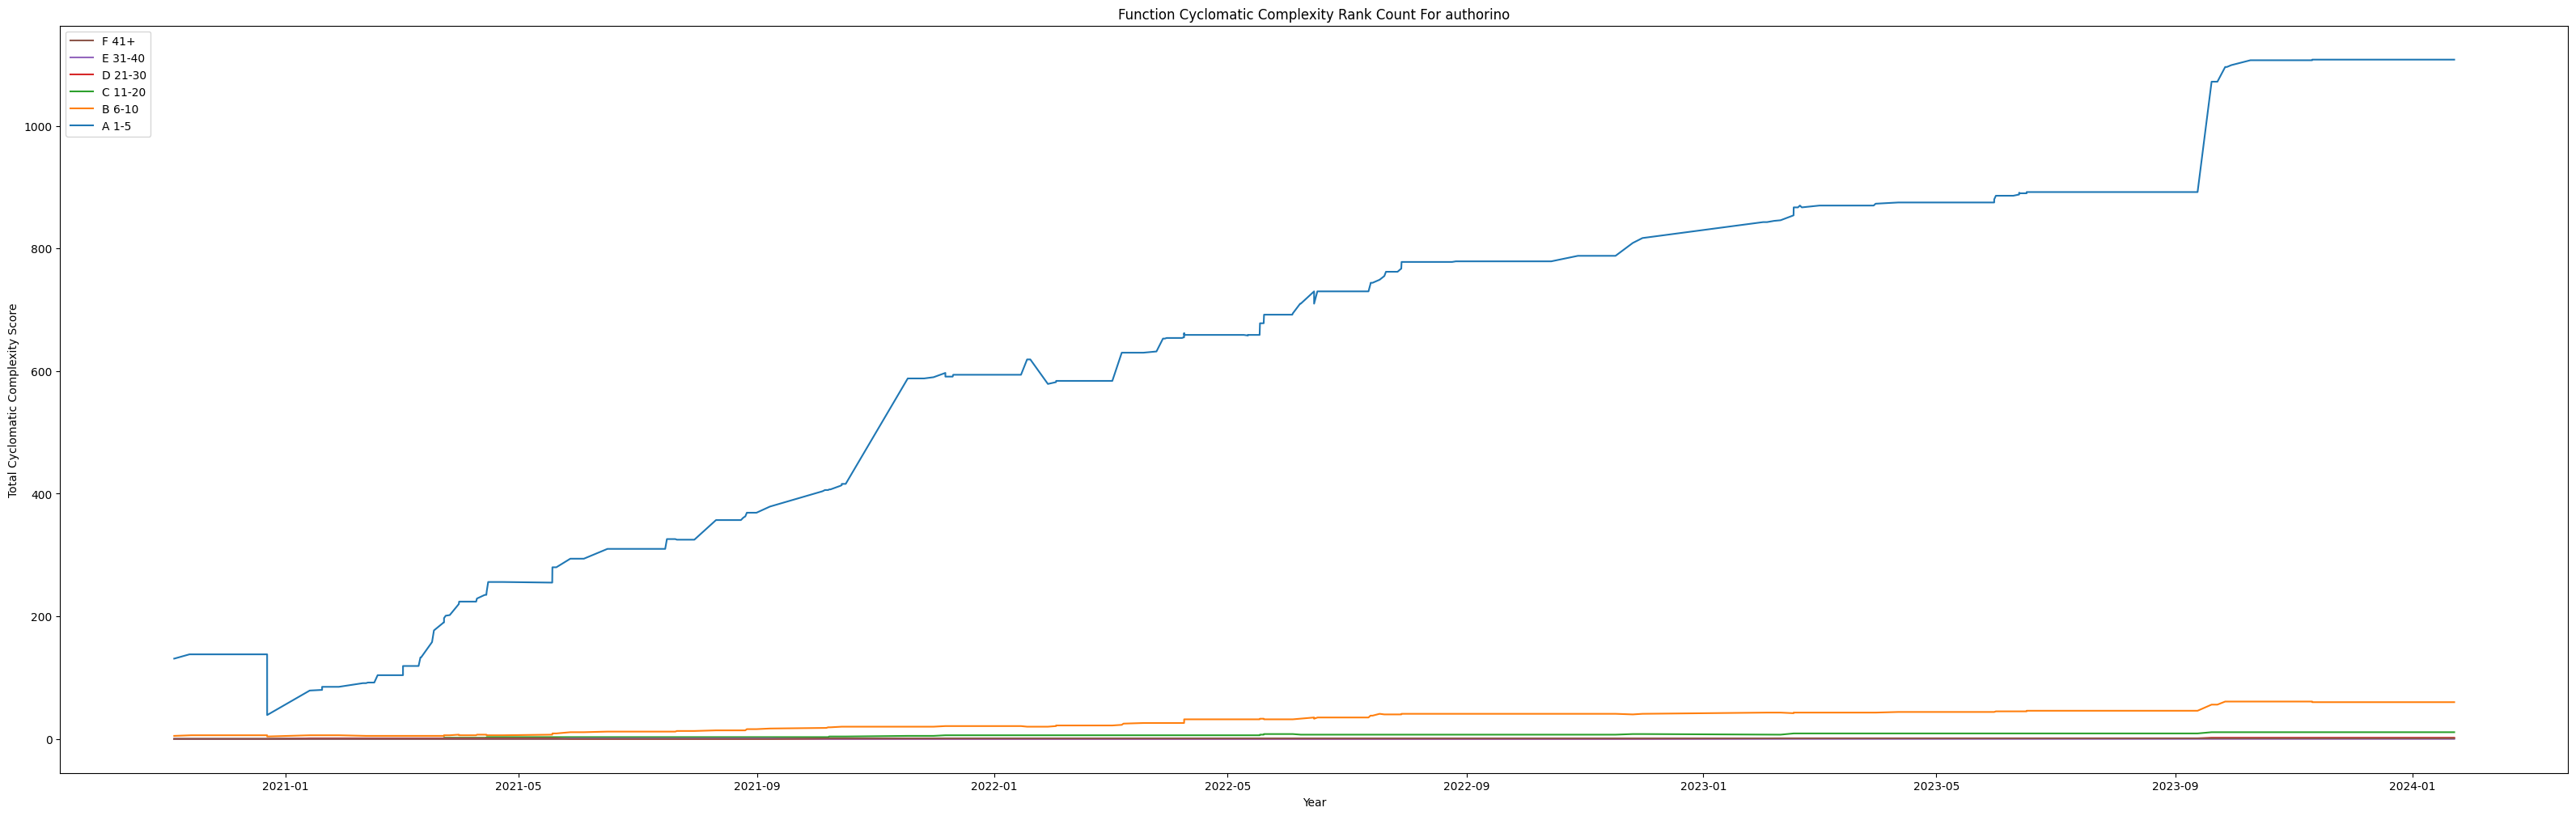

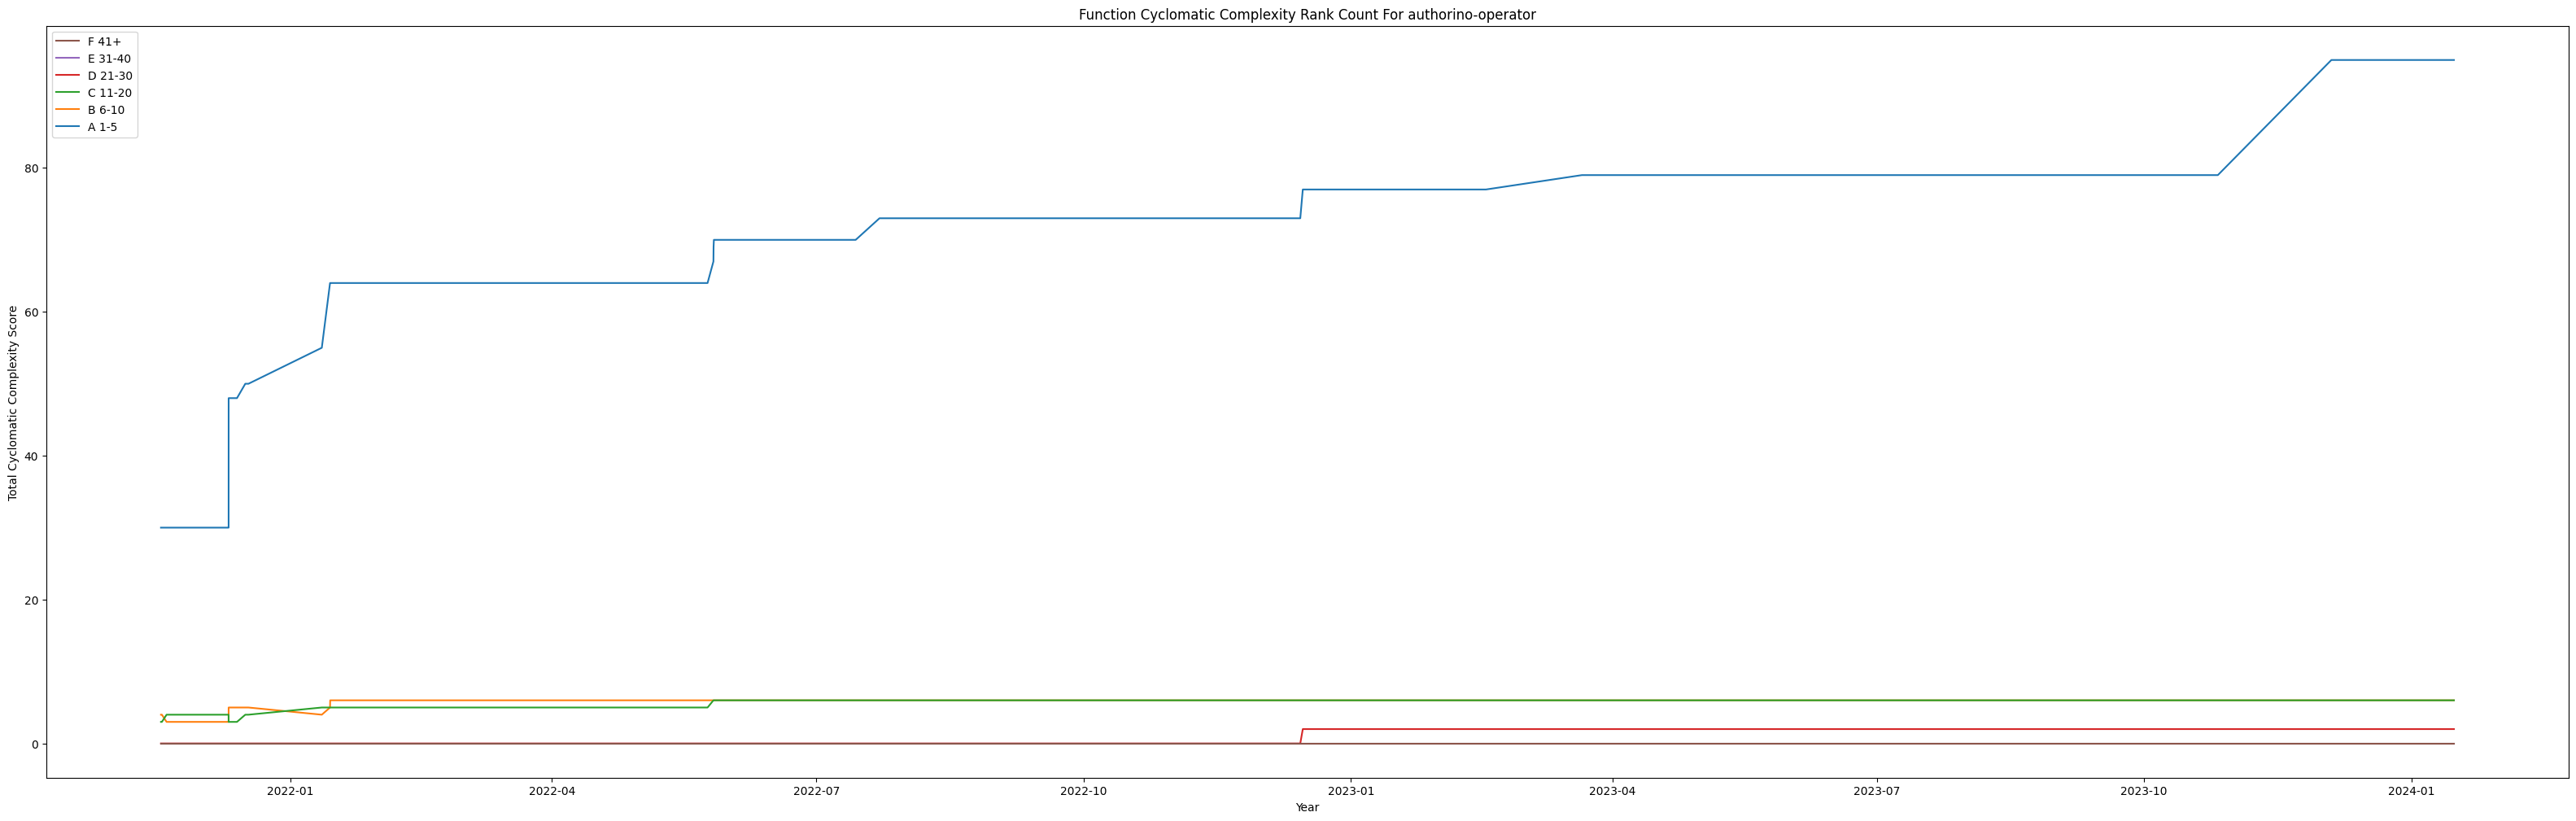

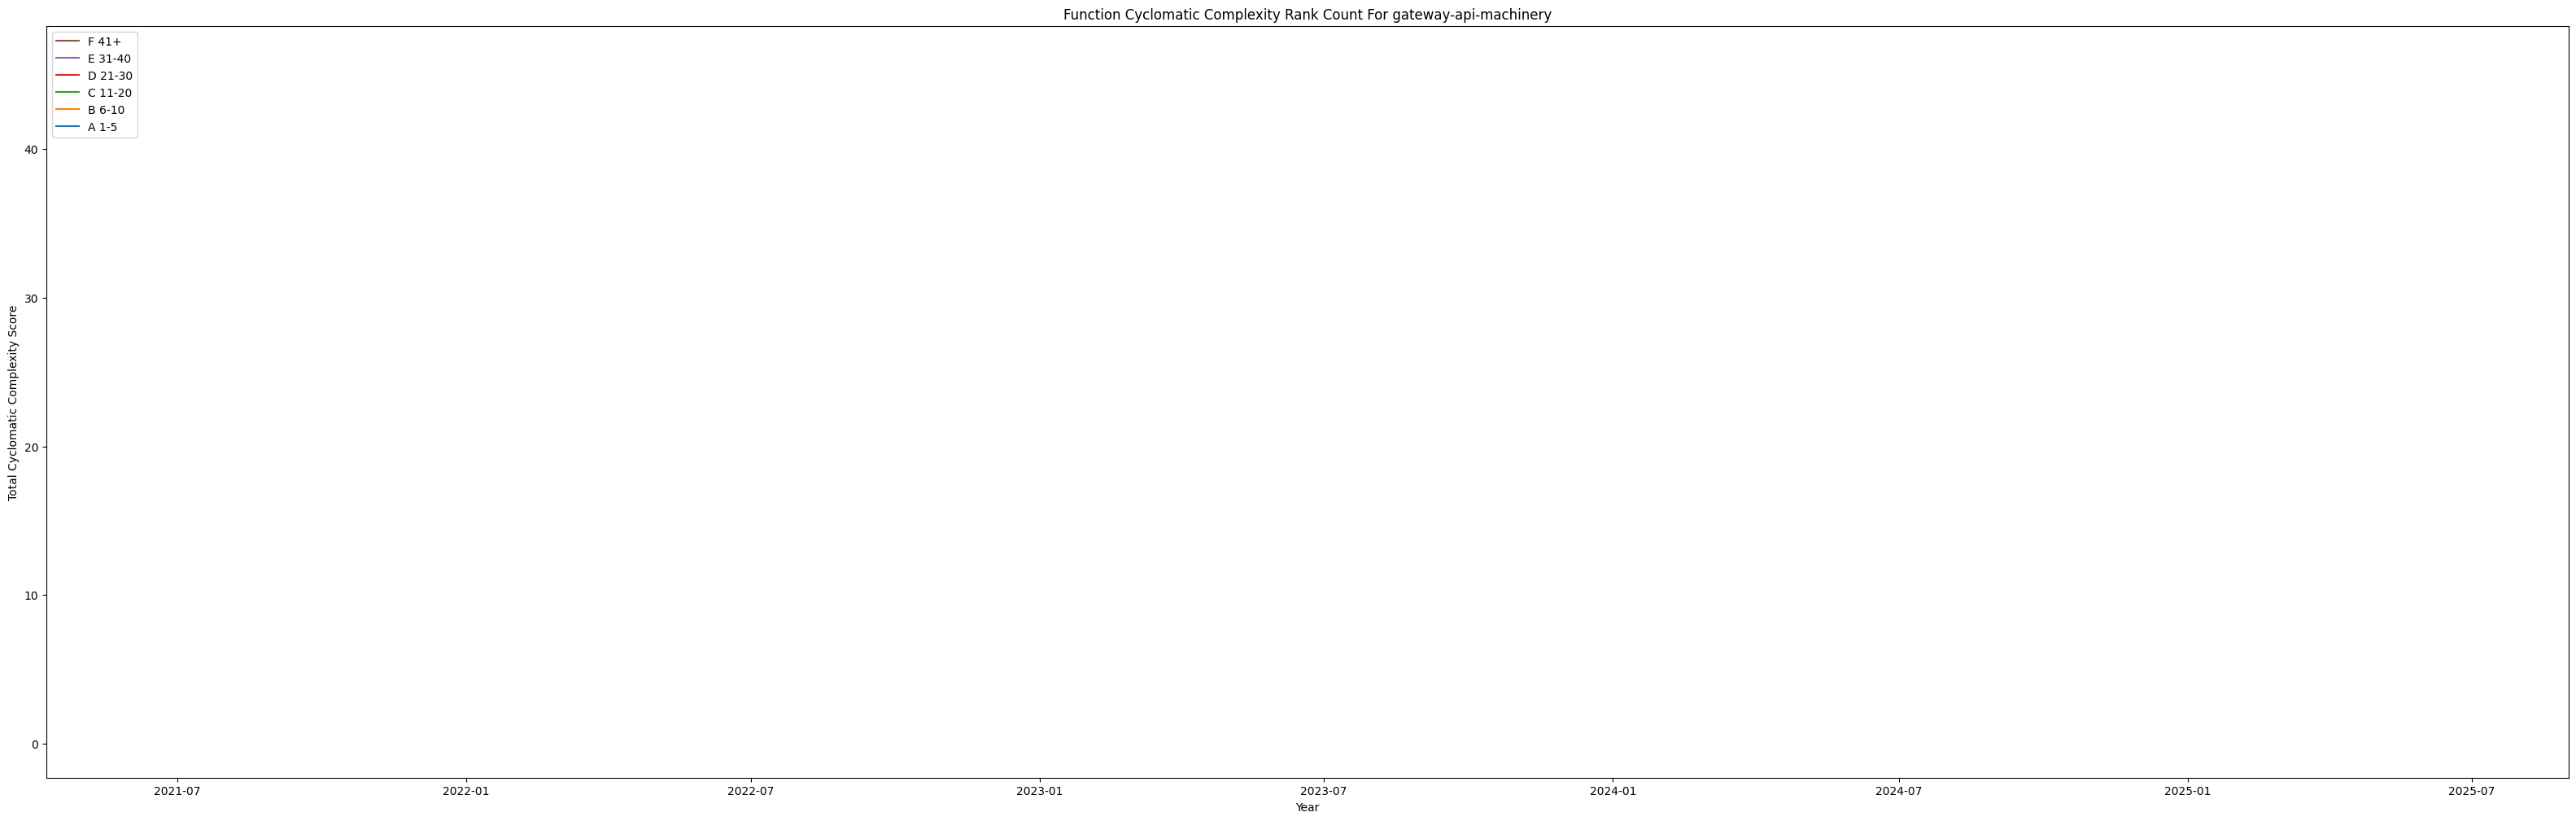

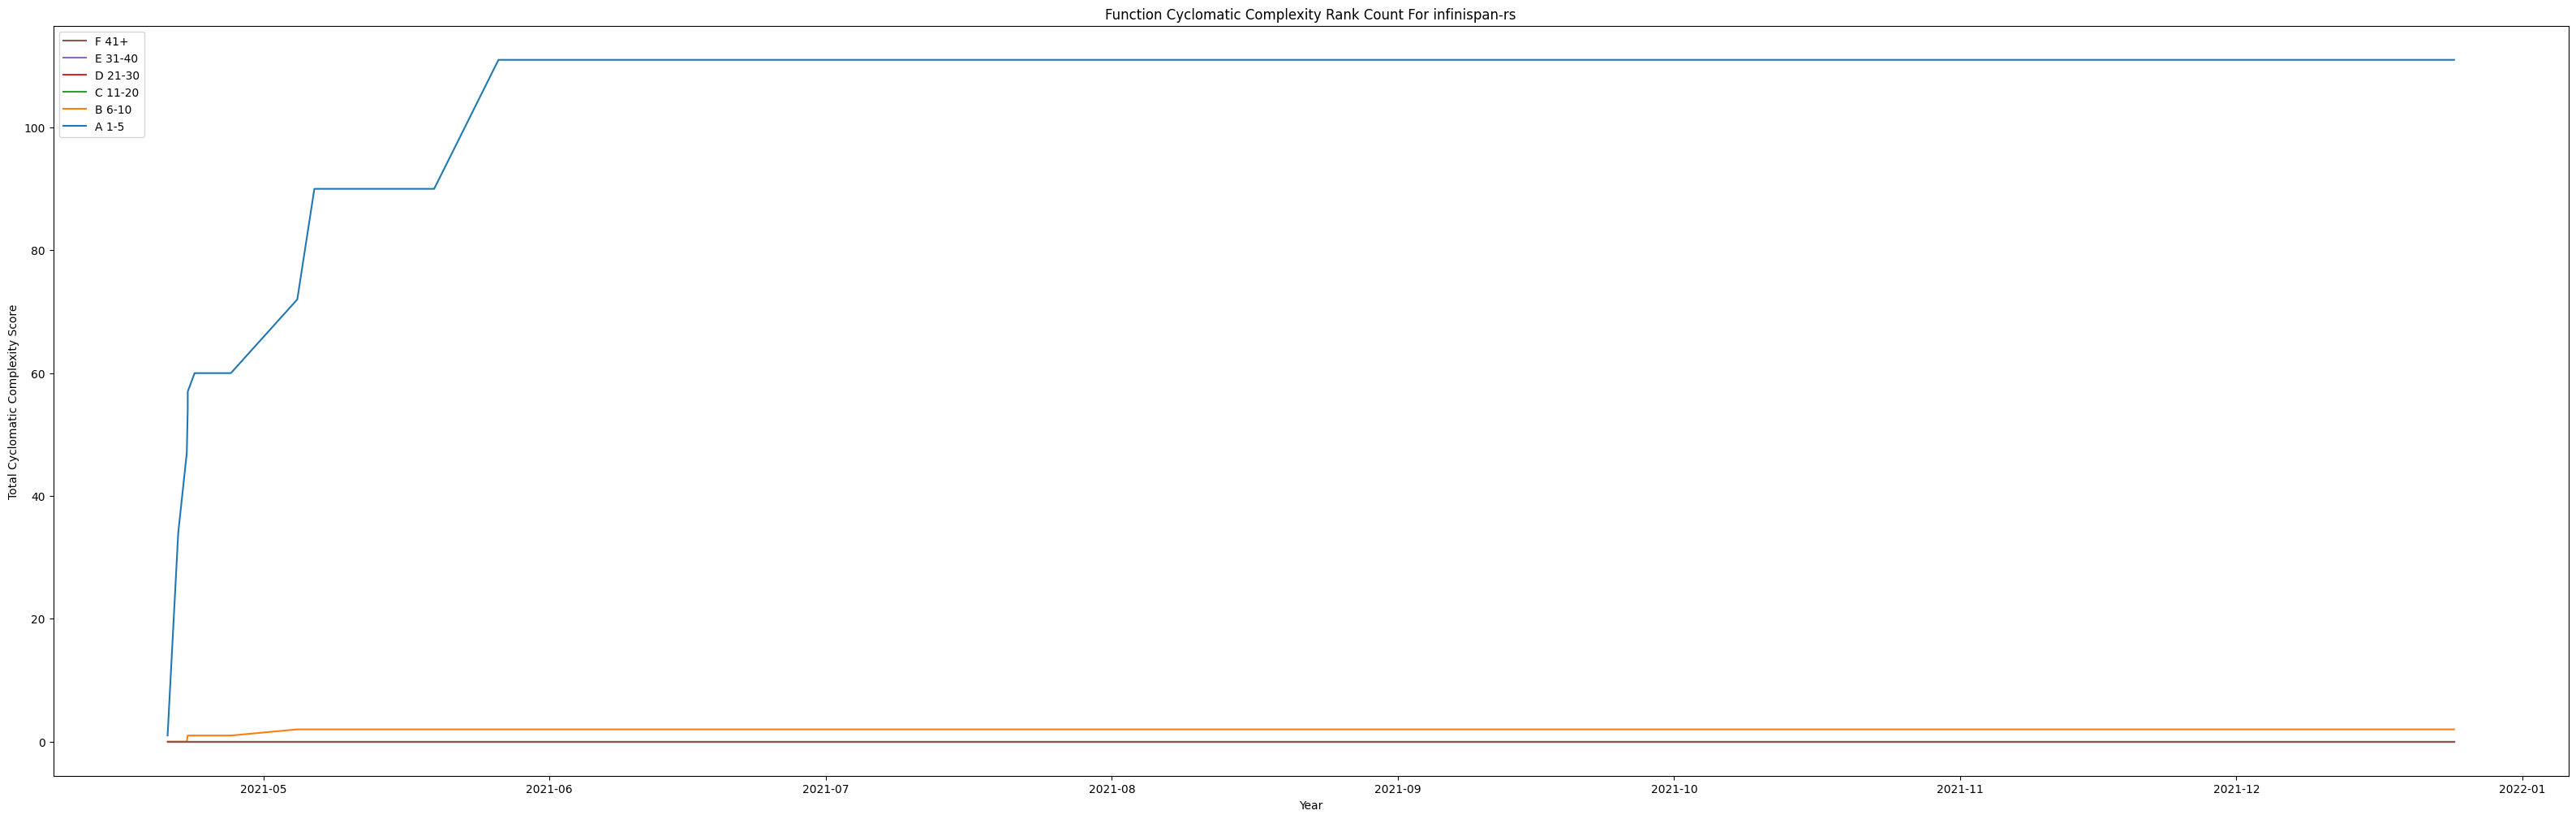

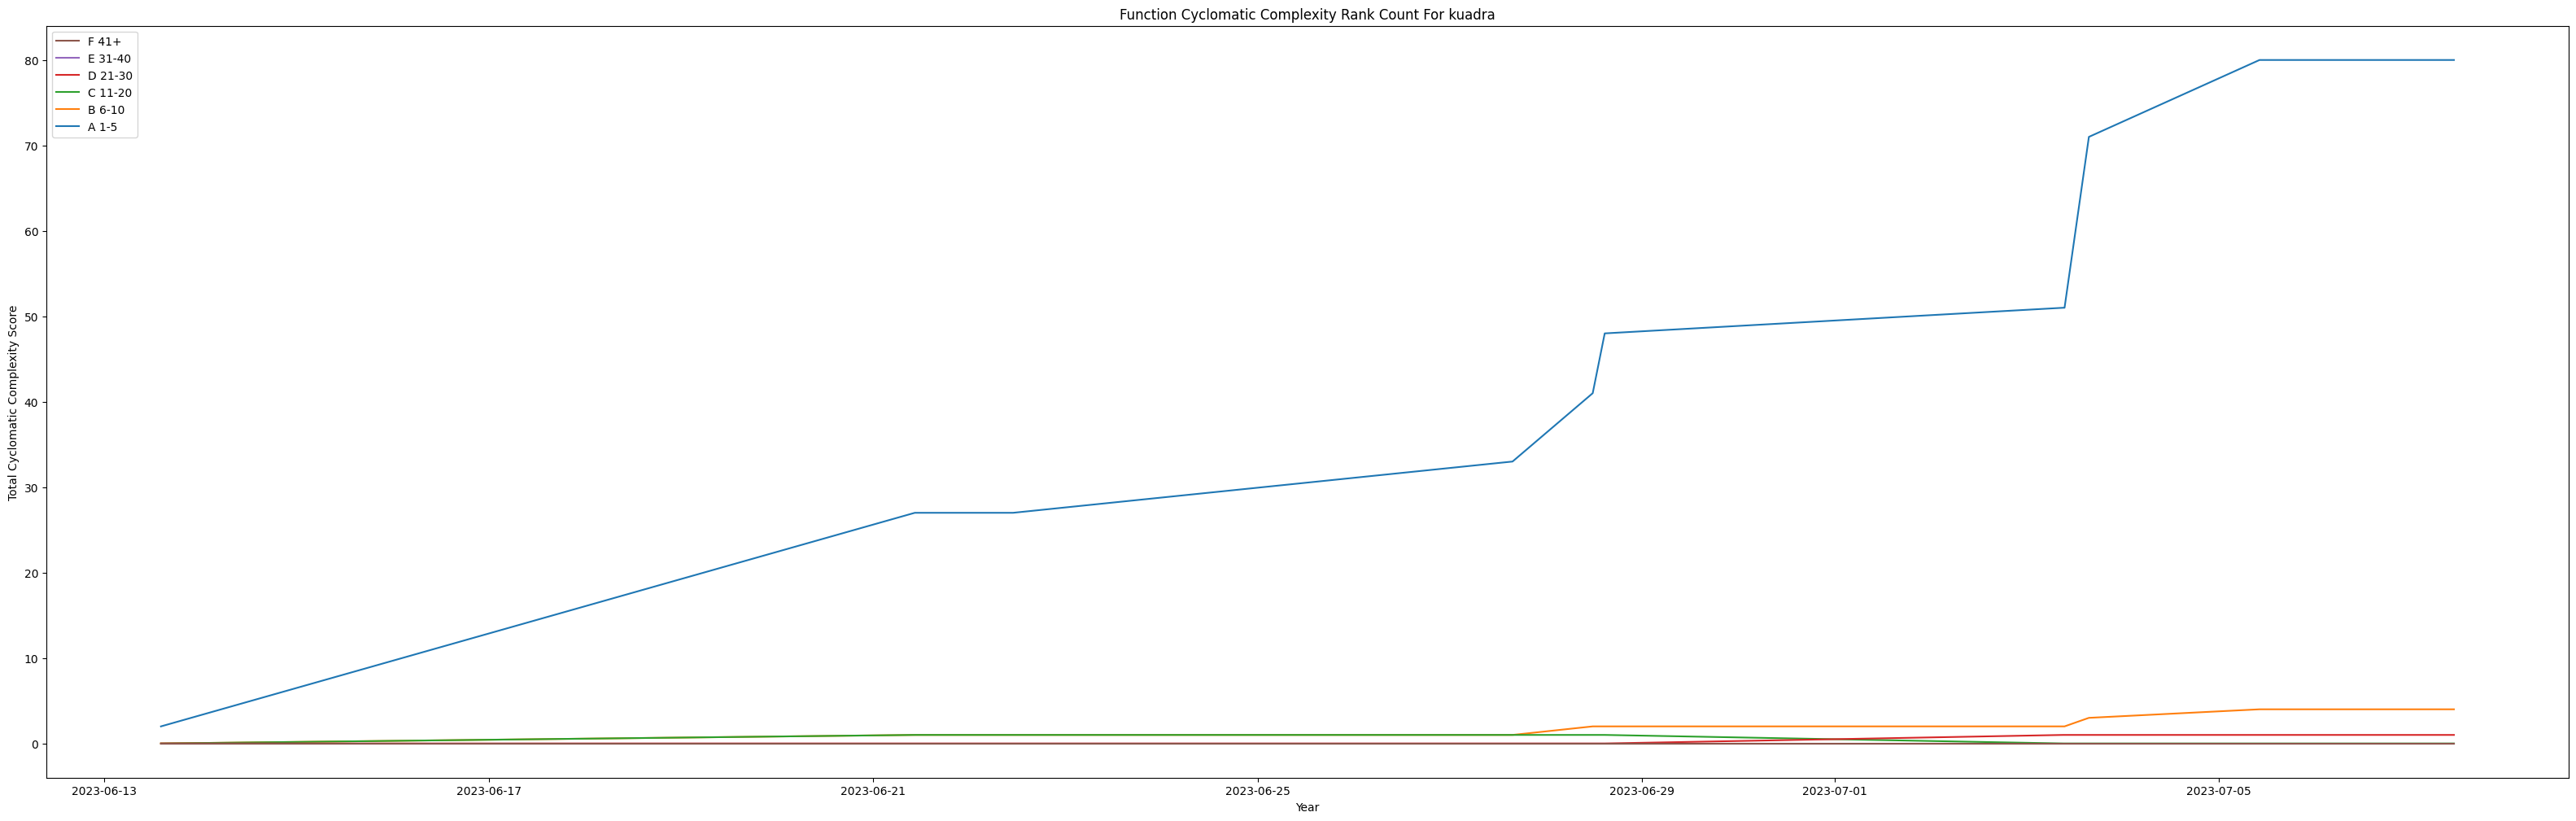

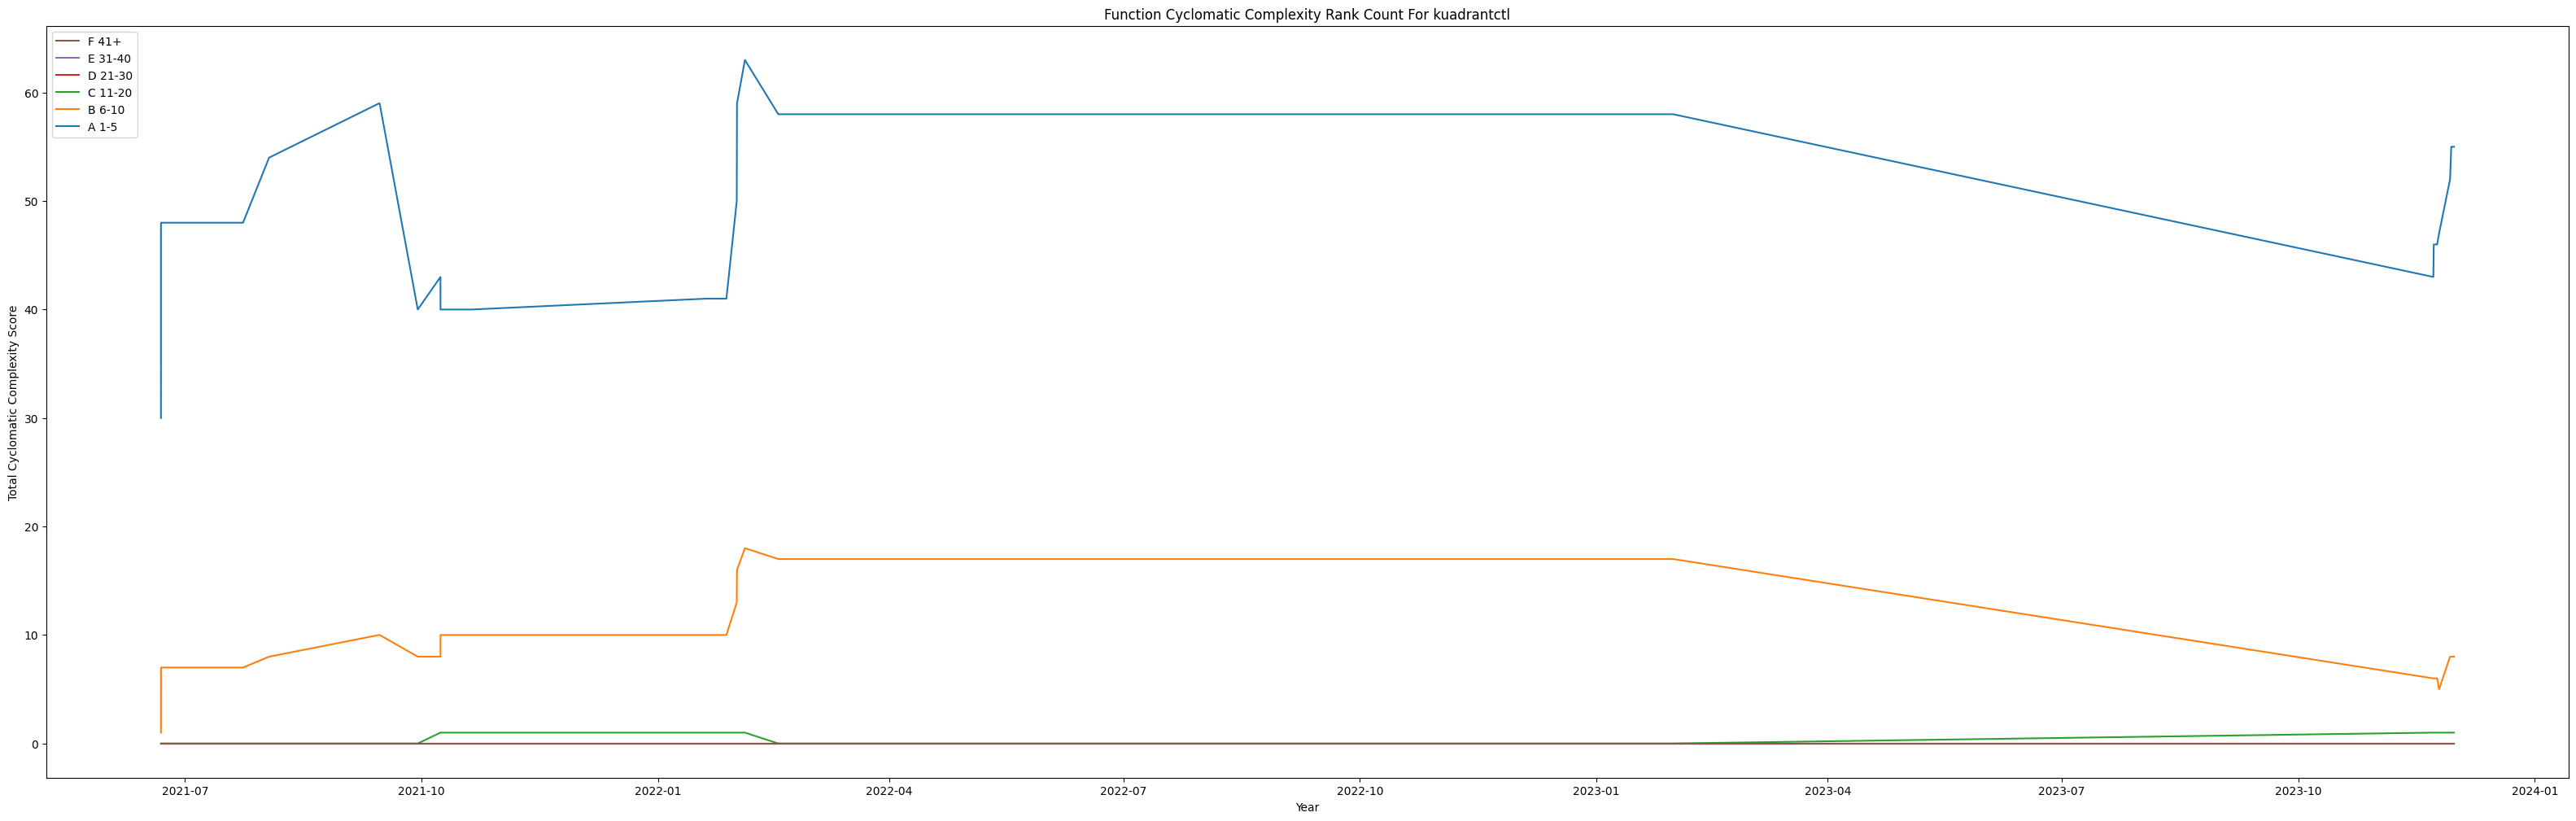

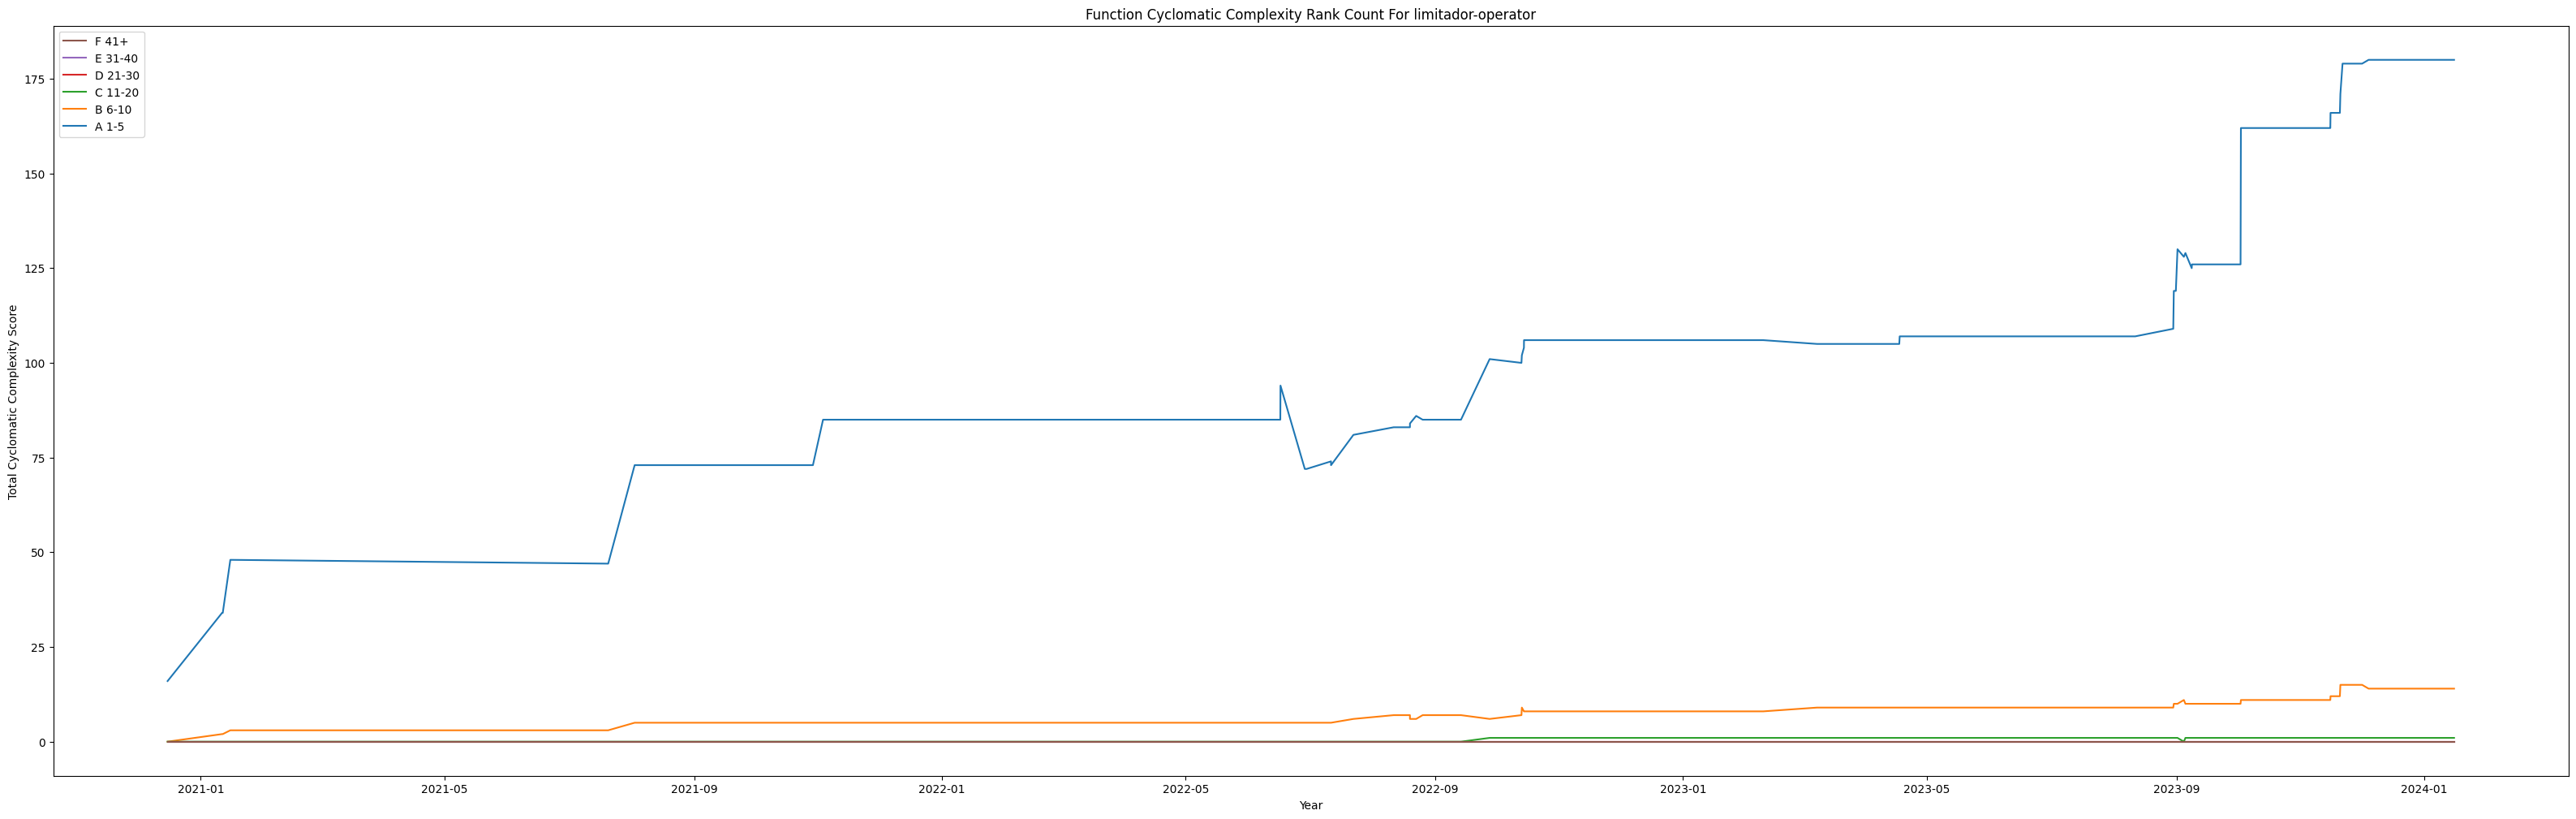

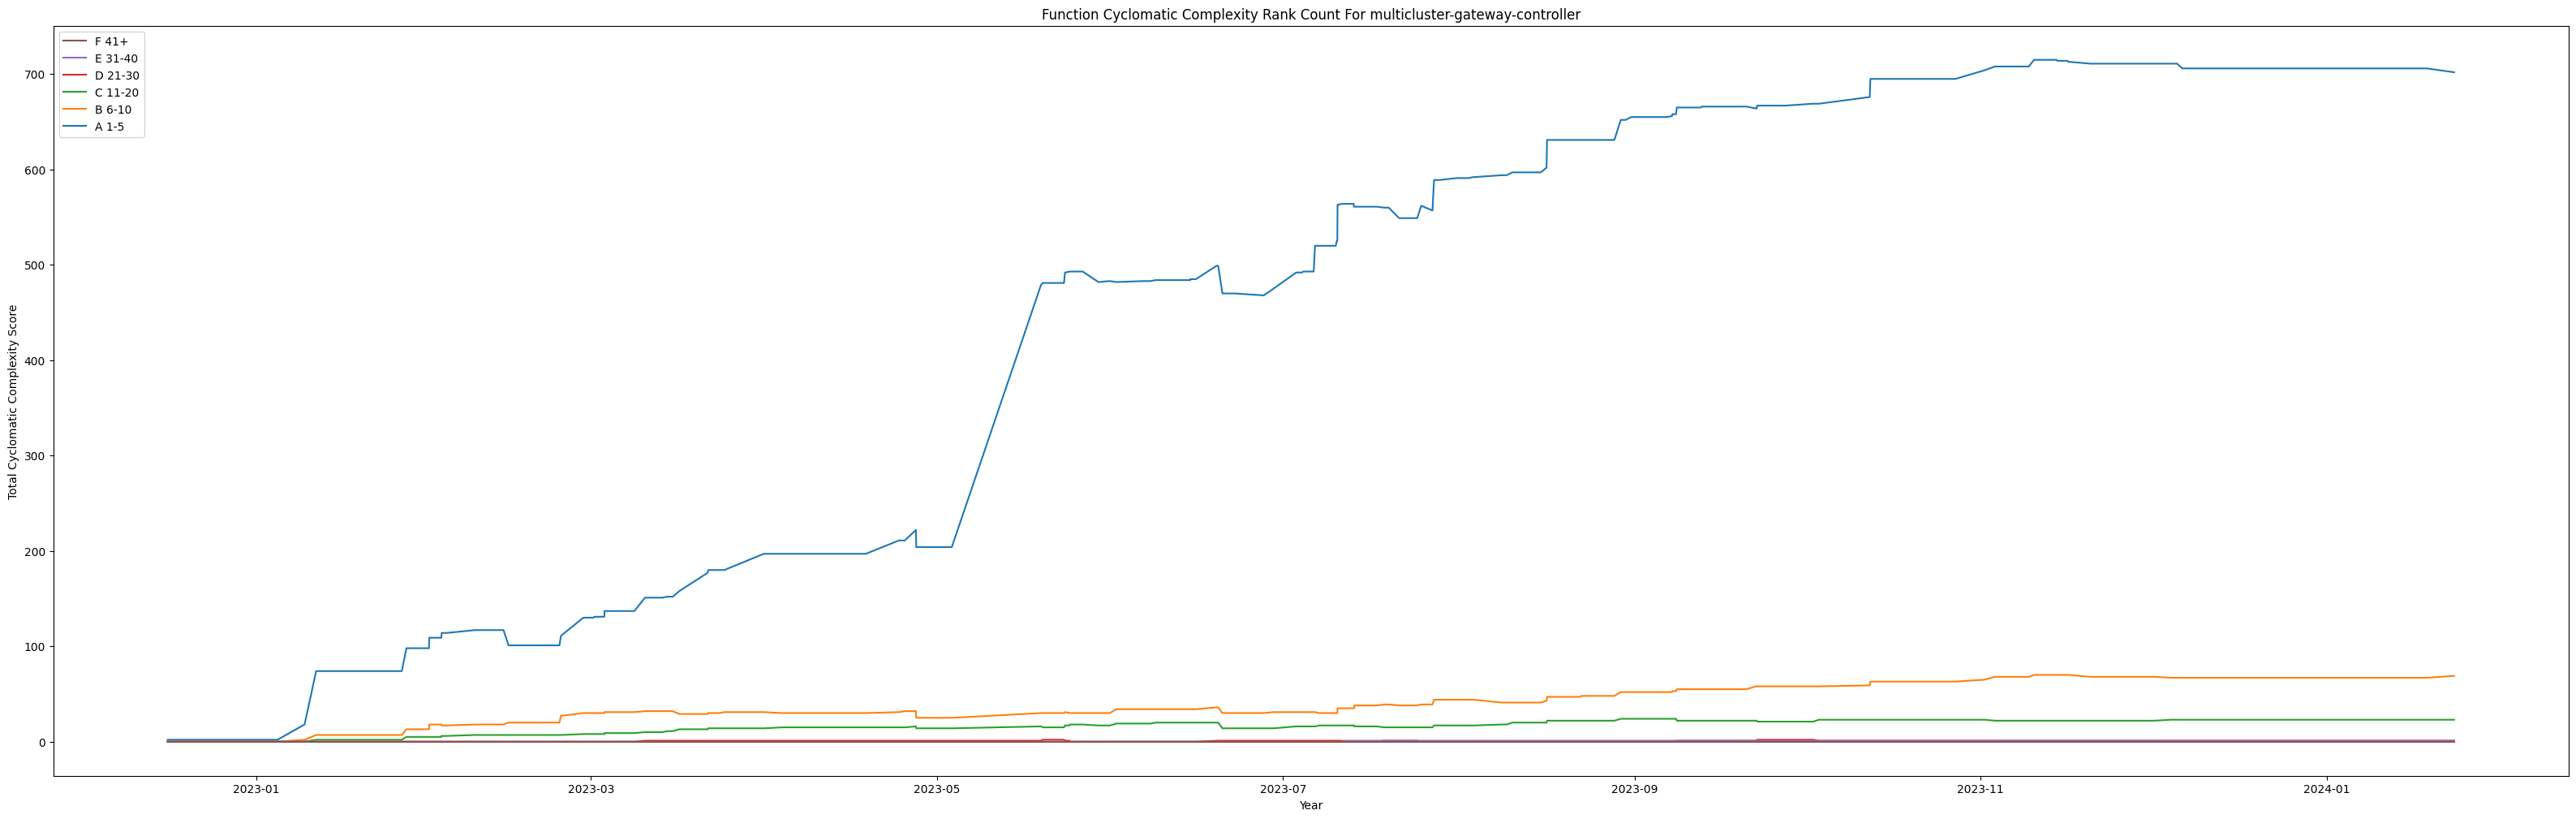

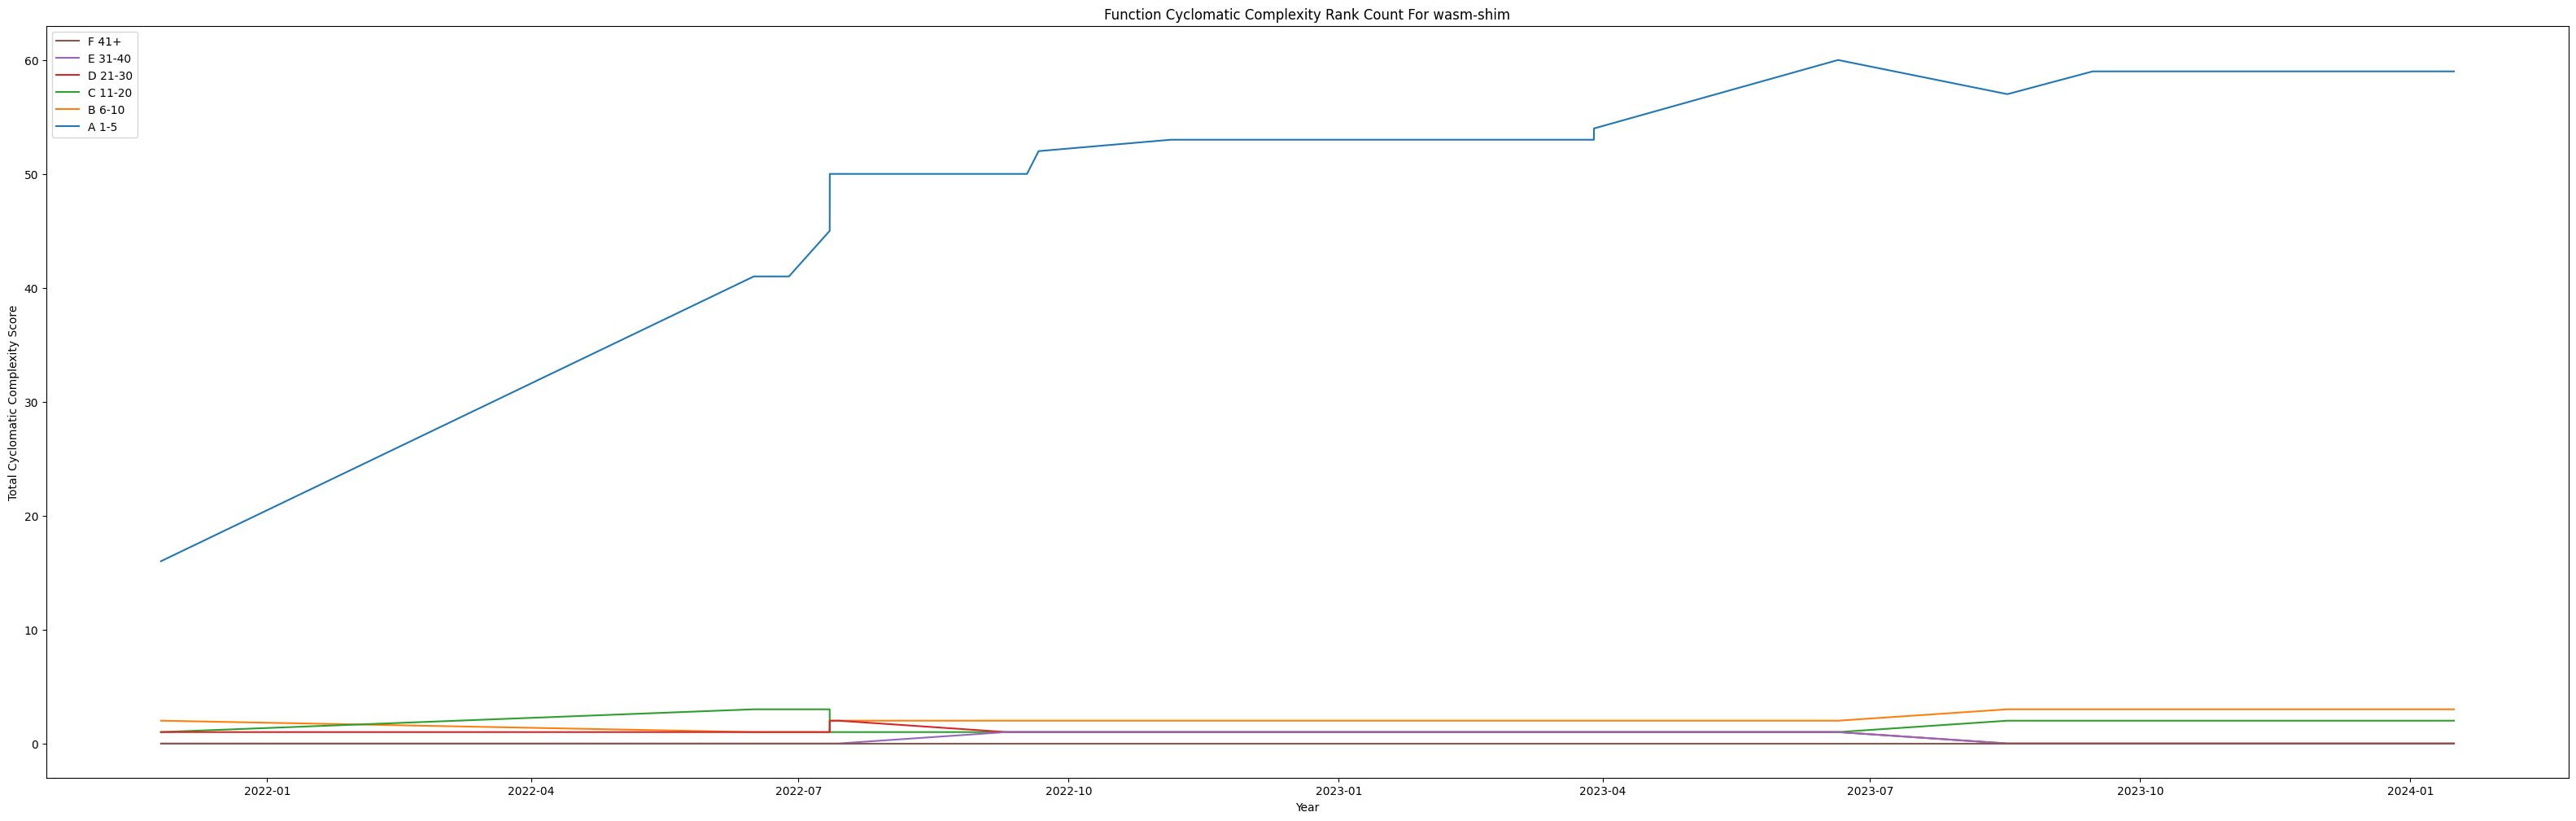

In [571]:
project_data = {}

for project in data:
    project_data[project] = {}
    for row in data[project]:
        if not bool(row['cc']):
            break
        tmp = {row['timestamp']: 0}
        counter = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0}
        result = categorised_cc_func_count(row['cc'])
        for r in result:
            counter[r] += result[r]
        project_data[project][row['timestamp']] = counter

    if not bool(project_data[project]):
        project_data.pop(project)

project_list = project_data.keys()
project_list = sorted(project_list)

keys_value = {"A 1-5": "A", "B 6-10": "B", "C 11-20": "C", "D 21-30": "D", "E 31-40": "E", "F 41+": "F"}
for idx, project in enumerate(project_list):
    
    fig, ax = plt.subplots(figsize=(40, 12))
    timestamp = []
    values = {}
    for entry in project_data[project]:
        timestamp.append(datetime.strptime(entry, timestamp_format))
        for k in project_data[project][entry]:
            if k not in values:
                values.setdefault(k, [])
            values[k].append(project_data[project][entry][k])

    for key in keys_value:
        ax.plot(timestamp, values[keys_value[key]], label=key)
    ax.set_title(f'Function Cyclomatic Complexity Rank Count For {project}')
    ax.legend(loc='upper left', reverse=True)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Cyclomatic Complexity Score')

plt.show()
